In [1]:
import random as rd
import astropy.io.fits as apf
import batman
import eleanor
import emcee
import getpass
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.backends.backend_pdf import PdfPages
from multiprocessing import Pool
from multiprocessing import Process
import multiprocessing
import numpy as np
import os
import pandas as pd
import shutil
import time as tm 
from astroquery.mast import Catalogs
import astropy.units as units
from astropy.wcs import WCS
import math
import astropy.io.fits as apf
from astropy.stats import sigma_clip
import warnings
warnings.filterwarnings("ignore")
from wotan import flatten
import lightkurve as lk
import corner
import numpy as np
import juliet
import matplotlib.gridspec as gridspec
import mpl_axes_aligner

from astropy.timeseries import BoxLeastSquares
from ldtk import LDPSetCreator, BoxcarFilter, TabulatedFilter, SVOFilter
from ldtk.filters import tess, sdss_z
from astroquery import svo_fps

import mr_forecast as mr
import numba
from math import floor
from functools import partial


from transitleastsquares import (
    transitleastsquares,
    cleaned_array,
    catalog_info,
    transit_mask
    )


import itertools


In [2]:
def transit_mask(t, period, duration, T0):
    # Works with numba, but is not faster
    mask = np.abs((t - T0 + 0.5 * period) % period - 0.5 * period) < 0.5 * duration
    return mask





t0 = 4.
period = 8.
duration = 5.

time = np.array(range(100))*1.

transit_mask(time, period, duration, t0)

array([False, False,  True,  True,  True,  True,  True, False, False,
       False,  True,  True,  True,  True,  True, False, False, False,
        True,  True,  True,  True,  True, False, False, False,  True,
        True,  True,  True,  True, False, False, False,  True,  True,
        True,  True,  True, False, False, False,  True,  True,  True,
        True,  True, False, False, False,  True,  True,  True,  True,
        True, False, False, False,  True,  True,  True,  True,  True,
       False, False, False,  True,  True,  True,  True,  True, False,
       False, False,  True,  True,  True,  True,  True, False, False,
       False,  True,  True,  True,  True,  True, False, False, False,
        True,  True,  True,  True,  True, False, False, False,  True,
        True])

In [3]:
a = [[1,2,3], [6,8,10], ['a']]
list(itertools.chain.from_iterable(a))

[1, 2, 3, 6, 8, 10, 'a']

In [4]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [5]:
TICIDs = [150428135, 259377017, 235678745, 467179528, 284441182, 36724087, 441798995, 219195044]



In [6]:
"""I'm going to go ahead and outline the steps to take:
1) Define output and input directories 
2) Check to see if you have already started your search, and if so get the times in transit AND TICIDs/GAIAids
3) Detrend data with wotan
3) Get outliers for each target and create a histogram of frequent outline points. Mask them. 
4) Save new flux+time data in fits file (if you can)
5) Before beginning SNR search: 
    a) calculate CDPP
    b) create SNR grid, getting min rp and duration
    c) calc limb darkening (?)
6) begin SNR search
    a) using """

"I'm going to go ahead and outline the steps to take:\n1) Define output and input directories \n2) Check to see if you have already started your search, and if so get the times in transit AND TICIDs/GAIAids\n3) Detrend data with wotan\n3) Get outliers for each target and create a histogram of frequent outline points. Mask them. \n4) Save new flux+time data in fits file (if you can)\n5) Before beginning SNR search: \n    a) calculate CDPP\n    b) create SNR grid, getting min rp and duration\n    c) calc limb darkening (?)\n6) begin SNR search\n    a) using "

In [7]:
RP_REFERENCE = 0.05

In [8]:
t0_vals = np.array([2458880.0993, 2458821.62181, 2458964.8112, 2458816.9952])-2457000

per_vals = np.array([9.977219 , 16.051137 , 27.80978 , 37.42396 ])


def get_transits_in_sect(strt_time, stop_time, t0, per):
    trans_strt = int((strt_time-t0)/per)
    trans_stop = int((stop_time-t0)/per)
    
    trans_nums = sorted([trans_strt, trans_stop])
    transit_nums = np.array(range(trans_nums[0]-1, trans_nums[1]+1))
    return transit_nums*per + t0

In [9]:
"""Let's start the following cells pretending that I have 
1) detrended data
2) sliced the LC
3) run the periodic search and masked out periodic transits
4) gotten a df including M_star, R_star, Teff_star, aLDC, bLDC"""




@numba.jit(nopython=True)
def interpolation_search(x, z):
    n = len(x)
#     print(n)
    assert n > 1
    if z < x[1] or n == 2:
        return 0
    elif z >= x[-2]:
        return n - 2
    imin = 0
    imax = n - 1
    while imax - imin > 1:
        s = (z - x[imin]) / (x[imax] - x[imin])
        j = int(imin + floor((imax - imin) * s))
        if z >= x[j + 1]:
            imin = j + 1
        elif z < x[j]:
            imax = j
        else:
            return j
    return imin


@numba.jit(nopython=True)
def lerp(y, theta):
    return (1 - theta) * y[..., 0] + theta * y[..., 1]


class interp1d(object):
    """
    Adapted from:
    Fast multithreaded linear interpolation, 1D and 2D - Ver. 3.4
    This versione: 15/06/2018
    @author: Marco Maffezzoli, Universita Bocconi
    http://didattica.unibocconi.it/mypage/upload/49183_20180615_035144_INTERPOLATION.PY
    """

    def __init__(self, x_new, x):
        (self._index, self._theta) = self._locate(x_new, x)
        
    @staticmethod
    @numba.guvectorize("(i8[:],f8[:],f8[:],f8[:])", "(m),(m),(n)->(m)")
    def _linear(index, theta, y, y_new):
        for (j, (i, t)) in enumerate(zip(index, theta)):
            y_new[j] = lerp(y[i : i + 2], t)

    def __call__(self, y):
        return self._linear(self._index, self._theta, y)

    @numba.guvectorize("(f8[:],f8[:],i8[:],f8[:])", "(),(n)->(),()")
    def _locate(x_new, x, index, theta =[]):
        index[0] = i = interpolation_search(x, x_new[0])
        theta[0] = (x_new[0] - x[i]) / (x[i + 1] - x[i])

In [10]:
np.array(range(2, 25))*30.

array([ 60.,  90., 120., 150., 180., 210., 240., 270., 300., 330., 360.,
       390., 420., 450., 480., 510., 540., 570., 600., 630., 660., 690.,
       720.])

In [11]:
720/30

24.0

In [12]:
###DEFAULTS CONSTANTS
MAX_DUR = 11.5 #hours

DURATIONS = np.array(range(2, 25))*30
MAXWIDTH_IN_SAMPLES = 24

def calc_dur_arry_and_max_width_in_samples(cadence):
    #calculate the array of durations to create a cache of light curves for the singles search
    max_width_in_samples = int(MAX_DUR*60/cadence)
    
    if max_width_in_samples % 2 != 0:
        max_width_in_samples = max_width_in_samples+1
    
    durations = np.array(range(2, max_width_in_samples+1 ))*cadence
    return max_width_in_samples, durations


RP_REFERENCE = 0.05
T0_FIT_MARGIN = 0.01
TRANSIT_DEPTH_MIN = 2.5 * 10 ** -6  # 10 ppm
SIGNAL_DEPTH = 0.5


In [13]:
###Creating cache of models
def reference_transit(per, rp, a, inc, ecc, w, u, limb_dark, samples = 24, verbose = False):
    """Returns an Earth-like transit of width 1 and depth 1"""
    
    ###Samples = maxwidth of samples = number of points in max duration val
    ###NOTE: TLS requires that this number be EVEN
    
    f = np.ones(1000)
    duration = 1  # transit duration in days. Increase for exotic cases. ###I want the max trans dur to be 12 hrs
    t = np.linspace(-duration * 0.5, duration * 0.5, 1000)
    t_2_lin = np.linspace(0., duration, 1000)
    
    
    print('u, ', u)
    
    ##################################################################################
    ###FOR ME: T=time in lc <- NOT TRUE. WHY: this is a model. I would like each transit 
    ###to start at 0 and then go to x duration BECAUSE using t0 = 0 is EASY and then i
    ###will SHIFT IT so the transit starts at 0 and t0 is size of shift 
    
    
    
    b_model           = batman.TransitParams()
    b_model.t0        = 0  # time of inferior conjunction
    b_model.per       = per  # orbital period, use Earth as a reference
    b_model.rp        = rp  # planet radius (in units of stellar radii)
    b_model.a         = a  # semi-major axis (in units of stellar radii)
    b_model.inc       = inc  # orbital inclination (in degrees)
    b_model.ecc       = ecc  # eccentricity
    b_model.w         = w  # longitude of periastron (in degrees)
    b_model.u         = u  # limb darkening coefficients
    b_model.limb_dark = limb_dark  # limb darkening model
    m = batman.TransitModel(b_model, t)  # initializes model
    model_flux = m.light_curve(b_model)  # calculates light curve

    # Determine start of transit (first value < 1)
    idx_first = np.argmax(model_flux < 1)
    intransit_model_flux = model_flux[idx_first : -idx_first + 1] #because the transit is semetric, can just flip the indexes here
    intransit_time = t[idx_first : -idx_first + 1] 

    # Downsample (bin) to target sample size
    x_new = np.linspace(t[idx_first], t[-idx_first - 1], samples)

    print(len(x_new))
    f = interp1d(x_new, intransit_time)
    downsampled_intransit_model_flux = f(intransit_model_flux)

    # Rescale to height [0..1]
    rescaled = (np.min(downsampled_intransit_model_flux) - downsampled_intransit_model_flux) / (np.min(downsampled_intransit_model_flux) - 1)
    
    if verbose:
        plt.plot(np.linspace(min(intransit_time), max(intransit_time), len(rescaled)), rescaled)
        plt.show()

    return rescaled #, intransit_time


In [14]:
def fractional_transit(
    duration,
    maxwidth,
    depth,
    samples,
    per,
    rp,
    a,
    inc,
    ecc,
    w,
    u,
    limb_dark,
    cached_reference_transit=None,
):
    """Returns a scaled reference transit with fractional width and depth"""

    if cached_reference_transit is None:
#         print('a')
        reference_flux = reference_transit(
            samples=samples,
            per=per,
            rp=rp,
            a=a,
            inc=inc,
            ecc=ecc,
            w=w,
            u=u,
            limb_dark=limb_dark,
        )
    else:
        reference_flux = cached_reference_transit

    reference_time = np.linspace(-0.5, 0.5, samples)
    occupied_samples = int((duration / maxwidth) * samples)
    x_new = np.linspace(-0.5, 0.5, occupied_samples)
    f = interp1d(x_new, reference_time)
    y_new = f(reference_flux)

    # Patch ends with ones ("1")
    missing_samples = samples - occupied_samples
    emtpy_segment = np.ones(int(missing_samples * 0.5))
    result = np.append(emtpy_segment, y_new)
    result = np.append(result, emtpy_segment)
    if np.size(result) < samples:  # If odd number of samples
        result = np.append(result, np.ones(1))

    # Depth rescaling
    result = 1 - ((1 - result) * depth)

    return result



def get_cache(durations, rp = 0.03, per=25., a =0.15*215., inc=89.5, ecc=0., w=180., u=[0.2, 0.1],
              limb_dark='quadratic', verbose=False, maxwidth_in_samples = 24.):
    """Fetches (size(durations)*size(depths)) light curves of length 
        maxwidth_in_samples and returns these LCs in a 2D array, together with 
        their metadata in a separate array."""
    
    if verbose:
        print("Creating model cache for", str(len(durations)), "durations")
    lc_arr = []
    rows = np.size(durations)
    lc_cache_overview = np.zeros(
        rows,
        dtype=[("duration", "float128"), ("width_in_samples", "int64"), ("overshoot", "float128")],
    )
    cached_reference_transit = reference_transit(
        per=per,
        rp=rp,
        a=a,
        inc=inc,
        ecc=ecc,
        w=w,
        u=u,
        limb_dark=limb_dark,
    )

    row = 0
    for duration in durations:
        scaled_transit = fractional_transit(
            duration=duration,
            maxwidth=np.max(durations),
            depth=SIGNAL_DEPTH,
            samples=maxwidth_in_samples,
            per=per,
            rp=rp,
            a=a,
            inc=inc,
            ecc=ecc,
            w=w,
            u=u,
            limb_dark=limb_dark,
            cached_reference_transit=cached_reference_transit,
        )
        lc_cache_overview["duration"][row] = duration
        used_samples = int((duration / np.max(durations)) * maxwidth_in_samples)
        lc_cache_overview["width_in_samples"][row] = used_samples
        
        full_values = np.where( scaled_transit < (1 - 0.01 * 10 ** -6 ) )
        
        first_sample = np.min(full_values)
        last_sample = np.max(full_values) + 1
        signal = scaled_transit[first_sample:last_sample]
        lc_arr.append(signal)

        # Fraction of transit bottom and mean flux
        overshoot = np.mean(signal) / np.min(signal)
        # Later, we multiply the inverse fraction ==> convert to inverse percentage
        lc_cache_overview["overshoot"][row] = 1 / (2 - overshoot)
#         print(overshoot, 1 / (2 - overshoot))
        row += +1
        

    lc_arr = np.array(lc_arr, dtype=object)
    return lc_cache_overview, lc_arr


In [15]:
list_=np.zeros(10)
residuals = np.full(len(list_), np.nan, dtype=[('chi2','object')])
residuals

array([(nan,), (nan,), (nan,), (nan,), (nan,), (nan,), (nan,), (nan,),
       (nan,), (nan,)], dtype=[('chi2', 'O')])

In [16]:
def lowest_residuals_in_this_duration(
    mean,
    time,
    transit_depth_min,
    data_arr,
    duration,
    signal,
    inverse_squared_dy_arr,
    overshoot,
    ootr,
    chosen_transit_row,
    datapoints,
    T0_fit_margin, 
    threshold = 7.3, 
    verbose = True
):
    T0 = []
    T0_st_indx = []
    SNR = threshold
    residuals_depths = np.full(len(time), np.nan, dtype = ([("residuals", "float128"), ("depths", "float128")]))
    # if nothing is fit, we fit a straight line: signal=1. Then, at dy=1,
    # the squared sum of residuals equals the number of datapoints
    summed_residual_in_rows = datapoints

    xth_point = 1  # How many cadences the template shifts forward in each step
    if T0_fit_margin > 0 and duration > T0_fit_margin:
        T0_fit_margin = 1 / T0_fit_margin
        xth_point = int(duration / T0_fit_margin)
        if xth_point < 1:
            xth_point = 1

    for i in range(len(mean)):
        if (mean[i] > transit_depth_min) and (i % xth_point == 0):
            data = data_arr[i : i + duration]
            flux_oot = np.delete(data_arr, range(i,i+duration))

            dy = inverse_squared_dy_arr[i : i + duration]
            target_depth = mean[i] * overshoot
            scale = SIGNAL_DEPTH / target_depth
            reverse_scale = 1 / scale  # speed: one division now, many mults later
            snr = (mean[i] / (np.std(flux_oot)*np.sqrt(0.5))) * duration ** (0.5)
            if snr>SNR:
                SNR=snr
            intransit_residual = 0
            for j in range(len(signal)):
                sigi = (1 - signal[j]) * reverse_scale
                intransit_residual += ((data[j] - (1 - sigi)) ** 2) * dy[j]
            current_stat = intransit_residual + ootr[i] #- summed_edge_effect_correction
            
            residuals_depths['residuals'][i] = current_stat
            residuals_depths['depths'][i] = 1-target_depth
            
    residuals = residuals_depths['residuals'].astype('float128')

    if np.nanmin(residuals)<=np.nanmedian(residuals)-4*np.nanstd(residuals) and SNR>threshold:
        indexes = np.where(residuals<=np.nanmedian(residuals)-4*np.nanstd(residuals))[0]
        for jjj in indexes:
            if jjj and jjj+1 in indexes:
                T0_st_indx.extend(np.where(residuals == min(residuals[[jjj, jjj+1]]))[0])
        
        if verbose:
#             print(duration*30/60, 'planets Tdur: ', Toi270_Tdur)#' Tdur_p4:', Toi270_Tdur[3])
            fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(20,5))
            
            norm_resid = residuals/np.nanmedian(residuals)
        
            axes[0].plot(time, norm_resid, zorder = 10)

            axes[1].scatter(time, data_arr, s = 1, zorder = 11, alpha = 1, color = 'black')
            
            ylims1 = axes[0].get_ylim()
            ylims2 = axes[1].get_ylim()
            xlims = axes[1].get_xlim()

            for j in range(1,7):
                axes[0].hlines(np.nanmedian(norm_resid)-j*np.nanstd(norm_resid), np.min(time), np.max(time), alpha = 0.5, zorder = 3, color = 'violet')
#             for bbb in range(len(t0_vals)):
#                 transit_times = get_transits_in_sect(np.min(time), np.max(time), t0_vals[bbb], per_vals[bbb])
#                 axes[0].vlines(transit_times, min(ylims1), max(ylims1), zorder = 2, color = 'C'+str(bbb+2))
#                 axes[1].vlines(transit_times, min(ylims2), max(ylims2), zorder = 2, color = 'C'+str(bbb+2))
#             axes[0].set_xlim(xlims)
#             axes[1].set_xlim(xlims)
            plt.subplots_adjust(wspace=0.2, hspace=0)
            plt.show()

    
        return SNR, np.array(list(residuals_depths['residuals'].astype('float128'))), np.array(list(residuals_depths['depths'].astype('float128'))), T0_st_indx
    else:
        return 0, [],[], []
    
    

In [17]:
# @numba.jit(fastmath=True, parallel=False, nopython=True)
def out_of_transit_residuals(data, width_signal, inv_sq_dy):
#     print(len(data), data)
    chi2 = np.zeros(len(data) - width_signal + 1)
    fullsum = np.sum(((1 - data) ** 2) * inv_sq_dy)
    window = np.sum(((1 - data[:width_signal]) ** 2) * inv_sq_dy[:width_signal])
    chi2[0] = fullsum - window
    for i in range(1, len(data) - width_signal + 1):
        becomes_visible = i - 1
        becomes_invisible = i - 1 + width_signal
        add_visible_left = (1 - data[becomes_visible]) ** 2 * inv_sq_dy[becomes_visible]
        remove_invisible_right = (1 - data[becomes_invisible]) ** 2 * inv_sq_dy[
            becomes_invisible
        ]
        chi2[i] = chi2[i - 1] + add_visible_left - remove_invisible_right
    return chi2


In [18]:
np.array([[1,3,6,1,4], [0, 6, 4, 6,2], [2,5,1,3,6]])

array([[1, 3, 6, 1, 4],
       [0, 6, 4, 6, 2],
       [2, 5, 1, 3, 6]])

In [19]:
np.array([[1,3,6,1,4], [0, 6, 4, 6,2], [2,5,1,3,6]])

array([[1, 3, 6, 1, 4],
       [0, 6, 4, 6, 2],
       [2, 5, 1, 3, 6]])

In [20]:
color_set = ['#00E9F5',  '#22DAD2', '#44CBAF', 
         '#66BC8C', '#88AD69', '#AA9E46',  
         '#CC8F23', '#EB8300', '#F19508',
         '#F8A610','#FFB718']


In [21]:
from matplotlib.patches import Patch
# pbs = []
# for i in set(color):
#     pb = Patch(facecolor=i, edgecolor='None')
#     pbs.append(pb)

# ax.legend(handles=pbs,
#           labels=['', '', '', '', 'First', 'Second'],
#           ncol=3, handletextpad=0.5, handlelength=1.0, columnspacing=-0.5,
#           loc='center', fontsize=16)



In [22]:

def search_best_fit_duration(
#     duration,
    t,
    y,
    dy,
    transit_depth_min,
    lc_arr,
    lc_cache_overview,
    T0_fit_margin,
    verbose = True
):
    """Running to search for best fit duration"""

    # duration (in samples) of widest transit in lc_cache (axis 0: rows; axis 1: columns)
    npoints_in_duration = np.unique(lc_cache_overview["width_in_samples"])
    T0_vals = np.full(
        100, np.nan, 
        dtype=[('T0_start', 'float128'), ('T0', 'float128'), ('residuals', 'float128'), ('best_dur', 'int64'), ('best_depth', 'float128')]
    )

    Residuals_all = []
    inverse_squared_dy = 1 / dy ** 2
#     print('lengths', len(dy), len(y), len(t), len(inverse_squared_dy))

#     skipped_all = True
    T0_starts = []
    for i in range(len(npoints_in_duration)):
        dur = npoints_in_duration[i]

        chosen_transit_row = 0
        while lc_cache_overview["width_in_samples"][chosen_transit_row] != dur:
            chosen_transit_row += 1
        if len(t)<=dur:
            continue
        snr, residuals, depths, T0_start_indx = lowest_residuals_in_this_duration(
            mean=1 - running_mean(y, dur),
            time = t,
            transit_depth_min=transit_depth_min,
            data_arr=y,
            duration=dur, #note: this is duration in number of points in sample
            signal=lc_arr[chosen_transit_row],
            inverse_squared_dy_arr=inverse_squared_dy,
            overshoot=lc_cache_overview["overshoot"][chosen_transit_row],
            ootr=out_of_transit_residuals(
                y, dur, inverse_squared_dy
            ), #how well the points outside the transit fit to a straight line
            chosen_transit_row=chosen_transit_row,
            datapoints=len(y),
            T0_fit_margin=T0_fit_margin,
        )

       
        residuals = residuals/np.nanmedian(residuals) #normalize
        T0_starts.extend(T0_start_indx)
        T0_starts = list(set(T0_starts))
        if len(residuals)>0:
            Residuals_all.append(residuals)

            for jjj in T0_starts:
                indx = False
                try: 
                    indx = np.where(T0_vals['T0_start']==jjj)[0][0]
                    if float(T0_vals['residuals'][indx])<float(residuals[jjj]): #Trying to get the lowest residual value
                        indx = False

                except:
                    indx = min(np.where(T0_vals['best_dur']==-9223372036854775808)[0])


                T0_vals['T0_start'][indx]   = jjj
                T0_vals['T0'][indx]         = t[jjj]+chosen_transit_row/2/24
                T0_vals['residuals'][indx]  = float(residuals[jjj])
                T0_vals['best_dur'][indx]   = chosen_transit_row
                T0_vals['best_depth'][indx] = float(depths[jjj])

    if (verbose) & (len(Residuals_all)>0):
        color = ['#00E9F5', '#00E9F5', '#22DAD2','#22DAD2', '#44CBAF', '#44CBAF',
                 '#66BC8C','#66BC8C','#88AD69', '#88AD69', '#AA9E46',  '#AA9E46', 
                 '#CC8F23', '#CC8F23', '#EB8300','#EB8300', '#F19508', '#F19508', 
                 '#F8A610','#F8A610', '#FFB718','#FFB718','#FFB718']
        f, ax2 = plt.subplots(1, 1, sharey=False, figsize = (14, 20))
        

        resids = np.array(Residuals_all).transpose()
        if len(Residuals_all)>0.:
            for i in range(len(Residuals_all)):
                ax2.plot(t, Residuals_all[i], color = color[i], lw = 2)
                pbs = []
            for i in color_set:
                pb = Patch(facecolor=i, edgecolor='None')
                pbs.append(pb)

            label = ['']*int(len(color)-1)
        
            ax2.legend(handles=pbs,bbox_to_anchor=(0.2,1.037),
                        labels=label+[''], framealpha=0.,
                        ncol=len(set(color)), handletextpad=0., handlelength=1.05, columnspacing=-0.5, 
                        fontsize=30, labelcolor='#FFD475')


#             print(len(t), np.shape(resids), len(Residuals_all))
#             resids = [np.median(np.array(x)) for x in resids]
            ax3 = ax2.twinx()
            ax3.scatter(t, y, color = '#E4D7BA', zorder = 2, label = 'TESS Observations', s = 40, alpha =1.)
#             ax.set_ylim(0.97, 1.02)
#             ax3.plot(t, resids, color = '#EB8300', zorder = 10)
            handles, labels = ax3.get_legend_handles_labels() # get existing handles and labels
            empty_patch = Patch(color='None', label='Transit Durations Fit: 2-11.5 hours') # create a patch with no color

            handles.append(empty_patch)  # add new patches and labels to list
            labels.append('Transit Durations Fit: 2-11.5 hours')

            ax3.legend(loc = 2, handles = handles, labels = labels, framealpha=0., handletextpad=0.5, 
                       bbox_to_anchor=(0.0,1.11), 
                       fontsize=40, labelcolor='#FFD475')
        
        
            ax3.yaxis.tick_right()
    #         align_yaxis(ax2, 1., ax3, 1.)
            mpl_axes_aligner.align.yaxes(ax2, 1., ax3, 1., 0.7)
            for ax in [ax2, ax3]:
                ax.set_facecolor('None')

                ax.xaxis.label.set_color('#FFD475')        #setting up X-axis label color to yellow
                ax.yaxis.label.set_color('#FFD475')          #setting up Y-axis label color to blue

                ax.tick_params(axis='x', colors='#FFD475', labelsize = 35, width=3, length = 10)    #setting up X-axis tick color to red
                ax.tick_params(axis='y', colors='#FFD475', labelsize = 35, width=3, length = 10)  #setting up Y-axis tick color to black
                ax.spines['top'].set_color(None)        # setting up Y-axis tick color to red
                ax.spines['right'].set_color(None)         #setting up above X-axis tick color to red

                ax.spines['left'].set_color(None)        # setting up Y-axis tick color to red
                ax.spines['bottom'].set_color(None)         #setting up above X-axis tick color to red
                ax.set_xlabel('Time (BJD)', color = '#FFD475', fontsize = 40)
                ax.set_ylabel('Relative Flux', color = '#FFD475', fontsize = 40);

            ax3.yaxis.set_label_position("right")
#             ax1.set_ylabel(r'$\chi^2$ of Transit Fit', fontsize = 40)
            ax3.set_ylabel(r'$\chi^2$ of Transit Fit Values', fontsize = 40, rotation=270, labelpad=75)

            plt.show()
    return np.array(list(T0_vals['T0_start'])), np.array(list(T0_vals['T0'])), np.array(list(T0_vals['best_dur'])), np.array(list(T0_vals['best_depth'])), np.array(list(T0_vals['residuals']))
        

In [23]:
ctlfile = './Total_Mdwarf_files/final_mdwarf_params_new.csv'
mdwarfs = pd.read_csv(ctlfile, iterator =True, chunksize = 100000, index_col=None)

multi_mdwarfs = pd.concat(
    [chunk[chunk['TICID'].astype(int).isin(TICIDs)] 
    for chunk in mdwarfs]
).reset_index(drop=True)

In [24]:
multi_mdwarfs

TICID          RA        DEC    Vmag    Jmag     Tmag    Teff  \
0  150428135.0   97.096787 -65.579312  13.151   9.469  10.9102  3494.0   
1  219195044.0   92.391740 -53.823484  13.311  10.241  11.5436  3731.0   
2  259377017.0   68.415501 -51.956232  12.603   9.099  10.4981  3532.0   
3   36724087.0  154.646405 -11.716734  13.140   9.007  10.5848  3331.0   
4  235678745.0  285.633044  75.418605  13.190   9.797  11.0788  3746.0   
5  441798995.0  264.147791  77.126122  13.476  10.765  11.9521  3872.0   
6  284441182.0   10.088709  61.213626  13.459  10.154  11.4752  3624.0   
7  467179528.0  197.998168  65.833807  12.941   9.706  11.0402  3618.0   

   eTeff_x       Rad      eRad  ...   S54   S55  eTeff_y     logg     elogg  \
0    157.0  0.419457  0.012573  ...   0.0   0.0    157.0  4.80892  0.004651   
1    157.0  0.473141  0.014147  ...   0.0   0.0    157.0  4.76101  0.007200   
2    157.0  0.374358  0.011496  ...   0.0   0.0    157.0  4.85053  0.002090   
3    157.0  0.374139  0.011184  ...   0.0   0.0    157.0  4.85074  0.001634   
4    157.0  0.463205  0.013592  ...  10.0  10.0    157.0  4.76979  0.006479   
5    157.0  0.548484  0.016161  ...  10.0  10.0    157.0  4.69525  0.009462   
6    157.0  0.490120  0.014531  ...   0.0   0.0    157.0  4.74607  0.007723   
7    157.0  0.435666  0.012939  ...   0.0   0.0    157.0  4.79432  0.005376   

   M/H eM/H          GAIA  aLSM  bLSM  
0  NaN  NaN  5.284518e+18   NaN   NaN  
1  NaN  NaN  5.500474e+18   NaN   NaN  
2  NaN  NaN  4.781196e+18   NaN   NaN  
3  NaN  NaN  3.767282e+18   NaN   NaN  
4  NaN  NaN  2.268372e+18   NaN   NaN  
5  NaN  NaN  1.657159e+18   NaN   NaN  
6  NaN  NaN  4.272241e+17   NaN   NaN  
7  NaN  NaN  1.678074e+18   NaN   NaN  

[8 rows x 80 columns]

In [25]:
from tqdm.auto import tqdm

import ntpath


LDC_for_quadratic = pd.read_csv('./LDC_files/table15.dat', 
                                header = None, 
                                sep="\s+", index_col=None,
                               names = ['logg', 'Teff', 'z','L/HP', 'aLSM', 'bLSM',
                                       'aFCM', 'bFCM', 'SQRT(CHI2)', 'qsr', 'PC'])

mdwarf_LDC_for_quadratic = LDC_for_quadratic[LDC_for_quadratic['Teff']<4300]
                  

def match_logg_and_teff_for_LDC(df):
    a = []
    b = []
#     print('a')
    bar_format = "{desc}{percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} targets | {elapsed}<{remaining}"
    pbar = tqdm(total=len(df), smoothing=0.3,  position=1, leave=True, bar_format=bar_format)
    for i in range(len(df)):
#         print(i)

        Teff = np.float128(df['Teff'])[i]
        logg =  np.float128(df['logg'])[i]
        pbar.update(1)

        try:
            int(Teff)
            mdwarf_Teff =mdwarf_LDC_for_quadratic[mdwarf_LDC_for_quadratic['Teff'] == np.median(mdwarf_LDC_for_quadratic.iloc[(mdwarf_LDC_for_quadratic['Teff'].astype('float128')-Teff+0.01).abs().argsort()[:8]].reset_index(drop=True)['Teff'])]
            if i%100 == 0:
    #                 print(Teff, set(mdwarf_Teff['Teff']))
                if len(set(mdwarf_Teff['Teff']))>1:
                       print(mdwarf_Teff)
            if not abs(logg)>=0.:
                logg = np.median(mdwarf_Teff['logg'])
    #         print(mdwarf_Teff.iloc[(mdwarf_Teff['logg'].astype('float128')-logg-0.00000001).abs().argsort()].iloc[0][['aLSM', 'bLSM']])
            aLSM, bLSM =  mdwarf_Teff.iloc[(mdwarf_Teff['logg'].astype('float128')-logg-0.00000001).abs().argsort()].iloc[0][['aLSM', 'bLSM']]
#             print(aLSM, bLSM)
            a.append(aLSM)
            b.append(bLSM)  

                    
        except:
            a.append(np.nan)
            b.append(np.nan)
    pbar.close()

    df['aLSM'] = a
    df['bLSM'] = b
    return df
    

In [26]:
match_logg_and_teff_for_LDC(multi_mdwarfs)

  0%|          | 0/8 targets | 00:00<?

TICID          RA        DEC    Vmag    Jmag     Tmag    Teff  \
0  150428135.0   97.096787 -65.579312  13.151   9.469  10.9102  3494.0   
1  219195044.0   92.391740 -53.823484  13.311  10.241  11.5436  3731.0   
2  259377017.0   68.415501 -51.956232  12.603   9.099  10.4981  3532.0   
3   36724087.0  154.646405 -11.716734  13.140   9.007  10.5848  3331.0   
4  235678745.0  285.633044  75.418605  13.190   9.797  11.0788  3746.0   
5  441798995.0  264.147791  77.126122  13.476  10.765  11.9521  3872.0   
6  284441182.0   10.088709  61.213626  13.459  10.154  11.4752  3624.0   
7  467179528.0  197.998168  65.833807  12.941   9.706  11.0402  3618.0   

   eTeff_x       Rad      eRad  ...   S54   S55  eTeff_y     logg     elogg  \
0    157.0  0.419457  0.012573  ...   0.0   0.0    157.0  4.80892  0.004651   
1    157.0  0.473141  0.014147  ...   0.0   0.0    157.0  4.76101  0.007200   
2    157.0  0.374358  0.011496  ...   0.0   0.0    157.0  4.85053  0.002090   
3    157.0  0.374139  0.011184  ...   0.0   0.0    157.0  4.85074  0.001634   
4    157.0  0.463205  0.013592  ...  10.0  10.0    157.0  4.76979  0.006479   
5    157.0  0.548484  0.016161  ...  10.0  10.0    157.0  4.69525  0.009462   
6    157.0  0.490120  0.014531  ...   0.0   0.0    157.0  4.74607  0.007723   
7    157.0  0.435666  0.012939  ...   0.0   0.0    157.0  4.79432  0.005376   

   M/H eM/H          GAIA    aLSM    bLSM  
0  NaN  NaN  5.284518e+18  0.1604  0.4325  
1  NaN  NaN  5.500474e+18  0.1737  0.4118  
2  NaN  NaN  4.781196e+18  0.1604  0.4325  
3  NaN  NaN  3.767282e+18  0.1529  0.4604  
4  NaN  NaN  2.268372e+18  0.1737  0.4118  
5  NaN  NaN  1.657159e+18  0.2946  0.3316  
6  NaN  NaN  4.272241e+17  0.2125  0.3984  
7  NaN  NaN  1.678074e+18  0.1671  0.4201  

[8 rows x 80 columns]

In [27]:
multi_mdwarfs[['aLSM', 'bLSM']].values[0].astype(float)

array([0.1604, 0.4325])

In [28]:
def new_binning_function_by_time(time, flux, time_size_of_bins): 
    # Written by Mallory Harris

    # Description: bins data in time, flux, and raw flux arrays as their mean value based on given time interval

    # Arguments : time              = array of time, in days
    #             flux              = array of flux 
    #             time_size_of_bins = bin size for time intervals, in minutes


    # Return    : list of binned time, flux and 
    time = np.array(time).byteswap().newbyteorder()  #changes how the arrays are represented in memory
    flux = np.array(flux).byteswap().newbyteorder() 

    interval = time_size_of_bins/60./24.#change units from minutes to days
    df = pd.DataFrame({'time': time, 'flux':flux})
    print('df1', df)
    df = df.append(df)
    print('df2', df)
    #print(df)
    numbins = np.array(list(range(int(np.ceil((max(time)-min(time))/interval))+1)))
    #print(df)
    print(numbins, min(time), interval)
    bins = min(time) + interval*numbins
    print(bins)
    
    #print(bins)
    df['time_bins'] = pd.cut(df.time, bins)
    new_time = [x for x in df.groupby('time_bins').median()['time'] if not math.isnan(x)] #finds the mean value of binned time
    new_flux = [x for x in df.groupby('time_bins').median()['flux'] if not math.isnan(x)] #finds the mean value of binned flux
    #print(len(new_time), len(new_flux), len(new_raw))
    return np.array(new_time), np.array(new_flux)


In [29]:
def running_mean(data, window_size):
    """Returns the moving average of an array `data`.
    Parameters
    ----------
    data : array of numbers
        The running mean will be computed on this data.
    window_size : int
        Window length used to compute the running mean.
    """
    cumsum = np.cumsum(np.insert(data, 0, 0))
    return (cumsum[window_size:] - cumsum[:-window_size]) / float(window_size)


def remove_outliers(time, flux, sigma = 4.5, sigma_lower=None, sigma_upper=None, **kwargs):
    outlier_mask = sigma_clip(data=flux,
                              sigma=sigma,
                              sigma_lower=sigma_lower,
                              sigma_upper=sigma_upper,
                              **kwargs).mask
    # Second, we return the masked light curve and optionally the mask itself
    return time[~outlier_mask], flux[~outlier_mask]
    
def flatten_lc(time, flux):
    flat_flux, flux_trend = flatten(
    time,                 # Array of time values
    flux,                 # Array of flux values
    method='biweight',
    window_length=0.9,    # The length of the filter window in units of ``time``
#     edge_cutoff=0.1,      # length (in units of time) to be cut off each edge.
#     break_tolerance=1,  # Split into segments at breaks longer than that
    return_trend=True,    # Return trend and flattened light curve
#     cval=5.0              # Tuning parameter for the robust estimators
    )
    return flat_flux, flux_trend

def cleaning_up_data(time, flux):
#     flux = flux/np.nanmedian(flux)
#     try: 
#         flattened_flux = flatten_lc(time, flux)

#     except Exception as error: 
#         flattened_flux = flux

    cleaned_time, cleaned_flux = remove_outliers(time, flux)
    return cleaned_time, cleaned_flux

In [30]:
def mkdir_if_doesnt_exist(outdir, str_new_dir_name):
    # Written by Mallory Harris

    # Description: creates new directory to save data to if it does not already exist

    # Arguments : outdir             = existing directory in which new directory will be located
    #             str_new_dir_name   = string of the new subdirectory of outdir's name


    if os.path.exists(outdir+str_new_dir_name)==False:
        new_outdir = os.path.join(outdir, str_new_dir_name)
        os.mkdir(new_outdir)


def fetch(ticid, sector_num, pipeline, exptime): 
    # Written by Mallory Harris

    # Description: uses lightkurve to download TESS fits file based on sector number, source pipeline, exposure time and star id

    # Arguments : ticid       = TESS Input Catalog identification number of star
    #             sector_num  = sector from which to download data
    #             pipeline    = source pipeline from which to get data (options are 'QLP', 'SPOC', 'TESS-SPOC')
    #             exptime     = exposure length of observations (2 or 30 minutes, depending on pipeline) units of seconds
    #                           'QLP', 'TESS-SPOC' = 30 minute (1800 s) exptime
    #                           'SPOC'             = 2  minutte (120 s) exptime


    good_authors = [pipeline]
    if pipeline == 'SPOC':
        Path = './known_Mdwarfs_data/mastDownload'
        small_dir_path_lst = glob.glob(Path+"/TESS/*"+str(ticid).zfill(16)+"*")
    else:
        Path = './known_Mdwarfs_data/FFI_data/'
        if sector_num != None:
            Path = Path+'sector_'+str(sector_num)+'/mastDownload'
        else:
            Path = Path+'all_target_data/tic_'+str(ticid)+'_all'
#         print(Path)
        small_dir_path_lst = glob.glob(Path+"/HLSP/*"+str(ticid).zfill(16)+"*")

        
        if pipeline == 'QLP':
            small_dir_path_lst = [i for i in small_dir_path_lst if 'ffi' in i]
        elif pipeline == 'TESS-SPOC':
            small_dir_path_lst = [i for i in small_dir_path_lst if 'tess-spoc' in i]
            
    for i in small_dir_path_lst:
        file = glob.glob(i+'/*.fits')
        print('there is something already in the folder:', len(file))
        os.remove(file[0])
        print('it was removed')
        
    search = lk.search_lightcurve('TIC '+str(ticid), mission='TESS', sector=sector_num, exptime =exptime)
#     print(search)
    try:
        result = all(elem in list(search.author)  for elem in good_authors)
    except:
        print(search)
        result = False

    if result == True:
        search = search[search.author == pipeline]
        if sector_num!= None:
            search.download(quality_bitmask='default', download_dir = './known_Mdwarfs_data/FFI_data/sector_'+str(sector_num))
        else:
            
            search.download_all(quality_bitmask='default', download_dir = './known_Mdwarfs_data/FFI_data/all_target_data/tic_'+str(ticid)+'_all')

        print('done downloading')
    else:
        print('No '+pipeline+' obervations')

def get_lcf_files(df, pipeline, last_hung_ticid = 0, sector_num = False):
    # Written by Mallory Harris

    # Description: takes dataframe of TICIDs observed in a given sector (identified by a column in df, explained below)
    #              to download light curves of that sector for each ticid from given pipeline 
            

    # Arguments : df              = panda dataframe. Must include at least one column of "TICID" with TESS identification number
    #                               and one column denoting whether or not observations were taken in the named sector.
    #                               example: if targets are observed in sector 20, their value in the column "S20" will be >0
    #             sector_num      = sector from which to download data
    #             pipeline        = source pipeline from which to get data (options are 'QLP', 'SPOC', 'TESS-SPOC')
    #             last_hung_ticid = if, for any reason, this function is stopped, one can enter that last downloaded TICID to avoid re-downloading data

    if pipeline == 'SPOC':
        exptime = 'short'
    else:
        exptime = 'long'
    if sector_num!=False:
        new_df = df[df['S'+str(sector_num)]>0.].reset_index(drop = True)
        print('sector '+str(sector_num), 'num targets', len(new_df))

    else:
        new_df = df.copy()
        sector_num = None
    indx = 0

    if last_hung_ticid != 0:
        indx = new_df[new_df['TICID'] == last_hung_ticid].index[0]
    print('starting index: ', indx)
    r = indx
    sector_PS_targets = new_df[indx:]
    #start_time = time.time()
    masteroutdir = './known_Mdwarfs_data/'
    if pipeline == 'QLP' or pipeline == 'TESS-SPOC':
        mkdir_if_doesnt_exist(masteroutdir, 'FFI_data/')
        masteroutdir = masteroutdir + 'FFI_data/'
    else:
        mkdir_if_doesnt_exist(masteroutdir, 'tic_data/')

        masteroutdir = masteroutdir + 'tic_data/'
    mkdir_if_doesnt_exist(masteroutdir, 'sector_'+str(sector_num))


    
    for i in sector_PS_targets['TICID']:
        print(r)
        r +=1

        ticid = int(i)
        
        print('TIC '+str(ticid))
        #print(time.localtime())
        while 1<2:
            proc = Process(target=fetch, args=(ticid, sector_num, pipeline, exptime))
            proc.start()
            proc.join(timeout = 45)
            proc.terminate()
            if proc.exitcode is None:
                print('timeout')
                continue
            else:
                print('success!')
                break
    print('All done!')


In [31]:

from math import gcd, log10, pow

def cf(num1,num2):
    n=[]
    g=gcd(num1, num2)
    for i in range(1, int(np.sqrt(g))+1):
        if g%i==0:
            n.append(i)
            if g!=i*i:
                n.append(int(g/i))
    return n

def float_scale(x):
    max_digits = 3
    int_part = int(abs(x))
    magnitude = 1 if int_part == 0 else int(log10(int_part)) + 1
    if magnitude >= max_digits:
        return 0
    frac_part = abs(x) - int_part
    multiplier = 10 ** (max_digits - magnitude)
    frac_digits = multiplier + int(multiplier * frac_part + 0.5)
    while frac_digits % 10 == 0:
        frac_digits /= 10
    return int(log10(frac_digits))


def float_gcd(a, b):
    sc = float_scale(a)
    sc_b = float_scale(b)
    sc = sc_b if sc_b > sc else sc
    fac = pow(10, sc)

    a = int(round(a*fac))
    b = int(round(b*fac))

#     print(type(cf(a,b)))
    return [round(x, sc) for x in np.array(cf(a, b))/fac]

def find_common_denom_given_two_differences(a, b):
    c = abs(a-b)
    if (c == a) or (c == b) or (a==b):
        return []
    else:
        A_cd = float_gcd(a, b)
        B_cd = float_gcd(a, c)
        C_cd = float_gcd(b, c)

        return list(set.intersection(*map(set,[A_cd, B_cd, C_cd])))

def check_if_singles_are_periodic(T0_lst):
    new_rrr = []
    T0_vals = []
    for j in range(len(T0_lst)):
        diff = np.array(T0_lst)-T0_lst[j]
        for i in range(len(diff)):
            for k in range(len(diff)):
                if k == j or i == j:
                    continue
                else:
                    rrr = np.array(find_common_denom_given_two_differences(diff[i], diff[k]))
                    if len(rrr[rrr>12.])>0:
                        new_rrr.append(list(rrr[rrr>12.]))
                        T0_vals.extend([T0_lst[i], T0_lst[j], T0_lst[k]])


    set_rrr = [ele for ind, ele in enumerate(new_rrr) if ele not in new_rrr[:ind]]    
    T0_vals = list(set(T0_vals))
    
    T0_per_vals = []
    for val in list(set_rrr):
        pers = new_rrr[new_rrr == val]
        T0_min = min(T0_vals)
#         print(T0_vals)
        per_max = max(pers)
        T0_per_vals.append([T0_min, per_max, T0_vals])
    return T0_per_vals




In [32]:



def lnprob_MCMC_global(pars):
    flux,unc,time,cad,tc, ld_params = PARAMS
    u1, u2 = ld_params
    t0 = pars[0]
    P = pars[1]
    rp_rs = pars[2]
    cosi = pars[3]
    a = pars[4]
    norm = pars[5]
    b = np.abs(a*cosi)
    #make sure all pars are good

    if np.abs(tc-t0)>0.25: return -np.inf
    if np.max([u1,u2,cosi,rp_rs]) > 1.: return -np.inf
    if np.min([u1,u2,cosi,rp_rs]) < 0.: return -np.inf
    if a < 1: return -np.inf
    if b > 1: return -np.inf

    flux_theo = predict_lc(time,t0,P,rp_rs,cosi,a,u1,u2,cad)
    flux=flux*norm
    unc=unc*norm
    result = 0.-0.5*np.sum(((flux_theo-flux)/unc)**2.)
    if np.isfinite(result) != True:
        #print('bad result')
        return -np.inf
    return result



def predict_lc(time_lc,t0,P,rp_rs,cosi,a,u1,u2,cad):
    oversample = 4
    e,omega = 0., np.pi/2.
    inc = np.arccos(cosi)*180./np.pi

    params = batman.TransitParams()
    params.t0 = t0
    params.per = P
    params.rp = rp_rs
    params.a = a
    params.inc = inc
    params.ecc = e
    params.w = omega*180./np.pi
    params.u = [u1,u2]
    params.limb_dark = "quadratic"

    m = batman.TransitModel(params, time_lc ,supersample_factor = oversample, exp_time = cad/24./60.)

    flux_theo = m.light_curve(params)

    return(flux_theo)


def create_model_lc(time,t0,P,rp_rs,i,a,ld_params,cad):
    oversample = 4
    e,omega = 0., 90.

    params = batman.TransitParams()
    params.t0 = t0
    params.per = P
    params.rp = rp_rs
    params.a = a
    params.inc = i
    params.ecc = e
    params.w = omega
    params.u = ld_params
    params.limb_dark = "quadratic"

    m = batman.TransitModel(params, time ,supersample_factor = oversample, exp_time = cad/24./60.)

    flux_theo = m.light_curve(params)

    return(flux_theo)



def run_mcmc_code_for_tdur_and_depth(time, flux, T0, per, ld_params, cad = 30.,
                           e = 0., inc = 90., b= 0., omega = 90., rp = 0.05, verbose =True):

    nwalkers = 40
    nchain = 1000
    bchain = int(0.25*nchain)

    ini_names = ['t0','per','rp/R*','cosi','a/R*','norm']
    ini = np.array([T0,per,0.01,0.,per,1.0],dtype=float)

    ndim = len(ini)
    err = np.array([0.001,0.001, 0.001,0.01,0.1,0.01])
    pos = [ini+5e-3*err*np.random.randn(ndim) for rrr in range(nwalkers)]
    #print(ini)

    ff=flux
    uu=np.full(len(flux), np.nanstd(flux))
    tt=time
    PP=per
    cad=cad

    global PARAMS
    

    PARAMS = [ff,uu,tt,cad,T0, ld_params]
    #     print('globals 1 ',  len(globals()))

    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob_MCMC_global,pool=pool)

    #         start = time.time()
        sampler.run_mcmc(pos,nchain,progress=True)

    del globals()['PARAMS']
#     sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,args=(ff,uu,tt,cad,T0, ld_params))
#     sampler.run_mcmc(pos,nchain,progress=True)
    samples = sampler.chain[:, bchain:, :].reshape((-1,ndim))

    fig = corner.corner(samples, labels = ini_names)
    plt.show()

    report = list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84],axis=0))))
    

    t0 = report[0][0]
    period = report[1][0]
    rp_rs = report[2][0]
    cosi = report[3][0]
    v=np.percentile(np.arccos(samples[:,3])*180/np.pi, [50, 16, 84])
    inc = v[1]
    a = report[4][0]
    b = np.abs(a*cosi)
    depth = rp_rs**2.
    T0 = (per*24.)/(a*np.pi)
    tau = rp*T0/np.sqrt(1.-(b**2.))
    dur = np.sqrt(1.-(b**2.))*T0+tau
    if verbose:
#         fig = corner.corner(samples, labels = ini_names)
#         plt.show()
        
        flux_mcmc = create_model_lc(time,t0,period,rp_rs,inc,a,ld_params,cad)
        plt.xlim(T0-dur*4, T0+dur*4)
        plt.plot(time, flux_mcmc, color = 'r')
        plt.scatter(time, flux, s=2, color = 'k')
        plt.xlabel("Time from central transit")
        plt.ylabel("Relative flux")
        plt.show()
    return dur, depth, t0, period

In [33]:
np.diff(np.arange(1, 100, 1))

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [34]:
def tess_cadence(sector):
    if sector<27:
        cadence = 30/60/24
    elif (sector>=27) & (sector<56):
        cadence = 10/60/24
    elif sector>=56:
        cadence = 200/60/60/24
    return cadence

In [35]:
np.nanmin([np.nan, 2, 1])

1.0

In [36]:

def find_breaks(time, val = 0.5):
    time = time[np.argsort(time)] 
    t   = np.diff(time)
    inds = np.where( t>val)[0]
    return inds + 1

def sort_data_by_times(time, flux):
    return time[np.argsort(time)], flux[np.argsort(time)]


def breaking_up_data(time, flux, break_val = 0.5):
    brk = np.append(np.append([0], find_breaks(time, break_val)), [len(time)])
    new_time, new_flux = sort_data_by_times(time, flux)
    times = []
    fluxes = []
    for i in range(len(brk)-1):
    # np.arange(brk[0], brk[1], 1)
        r = np.arange(brk[i],brk[i+1], 1)
    #     print(brk[i], brk[i+1])
#         cadence = tess_cadence(sector)

        cadence_6hrs = np.nanmin(np.diff(new_time[r]))/24/4
    
    #     print(min(time[r]), max(time[r]), len(time[r]))
        if len(new_time[r])>cadence_6hrs:
            times.append(new_time[r])
            fluxes.append(new_flux[r])
    return np.array(times), np.array(fluxes), np.array(new_time), np.array(new_flux)
#     t1 = time[r1]; f1 = flux[r1]
#     t2 = time[r2]; f2 = flux[r2]


In [37]:
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)


In [38]:
def get_catalog_info(ticid, df = False):
    if type(df) == bool:
        ctlfile = './Total_Mdwarf_files/final_mdwarf_params_new.csv'
        mdwarfs = pd.read_csv(ctlfile, iterator =True, chunksize = 100000, index_col=None, header = 0)
        df = pd.concat(
            [chunk[chunk['TICID'].astype(int) == ticid] 
            for chunk in mdwarfs]
        ).reset_index(drop=True)
    else:
        df = df[df['TICID']==ticid]
    return df[['aLSM', 'bLSM']].values[0].astype(float), float(df['Mass']), float(df['eMass']), float(df['eMass']), float(df['Rad']), float(df['eRad']), float(df['eRad'])




In [39]:
# def using_TLS_to_find_periodic_signals(time, flux, u, verbose = True, show_progress_info = True, 
#                                        intransit = [],
#                                        periods = [], T0 = [], Tdur = [], depths = [], first=True):
#     if first == True:
#         intransit = np.full(len(time), False)
#         periods = []
#         T0 = []
#         Tdur = []
#         depths = []

#     time_new = time[~intransit]
#     flux_new = flux[~intransit]
#     if len(time_new)>0:
#         model = transitleastsquares(time_new, flux_new)
#         try:
#             results = model.power(limb_dark='quadratic', u=ab, period_max=100., show_progress_info = show_progress_info)
#         except:
#             print('is the limb darkening good?', ab)
#             results = model.power(period_max=100.)
# #     print('params', periods, T0, Tdur, depths)

#         if not np.abs(np.diff(np.array(sorted(results.power))[[-1, -2]]))>2*np.std(np.diff(results.power)) or len(time_new)==0 :
#             print('done with multis!')

#             return np.array(periods), np.array(T0), np.array(Tdur), np.array(depths), intransit
#         else:
#             intransit = intransit+transit_mask(time, results.period, 2*results.duration+(2*0.04), results.T0)
#             if round(results.T0, 4) in [round(x, 4) for x in T0]:
#                 return using_TLS_to_find_periodic_signals(time, flux, u, intransit=intransit, verbose = verbose,  periods = periods, T0 = T0, Tdur = Tdur, depths = depths, first = False)
#             else:
#                 if verbose:
#                     print('duration picked: ', results.duration)
#                     plt.figure(figsize = (10, 10))

#                     ax = plt.gca()
#                     ax.set_facecolor('None')
#                     print('period', results.period)
#                     for x in results.period:
#                         ax.axvline(x, alpha=0.6, lw=3.5,  color='#E4D7BA')
#                     plt.xlim(np.min(results.periods), np.max(results.periods))
#                     for n in range(2, 10):
#                         ax.axvline(n*results.period, alpha=0.25, lw=2, linestyle="dashed",  color='#E4D7BA')
#                         ax.axvline(results.period / n, alpha=0.25, lw=2, linestyle="dashed",  color='#E4D7BA')
#                     for per in periods:
#                         ax.axvline(per, alpha=0.6, lw=2, linestyle="dashed",  color='#E4D7BA')

# #                         ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed",  color='#B06200')
#                     plt.ylabel(r'SDE', fontsize = 40)
#                     plt.xlabel('Period (days)', fontsize = 40)
#                     plt.plot(results.periods, results.power, color = '#EB8300', lw=0.65)
#                     plt.xlim(0, 100.);
#                     ax.xaxis.label.set_color('#BC9B54')        #setting up X-axis label color to yellow
#                     ax.yaxis.label.set_color('#BC9B54')          #setting up Y-axis label color to blue

#                     ax.tick_params(axis='x', colors='#BC9B54', labelsize = 35, width=3, length = 8)    #setting up X-axis tick color to red
#                     ax.tick_params(axis='y', colors='#BC9B54', labelsize = 35, width=3, length = 8)  #setting up Y-axis tick color to black

#                     ax.spines['left'].set_color(None)        # setting up Y-axis tick color to red
#                     ax.spines['bottom'].set_color(None)         #setting up above X-axis tick color to red
#                     ax.spines['top'].set_color(None)        # setting up Y-axis tick color to red
#                     ax.spines['right'].set_color(None)         #setting up above X-axis tick color to red

#                     plt.figure(figsize = (10, 10))
#                     ax = plt.gca()
#                     ax.xaxis.label.set_color('#BC9B54')        #setting up X-axis label color to yellow
#                     ax.yaxis.label.set_color('#BC9B54')          #setting up Y-axis label color to blue

#                     ax.tick_params(axis='x', colors='#BC9B54', labelsize = 35, width=3, length = 8)    #setting up X-axis tick color to red
#                     ax.tick_params(axis='y', colors='#BC9B54', labelsize = 35, width=3, length = 8)  #setting up Y-axis tick color to black
#                     ax.spines['top'].set_color(None)        # setting up Y-axis tick color to red
#                     ax.spines['right'].set_color(None)         #setting up above X-axis tick color to red

#                     ax.spines['left'].set_color(None)        # setting up Y-axis tick color to red
#                     ax.spines['bottom'].set_color(None)         #setting up above X-axis tick color to red

#                     ax.set_facecolor('None')

#                     ax.plot(
#                         results.model_folded_phase,
#                         results.model_folded_model,
#                         color='#EB8300', lw = 6.5)
#                     ax.scatter(
#                         results.folded_phase,
#                         results.folded_y,
#                         color='#E4D7BA',
#                         s=10,
#                         alpha=0.8,
#                         zorder=2)
#                     ax.set_xlim(0.49, 0.51)
#     #                 plt.ylim(0.9985, 1.00025)
#                     ax.set_xlabel('Phase', color = '#BC9B54', fontsize = 40)
#                     ax.set_ylabel('Relative Flux', color = '#BC9B54', fontsize = 40);
#                     plt.show()
#                     print('T0: ', results.T0, 'duration: ', results.duration, 'npoints_dur: ', np.ceil(results.duration/30.))
#                 depths.append(results.depth)
#                 periods.append(results.period)
#                 T0.append(results.T0)
#                 Tdur.append(results.duration)
#                 return using_TLS_to_find_periodic_signals(time, flux, u, intransit=intransit, verbose = verbose,  periods = periods, T0 = T0, Tdur = Tdur, depths = depths, first = False)



In [40]:
0.04*24

0.96

In [41]:
# def using_TLS_to_find_periodic_signals(time, flux, u, verbose = False, show_progress_info = True, 
#                                        intransit = [],
#                                        periods = [], T0 = [], Tdur = [], depths = [], first=True):
#     if first == True:
#         intransit = np.full(len(time), False)
#         periods = []
#         T0 = []
#         Tdur = []
#         depths = []

#     time_new = time[~intransit]
#     flux_new = flux[~intransit]
#     if len(time_new)>0:
#         model = transitleastsquares(time_new, flux_new)
#         try:
#             results = model.power(limb_dark='quadratic', u=ab, period_max=100., show_progress_info = show_progress_info)
#         except:
#             print('is the limb darkening good?', ab)
#             results = model.power(period_max=100.)
# #     print('params', periods, T0, Tdur, depths)

# #         else:
#         if round(results.T0, 4) in [round(x, 4) for x in T0]:
#             intransit = intransit+transit_mask(time, results.period, 2*results.duration+(2*0.04), results.T0)

#             return using_TLS_to_find_periodic_signals(time, flux, u, intransit=intransit, verbose = verbose,  periods = periods, T0 = T0, Tdur = Tdur, depths = depths, first = False)
#         if verbose:
#             print('duration picked: ', results.duration)
#             plt.figure(figsize = (10, 10))

#             ax = plt.gca()
#             ax.set_facecolor('None')
#             ax.axvline(results.period, alpha=0.6, lw=3.5,  color='#E4B7DA')
#             plt.xlim(np.min(results.periods), np.max(results.periods))
#             for n in range(2, 10):
#                 ax.axvline(n*results.period, alpha=0.25, lw=2, linestyle="dashed",  color='#E4B7DA')
#                 ax.axvline(results.period / n, alpha=0.25, lw=2, linestyle="dashed",  color='#E4B7DA')
#             for per in periods:
#                 ax.axvline(per, alpha=0.6, lw=2, linestyle="dashed",  color='#E4B7DA')

# #                         ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed",  color='#B06200')
#             plt.ylabel(r'SDE', fontsize = 40)
#             plt.xlabel('Period (days)', fontsize = 40)
#             plt.plot(results.periods, results.power, color = '#EB8300', lw=0.65)
#             plt.xlim(0, 100.);
#             ax.xaxis.label.set_color('#BC9B54')        #setting up X-axis label color to yellow
#             ax.yaxis.label.set_color('#BC9B54')          #setting up Y-axis label color to blue
#             ax.tick_params(axis='x', colors='#BC9B54', labelsize = 35, width=3, length = 8)    #setting up X-axis tick color to red
#             ax.tick_params(axis='y', colors='#BC9B54', labelsize = 35, width=3, length = 8)  #setting up Y-axis tick color to black

#             ax.spines['left'].set_color(None)        # setting up Y-axis tick color to red
#             ax.spines['bottom'].set_color(None)         #setting up above X-axis tick color to red
#             ax.spines['top'].set_color(None)        # setting up Y-axis tick color to red
#             ax.spines['right'].set_color(None)         #setting up above X-axis tick color to red

#             plt.figure(figsize = (10, 10))
#             ax = plt.gca()
#             ax.xaxis.label.set_color('#BC9B54')        #setting up X-axis label color to yellow
#             ax.yaxis.label.set_color('#BC9B54')          #setting up Y-axis label color to blue

#             ax.tick_params(axis='x', colors='#BC9B54', labelsize = 35, width=3, length = 8)    #setting up X-axis tick color to red
#             ax.tick_params(axis='y', colors='#BC9B54', labelsize = 35, width=3, length = 8)  #setting up Y-axis tick color to black
#             ax.xaxis.set_major_locator(plt.MaxNLocator(5))

#             ax.spines['top'].set_color(None)        # setting up Y-axis tick color to red
#             ax.spines['right'].set_color(None)         #setting up above X-axis tick color to red

#             ax.spines['left'].set_color(None)        # setting up Y-axis tick color to red
#             ax.spines['bottom'].set_color(None)         #setting up above X-axis tick color to red

#             ax.set_facecolor('None')

#             ax.plot(
#                 results.model_folded_phase,
#                 results.model_folded_model,
#                 color='#EB8300', lw = 6.5)
#             ax.scatter(
#                 results.folded_phase,
#                 results.folded_y,
#                 color='#E4B7DA',
#                 s=10,
#                 alpha=0.8,
#                 zorder=2)
#             ax.set_xlim(0.49, 0.51)
# #                 plt.ylim(0.9985, 1.00025)
#             ax.set_xlabel('Phase', color = '#BC9B54', fontsize = 30)
#             ax.set_ylabel('Relative Flux', color = '#BC9B54', fontsize = 30);
#             plt.show()
#             print('T0: ', results.T0, 'duration: ', results.duration, 'npoints_dur: ', np.ceil(results.duration/30.))
#         if not np.abs(np.diff(np.array(sorted(results.power))[[-1, -2]]))>2*np.std(np.diff(results.power)) or len(time_new)==0 :

#             print('done with multis!')
#             print('per', periods)

#             return np.array(periods), np.array(T0), np.array(Tdur), np.array(depths), intransit
#         else: 
#             intransit = intransit+transit_mask(time, results.period, 2*results.duration+(2*0.04), results.T0)

#             depths.append(results.depth)
#             periods.append(results.period)
#             T0.append(results.T0)
#             Tdur.append(results.duration)

#             return using_TLS_to_find_periodic_signals(time, flux, u, intransit=intransit, verbose = verbose,  periods = periods, T0 = T0, Tdur = Tdur, depths = depths, first = False)



In [42]:
frequency_factor = 10000
df = frequency_factor * 0.05 / (28*37)**2
1/df

2146.592

In [43]:
durations = np.linspace(0.05, 0.5, 50)
durations


array([0.05      , 0.05918367, 0.06836735, 0.07755102, 0.08673469,
       0.09591837, 0.10510204, 0.11428571, 0.12346939, 0.13265306,
       0.14183673, 0.15102041, 0.16020408, 0.16938776, 0.17857143,
       0.1877551 , 0.19693878, 0.20612245, 0.21530612, 0.2244898 ,
       0.23367347, 0.24285714, 0.25204082, 0.26122449, 0.27040816,
       0.27959184, 0.28877551, 0.29795918, 0.30714286, 0.31632653,
       0.3255102 , 0.33469388, 0.34387755, 0.35306122, 0.3622449 ,
       0.37142857, 0.38061224, 0.38979592, 0.39897959, 0.40816327,
       0.41734694, 0.42653061, 0.43571429, 0.44489796, 0.45408163,
       0.46326531, 0.47244898, 0.48163265, 0.49081633, 0.5       ])

In [44]:
def running_median(data, kernel=300):
    """Returns sliding median of width 'kernel' and same length as data """
    idx = np.arange(kernel) + np.arange(len(data) - kernel + 1)[:, None]
    idx = idx.astype(np.int)  # needed if oversampling_factor is not int
    med = np.median(data[idx], axis=1)

    # Append the first/last value at the beginning/end to match the length of
    # data and returned median
    first_values = med[0]
    last_values = med[-1]
    missing_values = len(data) - len(med)
    values_front = int(missing_values * 0.5)
    values_end = missing_values - values_front
    med = np.append(np.full(values_front, first_values), med)
    med = np.append(med, np.full(values_end, last_values))
    return med

In [70]:
# import copy

model_colors = ['#FF930F', '#71F8FF']
def using_BLS_to_find_periodic_signals(time, flux, u, verbose = True, show_progress_info = True, 
                                       intransit = [],
                                       periods = [], T0 = [], Tdur = [], depths = [], first=True):
    if first == True:
        intransit = np.full(len(time), False)
        periods = []
        T0 = []
        Tdur = []
        depths = []

    time_new = time[~intransit]
    flux_new = flux[~intransit]
    if len(time_new)>0:
        start = tm.time()

        durations = np.linspace(0.05, 0.5, 50)
        model     = BoxLeastSquares(time_new, flux_new)
        results   = model.autopower(durations, frequency_factor=100, objective='snr', maximum_period=150.)
        
        
        my_median = running_median(results.power )
        
        results['power_final'] = results.power - my_median
        
        index = np.argmax(results.power_final)
        print('results ', results)
        period    = results.period[index]
        val_triangles = min(results.power_final)-np.std(results.power_final)
        print('period', period, 'index ', index)
        print('sizes', len(results.transit_time), len(results.period))
#     print('params', periods, T0, Tdur, depths)
        end = tm.time()
        print('planet run: BLS time ', (end-start)/60, ' minutes')

#         else:d
        if round(results.transit_time[index], 4) in [round(x, 4) for x in T0]:
        
            intransit = np.logical_or(intransit, transit_mask(time, results.period, 2*results.duration+(2*0.04), results.transit_time))
            print('mask', set(transit_mask(time, results.period, 2*results.duration+(2*0.04), results.transit_time)))
            return using_BLS_to_find_periodic_signals(time, flux, u, intransit=intransit, verbose = verbose,  periods = periods, T0 = T0, Tdur = Tdur, depths = depths, first = False)
        if verbose:
            print('duration picked: ', results.duration[index])
            plt.figure(figsize = (10, 6))

            ax = plt.gca()
            ax.set_facecolor('None')
            ax.scatter(period,val_triangles, color = '#0099CC', marker = '^', s=300, zorder = 10)

            plt.xlim(np.min(results.period), np.max(results.period))
            for n in range(2, 10):
                ax.scatter( n*period,val_triangles, color = '#33CCFF', marker = '^', s=200, zorder = 10, alpha= 0.8)
                ax.scatter(period / n,val_triangles, color = '#33CCFF', marker = '^', s=200, zorder = 10, alpha= 0.8)


#             for per in periods:
#                 ax.axvline(per, alpha=0.6, lw=2, linestyle="dashed",  color='#FFCC99')

#                         ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed",  color='#B06200')
            plt.ylabel(r'SDE', fontsize = 40)
            plt.xlabel('Period (days)', fontsize = 40)
        
        
        
#             chi2 = 1 / results.power
#             SR = min(chi2) / chi2
#             SDE = (1 - np.mean(SR)) / np.std(SR)
#             SDE_power = SR - np.min(SR)      # shift down to touch 0
#             scale = SDE / np.max(SDE_power)  # scale factor to touch max=SDE
#             SDE_power = SDE_power * scale
            
            
            
#             ax.plot(results.period, results.power, color = '#EB8300', lw=0.65)
            ax.plot(results.period, results.power_final, color = '#996633', lw=0.65)
#             ax.scatter(results.period, my_median, color = 'r')
            
#             plt.xlim(0, 100.);
            ax.xaxis.label.set_color('#CCFFFF')        #setting up X-axis label color to yellow
            ax.yaxis.label.set_color('#CCFFFF')          #setting up Y-axis label color to blue

            ax.tick_params(axis='x', colors='#CCFFFF', labelsize = 35, width=3, length = 8)    #setting up X-axis tick color to red
            ax.tick_params(axis='y', colors='#CCFFFF', labelsize = 35, width=3, length = 8)  #setting up Y-axis tick color to black

            ax.spines['left'].set_color('#CCFFFF')        # setting up Y-axis tick color to red
            ax.spines['bottom'].set_color('#CCFFFF')         #setting up above X-axis tick color to red
            ax.spines['top'].set_color(None)        # setting up Y-axis tick color to red
            ax.spines['right'].set_color(None)         #setting up above X-axis tick color to red




            t0 = results.transit_time[index]
            duration = results.duration[index]
            
            plt.show()
            plt.close()
            
            plt.figure(figsize = (10, 10))
            ax2 = plt.gca()
            ax2.xaxis.label.set_color('#CC9966')        #setting up X-axis label color to yellow
            ax2.yaxis.label.set_color('#CC9966')          #setting up Y-axis label color to blue

            ax2.tick_params(axis='x', colors='#CC9966', labelsize = 35, width=3, length = 8)    #setting up X-axis tick color to red
            ax2.tick_params(axis='y', colors='#CC9966', labelsize = 35, width=3, length = 8)  #setting up Y-axis tick color to black
            ax2.spines['top'].set_color(None)        # setting up Y-axis tick color to red
            ax2.spines['right'].set_color(None)         #setting up above X-axis tick color to red

            ax2.spines['left'].set_color(None)        # setting up Y-axis tick color to red
            ax2.spines['bottom'].set_color(None)         #setting up above X-axis tick color to red

            ax2.set_facecolor('None')

            x = ((time - t0 + 0.5*period) % period) -( 0.5*period)
            m = np.abs(x) < 0.5
            ax2.scatter(
                x[m],
                flux[m],
                color='#CCFFFF',
                s=10,
                alpha=0.8,
                zorder=2)

            x_new = np.linspace(-0.5, 0.5, 1000)
            f = model.model(x_new + t0, period, duration, t0)

            ax2.plot(x_new, f, color='#EB8300', lw = 6.5)
#             ax2.set_xlim(-0.5, 0.5)
            ax2.set_xlabel('Phase', color = '#CC9966', fontsize = 40)
            ax2.set_ylabel('Relative Flux', color = '#CC9966', fontsize = 40);
            plt.show()
            print('T0: ', results.transit_time[index], 'duration: ', results.duration[index], 'npoints_dur: ', np.ceil(results.duration[index]/30.))
        if not np.abs(np.diff(np.array(sorted(results.power_final))[[-1, -2]]))>2*np.nanstd(np.diff(results.power_final)) or len(time_new)==0 :

            print('done with multis!')
            print('per', periods)

            return np.array(periods), np.array(T0), np.array(Tdur), np.array(depths), intransit
        else: 
            intransit = np.logical_or(intransit, transit_mask(time, results.period[index], 2*results.duration[index]+(2*0.04), results.transit_time[index]))
            
            depths.append(1-results.depth[index])
            periods.append(results.period[index])
            T0.append(results.transit_time[index])
            Tdur.append(results.duration[index])

            return using_BLS_to_find_periodic_signals(time, flux, u, intransit=intransit, verbose = verbose,  periods = periods, T0 = T0, Tdur = Tdur, depths = depths, first = False)



In [46]:



def get_data(fits_files_lst_for_target, verbose = False):
    total_time = []
    total_flux = []
    sectors = []
    start_end_time = []

    for i in fits_files:
        sector = np.int64(i.split('/')[7].split('_')[4].split('-')[0][1:])
        print('sector', sector)
        sectors.append(sector)
        sectors = sorted(sectors)
#         if sector > 34:
#             print(hdulist)

        hdulist=apf.open(i) #fits time series

        tbdata = hdulist[1].data
#         print(tbdata)
        qual         = tbdata.QUALITY == 0

        time, flux = tbdata.TIME[qual], tbdata.SAP_FLUX[qual]

        flux = flux/np.nanmedian(flux)
        flux, time = flux[~np.isnan(flux)], time[~np.isnan(flux)]

        cleaned_time, cleaned_flux = cleaning_up_data(time, flux)
        
        start_end_time.append((cleaned_time[0], cleaned_time[-1]))
        print(sector, cleaned_time[0], cleaned_time[-1])
        
        flat_flux, flat_trend = flatten_lc(cleaned_time, cleaned_flux)
        if verbose:
            fig, ax = plt.subplots(figsize = (10, 6))

            ax.scatter(time, flux, label=f'RAW Sector {sector}', color = 'lightgrey')
            ax.scatter(cleaned_time, cleaned_flux, label=f'CLEAN Sector {sector}', color = 'k')
            ax.plot(cleaned_time, flat_trend, label=f'TREND Sector {sector}', color = 'r')

            plt.show()
        total_time.extend(cleaned_time)
        total_flux.extend(flat_flux)
#         plt.scatter(total_time, total_flux)
#         plt.show()

    return np.array(total_time), np.array(total_flux), np.array(sectors), np.array(start_end_time)

    

In [47]:
def getting_unique_transits(
    timesFluxes,
    transit_depth_min,
    lc_arr,
    lc_cache_overview,
    T0_fit_margin,
    verbose = True
):

    times, fluxes = np.array(timesFluxes[0]), np.array(timesFluxes[1])


    T0_start, T0, Tdur, depth, residuals = search_best_fit_duration(
    t=times,
    y=fluxes,
    dy=np.full(len(fluxes), np.nanstd(fluxes)),
    transit_depth_min=TRANSIT_DEPTH_MIN,
    lc_arr=lc_arr,
    lc_cache_overview=lc_cache_overview,
    T0_fit_margin=T0_FIT_MARGIN, 
    )
    print('T0_start', T0_start)
    sort_indxs = np.argsort(T0_start[:min(np.where(np.isnan(T0_start))[0])])

    break_sort_indxs = np.array(sorted(list(set(np.append([0], np.append(find_breaks(T0_start[sort_indxs], 2.), [len(T0_start[sort_indxs])-1]))))))
    if len(set(break_sort_indxs))>2:
        print('break', break_sort_indxs)
    
    break_sort_indxs = break_sort_indxs[break_sort_indxs>=0]

    best_resids = np.array([min(residuals[sort_indxs][break_sort_indxs[i]:break_sort_indxs[i+1]]) for i in range(len(break_sort_indxs)-1)]) 
    if len(set(break_sort_indxs))>2:
        print('break', break_sort_indxs)
        print('best residuals result', best_resids)
    best_indx   = np.in1d(residuals, best_resids).nonzero()[0]
        
    return list(T0[best_indx]), list(Tdur[best_indx]*0.5), list(depth[best_indx])




In [48]:
def mask_previous_transits(time, flux, tuples_of_past_transit_durations): 
    
    # Written by Mallory Harris

    # Description: masks common outliers and previously found planet transits around the star for multi-planet systems

    # Arguments : time, flux, raw                         = arrays of equal sizes with time, flux and raw flux observation values 
    #             pdumps                                  = times of momentum dumps
    #             all_times_of_outliers                   = times of outliers in flux measurements 
    #             time_hist_freq_of_outlier_in_all_ticids = number of elements in histogram bins of outlier
    #             time_hist_bins_of_time_of_outliers      = histogram bines of time values that correspond with flux outliers
    #             time_hist_freq_stdv                     = stdv of the number of elements in each histogram bin
    #             tuples_of_past_transit_durations        =  list of tuples with start and end times for each tranist in observing window

    # Return    : mask_time, mask_flux, mask_raw = new arrays of equal sizes without masked elements

    mask = np.zeros(len(time)) 
    mask_time = []
    mask_flux = []
    for ttt in range(len(time)):
        if tuples_of_past_transit_durations != []: #masks previously found planet transits around star
            for tdur_times in tuples_of_past_transit_durations:
                if time[ttt]>= tdur_times[0]-0.25 and time[ttt]<tdur_times[1]+0.25:
                    mask[ttt] = 1

        if mask[ttt] == 0: #creates arrays of remaining data
            mask_time = np.append(mask_time,time[ttt]) 
            mask_flux = np.append(mask_flux,flux[ttt])
    return mask_time, mask_flux, mask





def find_times_to_mask_previous_transits(time, t0, Tdur, period):
    # Written by Mallory Harris

    # Description: for multi-planet system - uses times of transits previously found to mask when searching for additional planets

    # Arguments : time    = array of time values
    #             t0      = mid-tranist time of previously found planets
    #             Tdur    = transit duration of previously found planets
    #             period  = period of previously found planets

    # Return    : epoch_durations  = list of tuples with start and end times for each tranist in observing window

    max_t = max(time)
    min_t = min(time)
    half_dur = Tdur/2/24
    num_per_before = 0-int(np.floor(np.abs(t0-min_t)))
    num_per_after = int(np.floor(np.abs(t0-max_t)))
    epochs = t0+period*np.array(range(num_per_before-1, num_per_after+2))
    epoch_durations =[[epoch-(3/2*half_dur), epoch+(3/2*half_dur)] for epoch in epochs]
    return epoch_durations


In [49]:
def using_TLS_for_singles_search(time, flux, ab):
    split_times, split_fluxes, total_sorted_times, total_sorted_flux = breaking_up_data(time, flux, 1.)

    tf = []
    for mmm in range(len(split_times)):
        tf.append([split_times[mmm], split_fluxes[mmm]])
#         print('is this working?', len(tf[mmm]), len(tf[mmm][0]), len(tf[mmm][1]))



#     periods_multis = []
#     T0_multis    = []
#     Tdur_multis  = []
#     depth_multis = []

    T0_singles    = []
    Tdur_singles  = []
    depth_singles = []

    print('running single transit search')



#     try:
    lc_cache_overview, lc_arr = get_cache(
        durations=DURATIONS,
        maxwidth_in_samples=MAXWIDTH_IN_SAMPLES,
        rp=RP_REFERENCE,
        u= ab
    )


#     for tess_flux in tf:
#         T0, Tdur, depth = getting_unique_transits(tess_flux,
#                     transit_depth_min=TRANSIT_DEPTH_MIN,
#                     lc_arr=lc_arr,
#                     lc_cache_overview=lc_cache_overview,
#                     T0_fit_margin=T0_FIT_MARGIN)
#         T0_singles.extend(T0)
#         Tdur_singles.extend(Tdur)
#         depth_singles.extend(depth)

    pool = multiprocessing.Pool(processes=12)
    params = partial(
            getting_unique_transits,
            transit_depth_min=TRANSIT_DEPTH_MIN,
            lc_arr=lc_arr,
            lc_cache_overview=lc_cache_overview,
            T0_fit_margin=T0_FIT_MARGIN
        )


    for data in pool.imap_unordered(params, tf):
        T0_singles.extend(data[0])
        Tdur_singles.extend(data[1])
        depth_singles.extend(data[2])
    pool.close()
    return T0_singles, Tdur_singles, depth_singles





In [50]:
np.array([True, True]) == np.array([False, True])

array([False,  True])

In [51]:
a = np.array([True, False, False, False])
b = np.array([False, False,True, False])
c = np.array([False, False, False, False])
d = np.array([False, False, False, True])

In [52]:
import numpy as np

In [53]:
np.logical_or.reduce([a,b,c,d])

array([ True, False,  True,  True])

In [54]:
big_lst = np.array([6,2,4,8,9,1,5])
small_lst = [5,6,8]
sort_index = np.array(np.intersect1d(np.argsort(big_lst), np.array([i for i in range(len(big_lst)) if big_lst[i] not in small_lst])))
print(sort_index)
big_lst[sort_index]

[1 2 4 5]


array([2, 4, 9, 1])

In [55]:
def running_singles_and_per_search_code(time, flux, ab, Mstar, Rstar, verbose=False):

    print('running periodic search')
    
    
    periods_multis, T0_multis, Tdur_multis, depth_multis, intransit = using_BLS_to_find_periodic_signals(time, flux, u = ab, verbose = verbose)

    new_time = time[~intransit]
    new_flux = flux[~intransit]

    
    print('running single transit search')

    T0_singles, Tdur_singles, depth_singles = using_TLS_for_singles_search(new_time, new_flux, ab)

    

    T0_singles = np.array(T0_singles)
    
    periodic_singles = check_if_singles_are_periodic(T0_singles)
    print('periodic singles', len(periodic_singles))
    new_T0_periodic = []
    if len(periodic_singles)>0:
        indxs =np.unique([round(x[1], 3) for x in periodic_singles], return_index=True)[1]
        print('indx periodic singles', indxs)
        periodic_singles_indiv = np.array(periodic_singles)[indxs]
        print(periodic_singles_indiv)
        for ppp in periodic_singles_indiv:
            T0_min, per, T0_all = ppp
            tdur_, depth_, T0_, period_ = run_mcmc_code_for_tdur_and_depth(time, flux, T0_min, per, ab)
            T0_multis = np.concatenate((T0_multis, np.array([T0_])))
            
            Tdur_multis = np.concatenate((Tdur_multis, np.array([tdur_])))

            depth_multis = np.concatenate((depth_multis, np.array([1-depth_])))
            periods_multis = np.concatenate((periods_multis, np.array([period_])))
            new_T0_periodic.extend(T0_all)

           
            
    sort_index = np.intersect1d(np.argsort(T0_singles), np.array([i for i in range(len(T0_singles)) if T0_singles[i] not in new_T0_periodic]))

    T0_singles = np.array(T0_singles)[sort_index]
    depth_singles = np.array(depth_singles)[sort_index]
    Tdur_singles = np.array(Tdur_singles)[sort_index]
    periods_singles = np.full(len(Tdur_singles), np.nan)
    
    per_intransit =  np.logical_or.reduce([transit_mask(time, periods_multis[iii], 2*Tdur_multis[iii]+(2*0.04), T0_multis[iii]) for iii in range(len(Tdur_multis))])
    singles_intransit = np.logical_or.reduce([transit_mask(time, 10000, 2*Tdur_singles[jjj]+(2*0.04), T0_singles[jjj]) for jjj in range(len(Tdur_singles))])

    total_intransit = np.logical_or(per_intransit, singles_intransit)
    
#     print('total', total_intransit)
    if verbose:
        print('checking singles T0')
        for iii in range(len(T0_singles)):
            t0 = T0_singles[iii]
            print('t0: ', t0, ', tdur: ', Tdur_singles[iii], ' hours')
            fig, ax = plt.subplots(1, 1, sharey=False, figsize = (12, 12))
            index = [(time<t0+1) & (time>t0-1)]
            print('lenghs', len(index), len(time), len(flux))
            ax.scatter(time[index]-t0, flux[index], color = 'turquoise')
    
            
    T0_all = np.concatenate([T0_multis, T0_singles])
    Tdur_all = np.concatenate([Tdur_multis, Tdur_singles])

    depth_all = np.concatenate([depth_multis, depth_singles])
    periods_all = np.concatenate([periods_multis, periods_singles])

    return T0_all, Tdur_all, depth_all, periods_all, total_intransit




In [56]:
def check_for_same_T0_vals(T0_lst, periods_lst):
    new_T0 = set([round(x, 5) for x in T0_lst])
    
    multi_indexes = np.where(periods_lst!=np.nan)
    
    keep_t0 = []
    keep_indx = []
    
    for indx in range(len(new_T0[multi_indexes])):
        if new_T0[indx] not in keep_t0:
            keep_t0.append(new_T0[indx])
            keep_indx.append(indx)
    
    for indx in range(len(new_T0[~(multi_indexes)])):
        if new_T0[indx] not in keep_t0:
            keep_t0.append(new_T0[indx])
            keep_indx.append(indx)
    return keep_indx

    

In [57]:
def running_search_twice(files, ab, Mstar, Rstar, verbose=False):
    
    
    total_time, total_flux, sectors, start_end_time = get_data(files, verbose = True)
    
    time = total_time[np.argsort(total_time)]
    flux = total_flux[np.argsort(total_time)]
    
    T0_1st_run, Tdur_1st_run, depth_1st_run, periods_1st_run, intransit = running_singles_and_per_search_code(time, flux, ab, Mstar, Rstar, verbose=verbose)
    
    
    print('intransit', len(intransit), 'time', len(time), 'not intransit time', len(time[~intransit]))
    if len(T0_1st_run)>0:
        new_time = time[~intransit]
        new_flux = flux[~intransit]

        T0_2nd_run, Tdur_2nd_run, depth_2nd_run, periods_2nd_run, _ = running_singles_and_per_search_code(time, flux, ab, Mstar, Rstar, verbose=verbose)

        T0_all = np.concatenate([T0_1st_run, T0_2nd_run])
        periods_all = np.concatenate([periods_1st_run, periods_2nd_run])

        good_indxes = check_for_same_T0_vals(T0_all, periods_all)

        T0_all = T0_all[good_indxes]
        periods_all = periods_all[good_indxes]
        Tdur_all = np.concatenate([Tdur_1st_run, Tdur_2nd_run])[good_indxes]
        depth_all = np.concatenate([depth_1st_run, depth_2nd_run])[good_indxes]

    
        return T0_all, Tdur_all, depth_all, periods_all

    else:
        return T0_1st_run, Tdur_1st_run, depth_1st_run, periods_1st_run
    

In [58]:
tev_csv = pd.read_csv('../TOI_904_work/csv-file-toi-catalog_09112022.csv', skiprows = 4)

ticids = list(set(list(tev_csv['TIC'])))
type(ticids[0])

int

In [59]:
# ctlfile = './Total_Mdwarf_files/all_mdwarf_params.csv'
# mdwarfs = pd.read_csv(ctlfile, nrows = 100000, index_col=None)
# mdwarfs

In [60]:
LDC_for_quadratic = pd.read_csv('./LDC_files/table15.dat', 
                                header = None, 
                                sep="\s+", index_col=None,
                               names = ['logg', 'Teff', 'z','L/HP', 'aLSM', 'bLSM',
                                       'aFCM', 'bFCM', 'SQRT(CHI2)', 'qsr', 'PC'])

mdwarf_LDC_for_quadratic = LDC_for_quadratic[LDC_for_quadratic['Teff']<4300]
                  

def match_logg_and_teff_for_LDC(df):
    a = []
    b = []
#     print('a')
#     bar_format = "{desc}{percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} targets | {elapsed}<{remaining}"
#     pbar = tqdm(total=len(df), smoothing=0.3,  position=1, leave=True, bar_format=bar_format)
    for i in range(len(df)):
#         print(i)

        Teff = np.float128(df['Teff'])[i]
        logg =  np.float128(df['logg'])[i]
#         pbar.update(1)

        try:
            int(Teff)
            mdwarf_Teff =mdwarf_LDC_for_quadratic[mdwarf_LDC_for_quadratic['Teff'] == np.median(mdwarf_LDC_for_quadratic.iloc[(mdwarf_LDC_for_quadratic['Teff'].astype('float128')-Teff+0.01).abs().argsort()[:8]].reset_index(drop=True)['Teff'])]
            if i%100 == 0:
    #                 print(Teff, set(mdwarf_Teff['Teff']))
                if len(set(mdwarf_Teff['Teff']))>1:
                       print(mdwarf_Teff)
            if not abs(logg)>=0.:
                logg = np.median(mdwarf_Teff['logg'])
    #         print(mdwarf_Teff.iloc[(mdwarf_Teff['logg'].astype('float128')-logg-0.00000001).abs().argsort()].iloc[0][['aLSM', 'bLSM']])
            aLSM, bLSM =  mdwarf_Teff.iloc[(mdwarf_Teff['logg'].astype('float128')-logg-0.00000001).abs().argsort()].iloc[0][['aLSM', 'bLSM']]
#             print(aLSM, bLSM)
            a.append(aLSM)
            b.append(bLSM)  

                    
        except:
            a.append(np.nan)
            b.append(np.nan)
#     pbar.close()

    df['aLSM'] = a
    df['bLSM'] = b
    print(df[['aLSM', 'bLSM']])
    return df
    

In [61]:
ctlfile = './Total_Mdwarf_files/final_mdwarf_params.csv'
mdwarfs = pd.read_csv(ctlfile, iterator =True, chunksize = 100000, index_col=None)

mdwarfs_known = pd.concat(
    [chunk[chunk['TICID'].astype(int).isin(TICIDs)] 
    for chunk in mdwarfs]
).reset_index(drop=True)

In [62]:
# get_lcf_files(mdwarfs_known, 'QLP')

In [63]:
mdwarfs_known

TICID          RA        DEC    Vmag    Jmag     Tmag    Teff  \
0  150428135.0   97.096787 -65.579312  13.151   9.469  10.9102  3494.0   
1  219195044.0   92.391740 -53.823484  13.311  10.241  11.5436  3731.0   
2  259377017.0   68.415501 -51.956232  12.603   9.099  10.4981  3532.0   
3   36724087.0  154.646405 -11.716734  13.140   9.007  10.5848  3331.0   
4  235678745.0  285.633044  75.418605  13.190   9.797  11.0788  3746.0   
5  441798995.0  264.147791  77.126122  13.476  10.765  11.9521  3872.0   
6  284441182.0   10.088709  61.213626  13.459  10.154  11.4752  3624.0   
7  467179528.0  197.998168  65.833807  12.941   9.706  11.0402  3618.0   

   eTeff_x       Rad      eRad  ...   S54   S55  eTeff_y     logg     elogg  \
0    157.0  0.419457  0.012573  ...   0.0   0.0    157.0  4.80892  0.004651   
1    157.0  0.473141  0.014147  ...   0.0   0.0    157.0  4.76101  0.007200   
2    157.0  0.374358  0.011496  ...   0.0   0.0    157.0  4.85053  0.002090   
3    157.0  0.374139  0.011184  ...   0.0   0.0    157.0  4.85074  0.001634   
4    157.0  0.463205  0.013592  ...  10.0  10.0    157.0  4.76979  0.006479   
5    157.0  0.548484  0.016161  ...  10.0  10.0    157.0  4.69525  0.009462   
6    157.0  0.490120  0.014531  ...   0.0   0.0    157.0  4.74607  0.007723   
7    157.0  0.435666  0.012939  ...   0.0   0.0    157.0  4.79432  0.005376   

   M/H eM/H          GAIA aLSM bLSM  
0  NaN  NaN  5.284518e+18  NaN  NaN  
1  NaN  NaN  5.500474e+18  NaN  NaN  
2  NaN  NaN  4.781196e+18  NaN  NaN  
3  NaN  NaN  3.767282e+18  NaN  NaN  
4  NaN  NaN  2.268372e+18  NaN  NaN  
5  NaN  NaN  1.657159e+18  NaN  NaN  
6  NaN  NaN  4.272241e+17  NaN  NaN  
7  NaN  NaN  1.678074e+18  NaN  NaN  

[8 rows x 80 columns]

In [64]:
mdwarfs_known

TICID          RA        DEC    Vmag    Jmag     Tmag    Teff  \
0  150428135.0   97.096787 -65.579312  13.151   9.469  10.9102  3494.0   
1  219195044.0   92.391740 -53.823484  13.311  10.241  11.5436  3731.0   
2  259377017.0   68.415501 -51.956232  12.603   9.099  10.4981  3532.0   
3   36724087.0  154.646405 -11.716734  13.140   9.007  10.5848  3331.0   
4  235678745.0  285.633044  75.418605  13.190   9.797  11.0788  3746.0   
5  441798995.0  264.147791  77.126122  13.476  10.765  11.9521  3872.0   
6  284441182.0   10.088709  61.213626  13.459  10.154  11.4752  3624.0   
7  467179528.0  197.998168  65.833807  12.941   9.706  11.0402  3618.0   

   eTeff_x       Rad      eRad  ...   S54   S55  eTeff_y     logg     elogg  \
0    157.0  0.419457  0.012573  ...   0.0   0.0    157.0  4.80892  0.004651   
1    157.0  0.473141  0.014147  ...   0.0   0.0    157.0  4.76101  0.007200   
2    157.0  0.374358  0.011496  ...   0.0   0.0    157.0  4.85053  0.002090   
3    157.0  0.374139  0.011184  ...   0.0   0.0    157.0  4.85074  0.001634   
4    157.0  0.463205  0.013592  ...  10.0  10.0    157.0  4.76979  0.006479   
5    157.0  0.548484  0.016161  ...  10.0  10.0    157.0  4.69525  0.009462   
6    157.0  0.490120  0.014531  ...   0.0   0.0    157.0  4.74607  0.007723   
7    157.0  0.435666  0.012939  ...   0.0   0.0    157.0  4.79432  0.005376   

   M/H eM/H          GAIA aLSM bLSM  
0  NaN  NaN  5.284518e+18  NaN  NaN  
1  NaN  NaN  5.500474e+18  NaN  NaN  
2  NaN  NaN  4.781196e+18  NaN  NaN  
3  NaN  NaN  3.767282e+18  NaN  NaN  
4  NaN  NaN  2.268372e+18  NaN  NaN  
5  NaN  NaN  1.657159e+18  NaN  NaN  
6  NaN  NaN  4.272241e+17  NaN  NaN  
7  NaN  NaN  1.678074e+18  NaN  NaN  

[8 rows x 80 columns]

In [65]:
mdwarfs_known =match_logg_and_teff_for_LDC(mdwarfs_known)

     aLSM    bLSM
0  0.1604  0.4325
1  0.1737  0.4118
2  0.1604  0.4325
3  0.1529  0.4604
4  0.1737  0.4118
5  0.2946  0.3316
6  0.2125  0.3984
7  0.1671  0.4201


In [66]:
mdwarfs_known[['Rad', 'eRad', 'Mass', 'eMass']]

Rad      eRad      Mass     eMass
0  0.419457  0.012573  0.413261  0.020339
1  0.473141  0.014147  0.470893  0.020349
2  0.374358  0.011496  0.362274  0.020491
3  0.374139  0.011184  0.362023  0.020268
4  0.463205  0.013592  0.460544  0.020152
5  0.548484  0.016161  0.543889  0.020201
6  0.490120  0.014531  0.488207  0.020264
7  0.435666  0.012939  0.431082  0.020262

In [67]:
ticids_mdwarfs = list(mdwarfs_known['TICID'].astype(int))
len(set(ticids_mdwarfs))

8

In [68]:
# for i in range(1, 27):
#     get_lcf_files(mdwarfs_known, i, 'TESS-SPOC')

Empty DataFrame
Columns: [TICID, planet_name, period, T0, Tdur, depth]
Index: []
150428135
num files 20
[0.1604 0.4325]
sector 1
1 1325.6566266185207 1353.114884291087


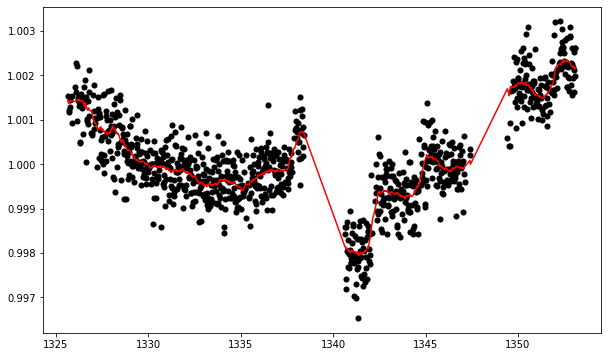

sector 4
4 1411.0107727584152 1436.1358817670339


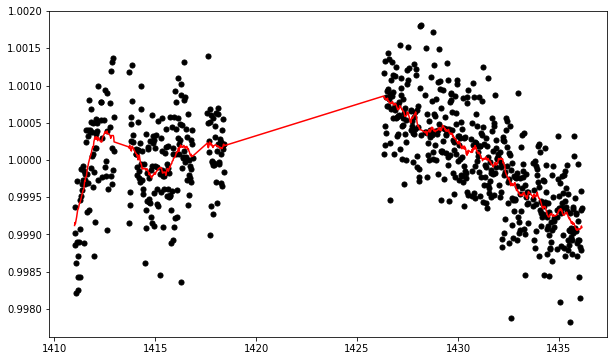

sector 5
5 1438.1358844020313 1463.5526835831745


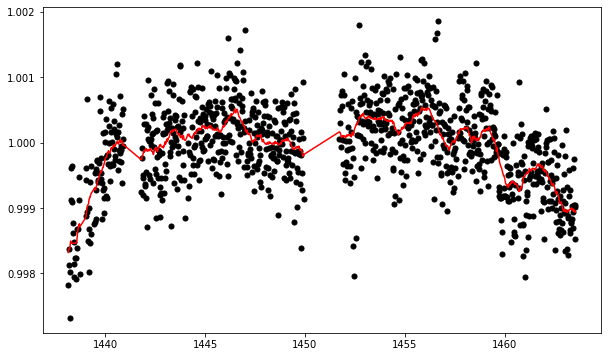

sector 6
6 1468.677709948355 1490.01114400945


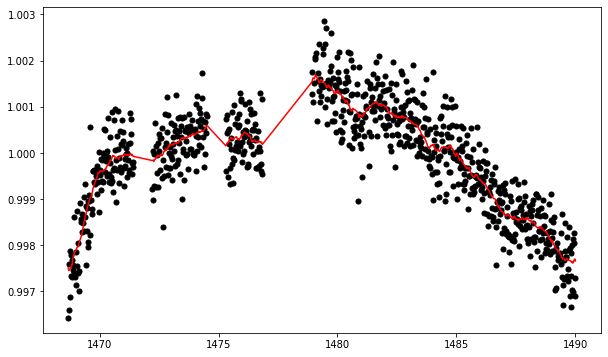

sector 7
7 1491.6569580563178 1516.0320439821003


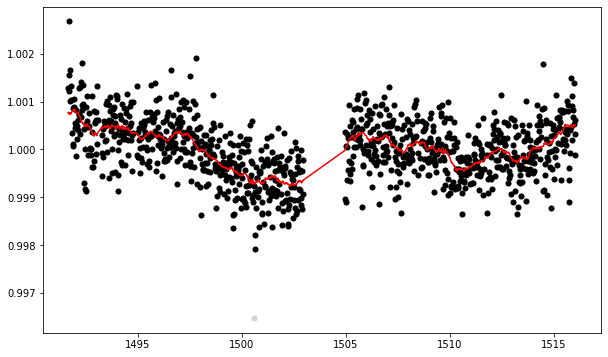

sector 8
8 1517.7403770673707 1541.948745913315


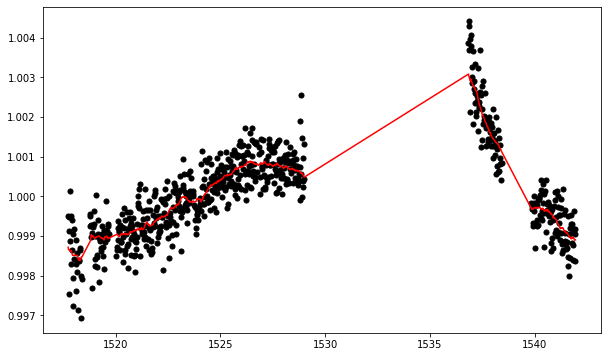

sector 9
9 1545.0737445298619 1568.4070521517647


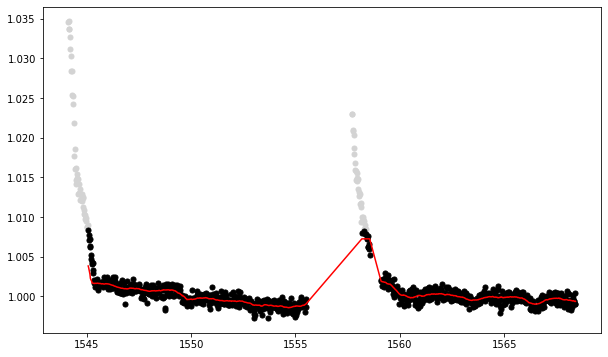

sector 10
10 1570.7195449585747 1595.6361304082347


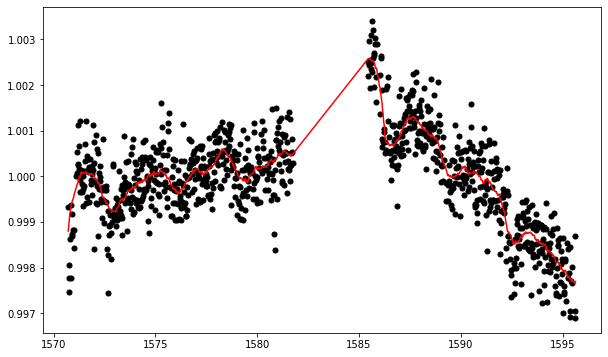

sector 11
11 1598.3027839447373 1623.8651595336169


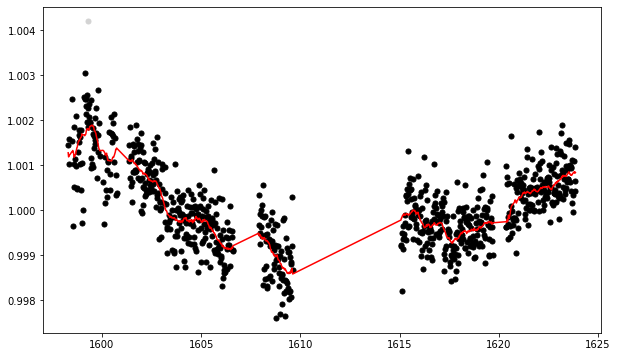

sector 13
13 1654.5941517207218 1682.3231809380127


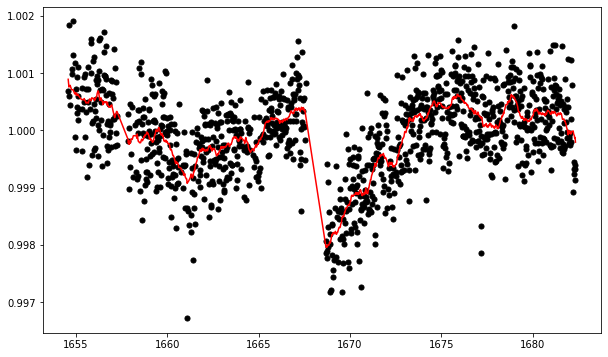

sector 27
27 2036.2952979697252 2059.802141410087


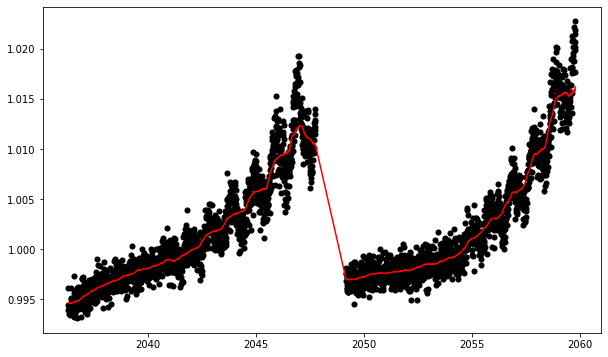

sector 28
28 2061.92018757813 2084.7881878100898


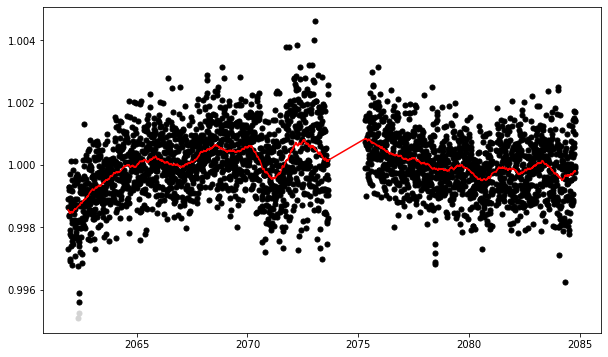

sector 30
30 2115.968731067753 2140.975731898308


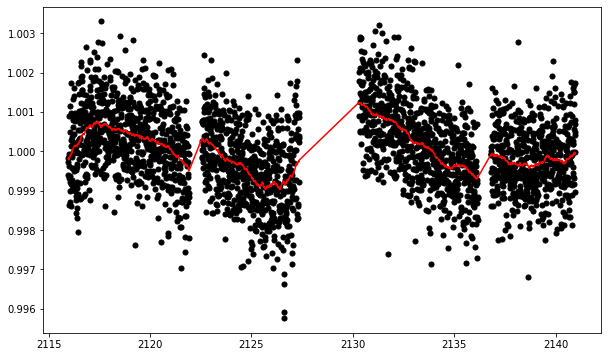

sector 31
31 2144.6285188127945 2169.7952896836186


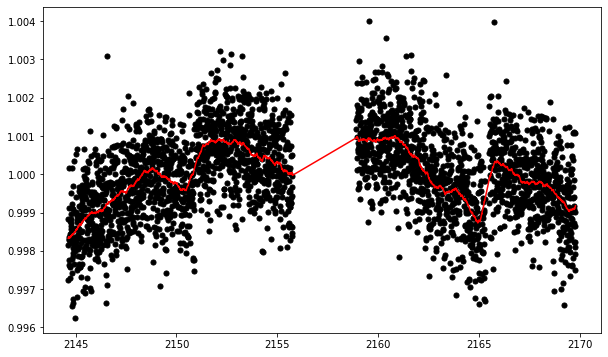

sector 33
33 2201.8023865460596 2227.5386083344138


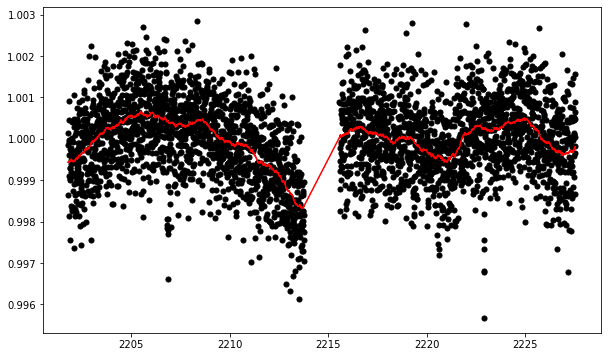

sector 34
34 2229.170560412261 2253.9900726877177


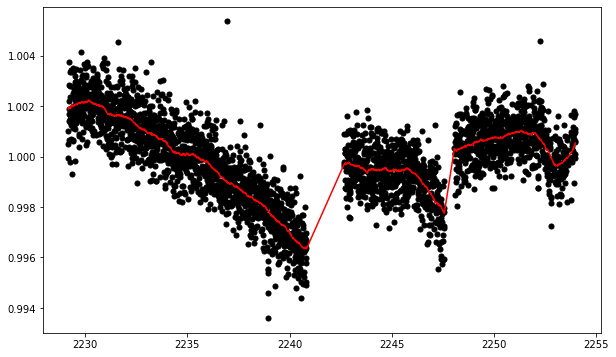

sector 35
35 2256.3234137646923 2279.9137017655553


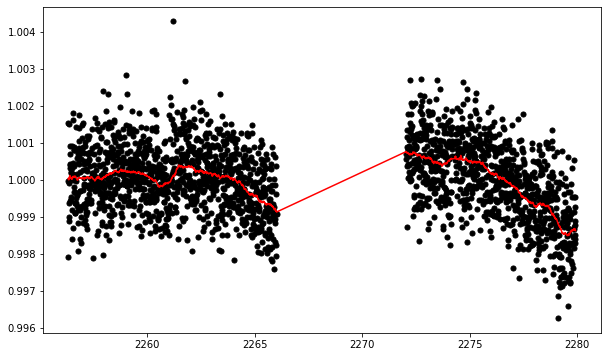

sector 36
36 2282.851204645049 2305.045606656033


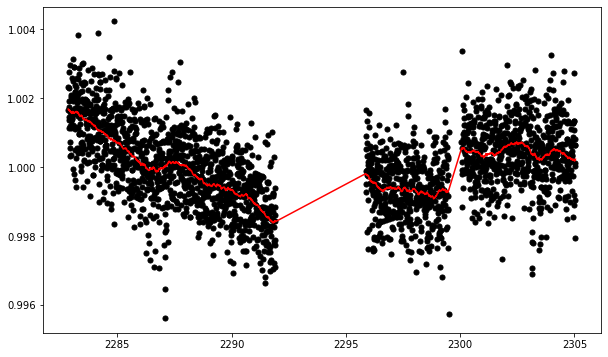

sector 37
37 2308.941432369123 2332.3996703221337


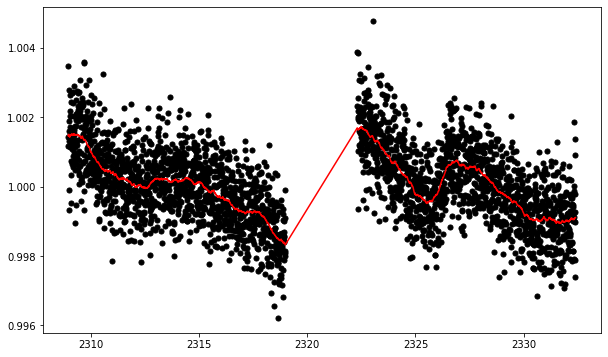

sector 38
38 2335.6635489595355 2360.385636693525


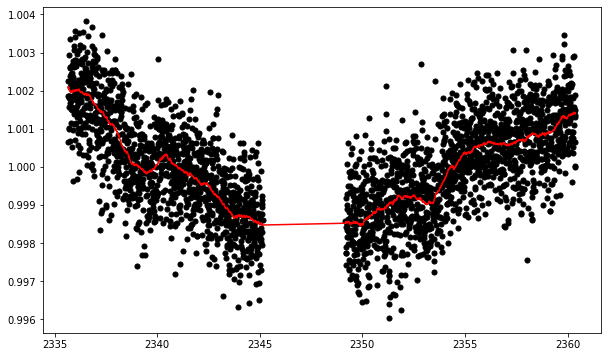

running periodic search
number of frequencies:  212706
return autoperiod [  1.           1.00000467   1.00000934 ... 149.76157649 149.866391
 149.97135232]
results            depth: array([9.07670452e-05, 9.07670452e-05, 8.94984964e-05, ...,
       1.65341041e-03, 1.74019234e-03, 1.68048540e-03])
      depth_err: array([0.0106693 , 0.0106693 , 0.01060289, ..., 0.13493755, 0.14151438,
       0.13745635])
      depth_snr: array([0.00850731, 0.00850731, 0.00844095, ..., 0.01225315, 0.01229693,
       0.01222559])
       duration: array([0.36, 0.36, 0.37, ..., 0.29, 0.27, 0.28])
 log_likelihood: array([5.67066727e-05, 5.67066727e-05, 5.67987742e-05, ...,
       7.51785644e-05, 7.57067344e-05, 7.48368264e-05])
      objective: 'snr'
         period: array([  1.        ,   1.00000467,   1.00000934, ..., 149.76157649,
       149.866391  , 149.97135232])
          power: array([0.00850731, 0.00850731, 0.00844095, ..., 0.01225315, 0.01229693,
       0.01222559])
    power_final: array([-0.00098

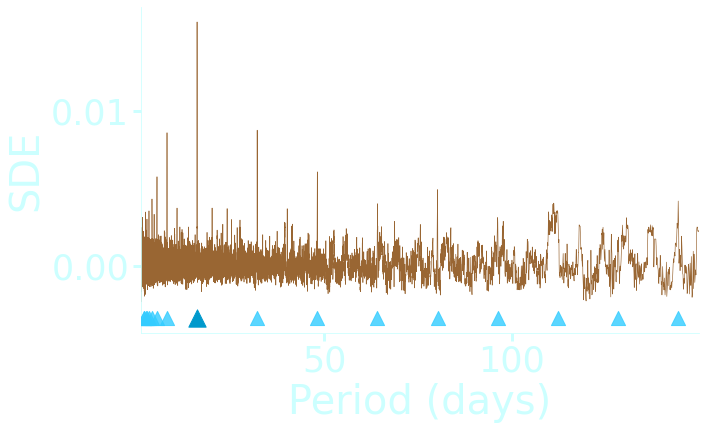

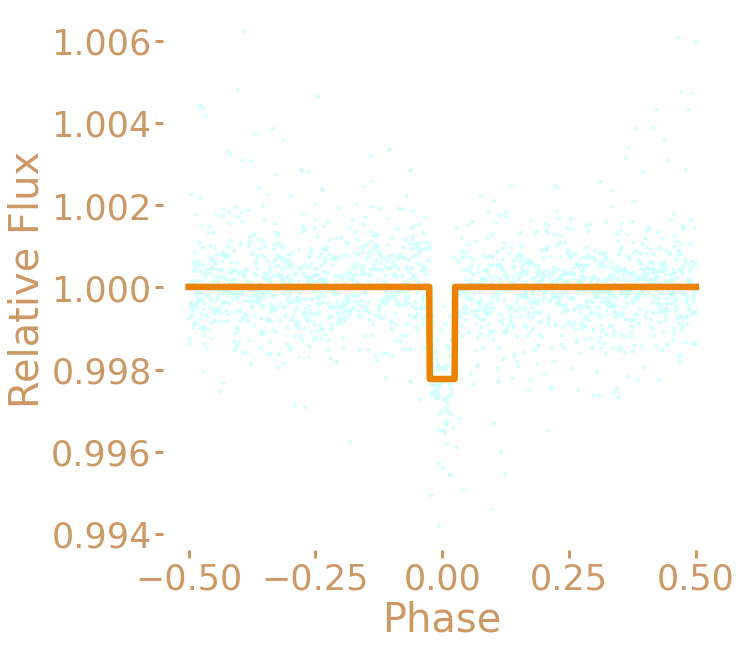

T0:  1340.0966266185208 duration:  0.05 npoints_dur:  1.0
number of frequencies:  212706
return autoperiod [  1.           1.00000467   1.00000934 ... 149.76157649 149.866391
 149.97135232]
results            depth: array([8.93745502e-05, 8.93745502e-05, 8.86304847e-05, ...,
       1.61013596e-03, 1.73558169e-03, 1.73341893e-03])
      depth_err: array([0.01071613, 0.01071613, 0.01064915, ..., 0.19618375, 0.2000663 ,
       0.2000663 ])
      depth_snr: array([0.00834019, 0.00834019, 0.00832278, ..., 0.00820729, 0.00867503,
       0.00866422])
       duration: array([0.36 , 0.36 , 0.37 , ..., 0.135, 0.14 , 0.14 ])
 log_likelihood: array([5.44688780e-05, 5.44688780e-05, 5.51878514e-05, ...,
       3.37029917e-05, 3.76530476e-05, 3.75592647e-05])
      objective: 'snr'
         period: array([  1.        ,   1.00000467,   1.00000934, ..., 149.76157649,
       149.866391  , 149.97135232])
          power: array([0.00834019, 0.00834019, 0.00832278, ..., 0.00820729, 0.00867503,
       0.008

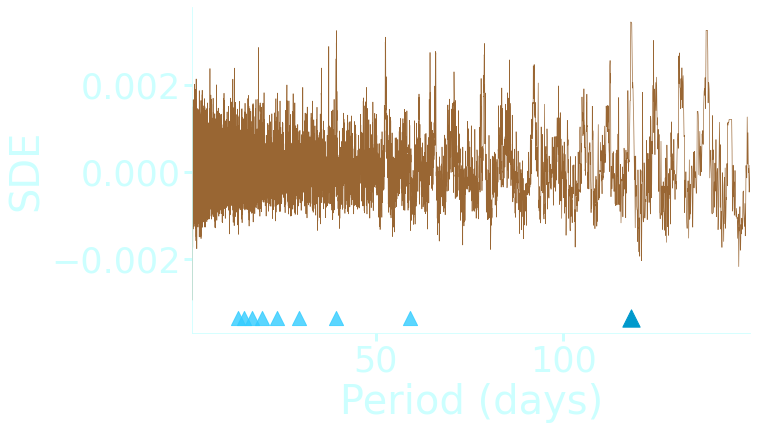

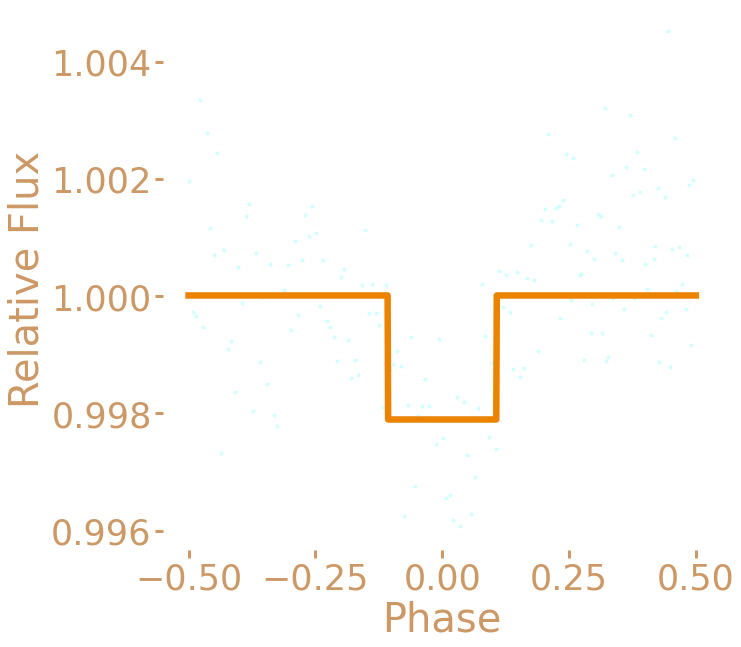

T0:  1349.1041266185207 duration:  0.215 npoints_dur:  1.0
done with multis!
per [16.050943411283065]
running single transit search
running single transit search
u,  [0.1604 0.4325]
24
T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan 

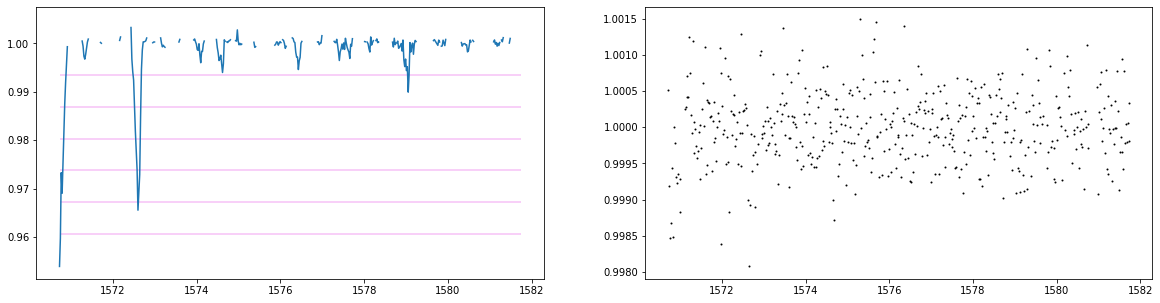

T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


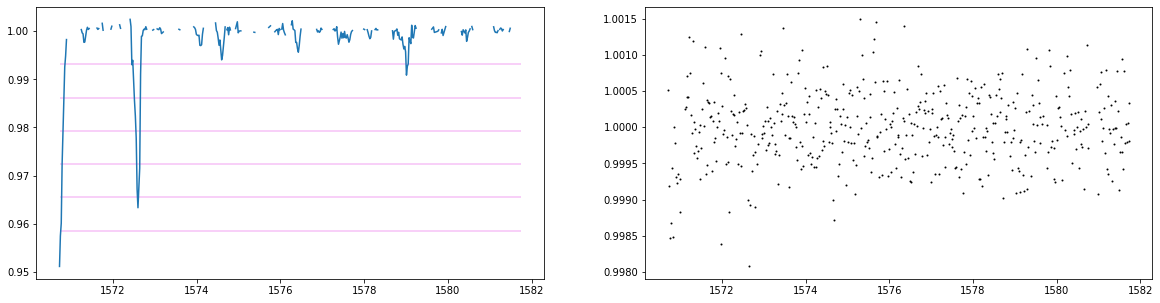

T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan 

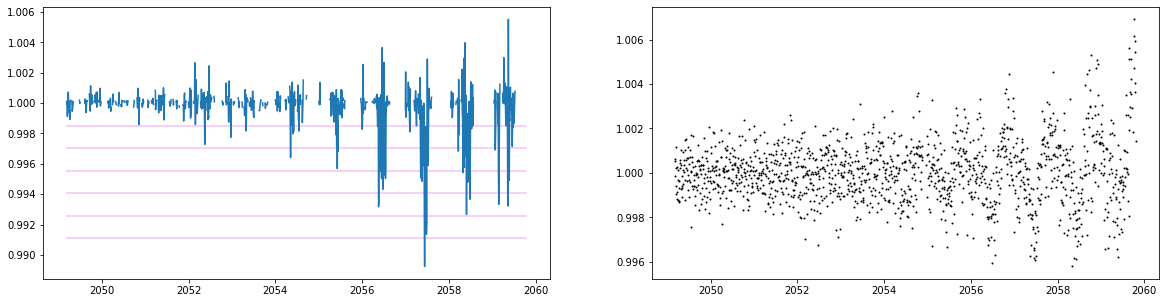

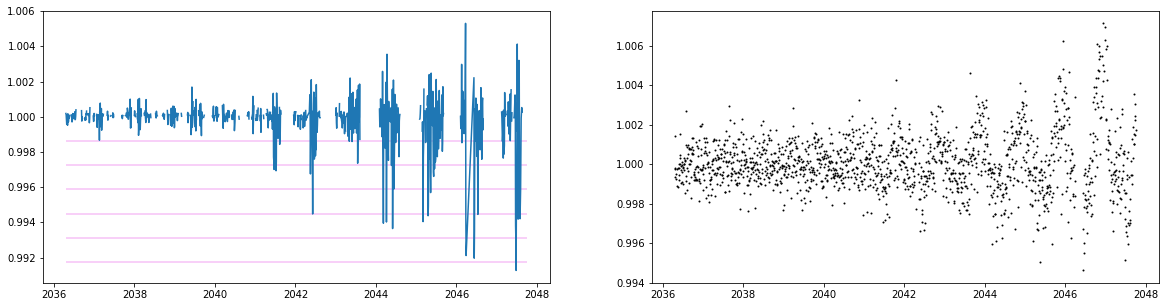

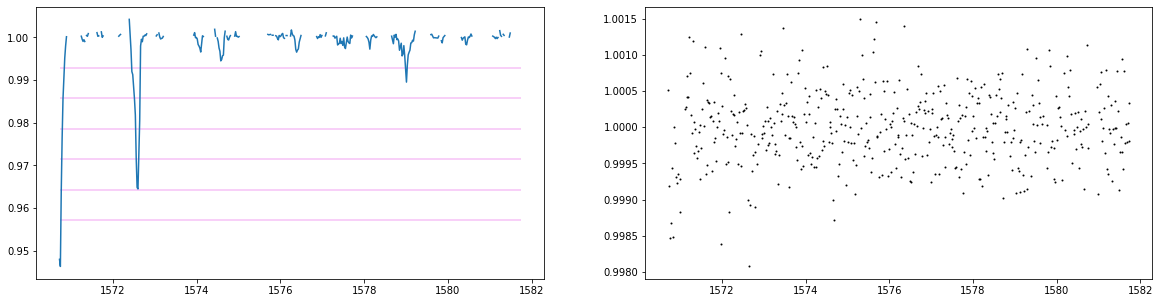

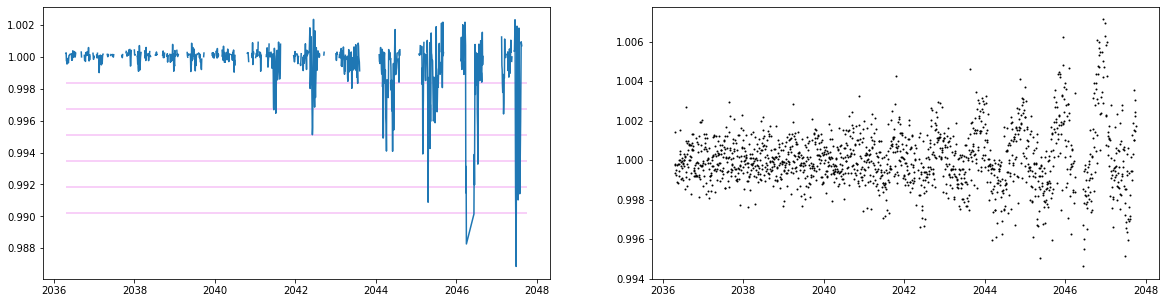

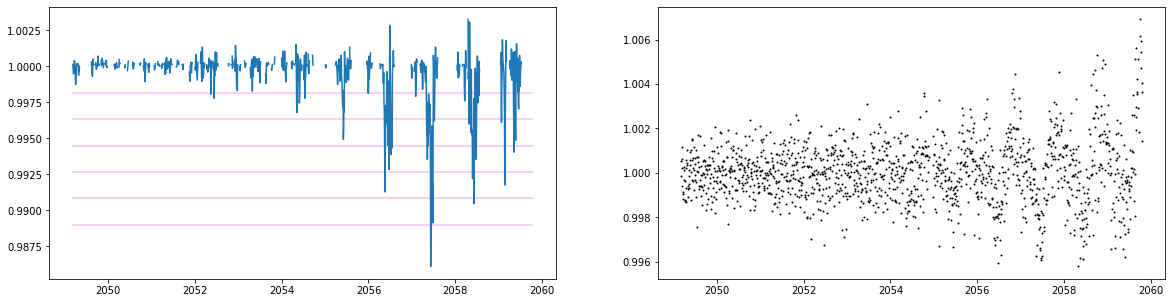

T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


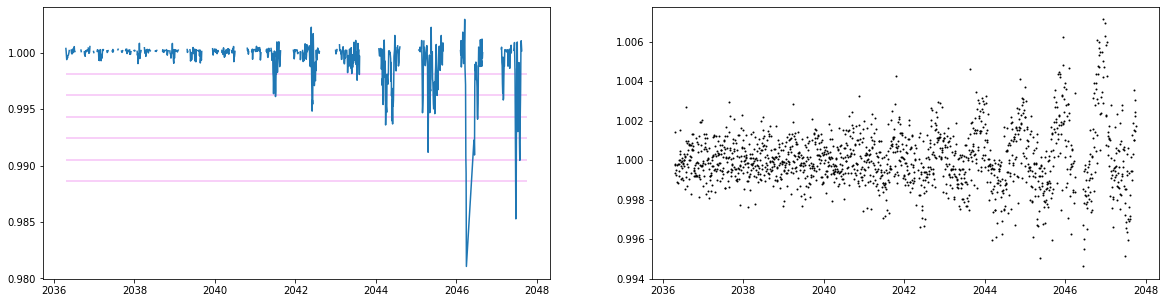

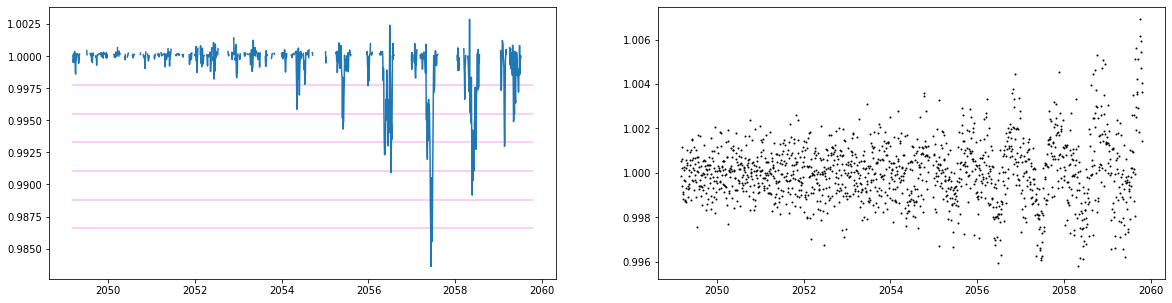

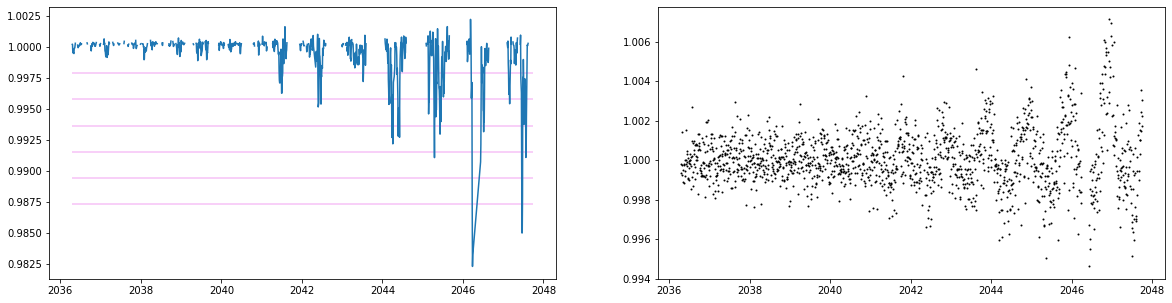

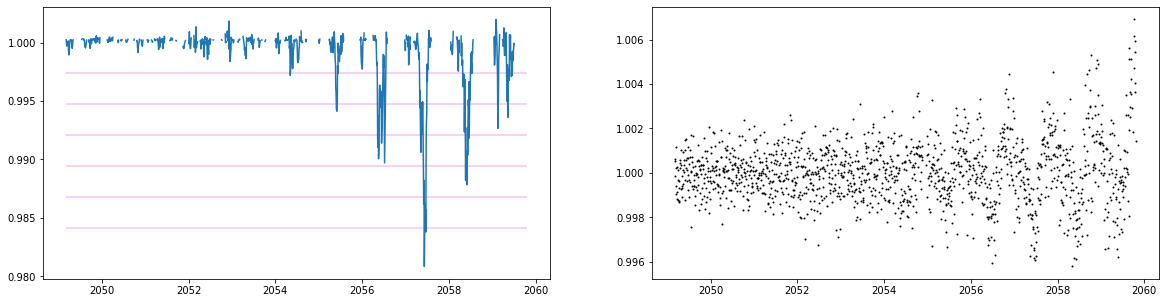

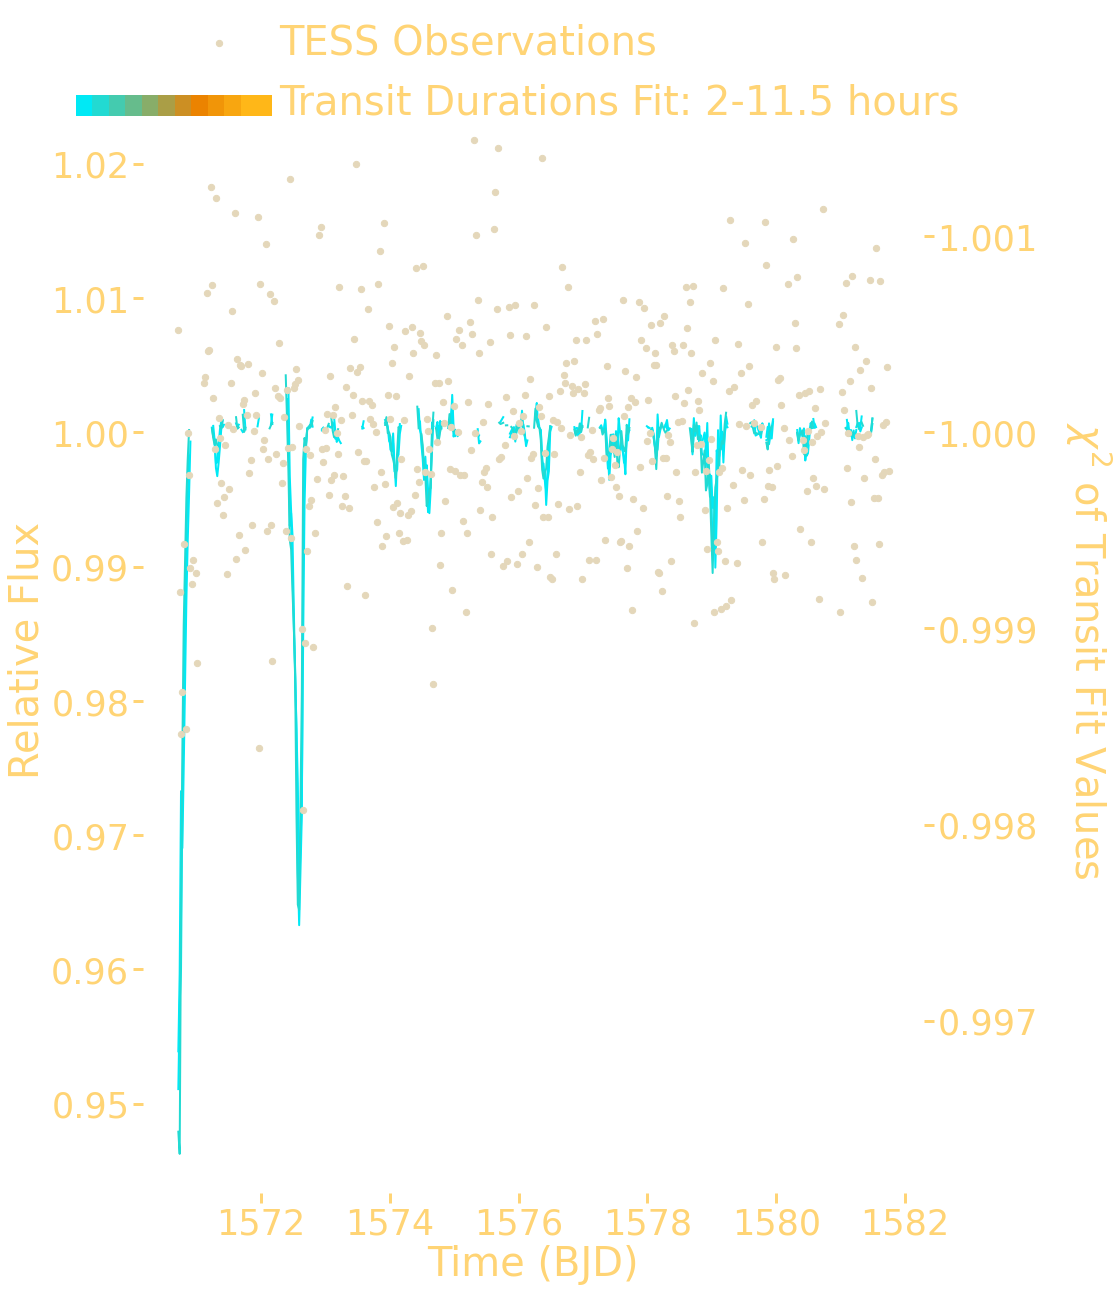

T0_start [ 1.  3. 84. nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


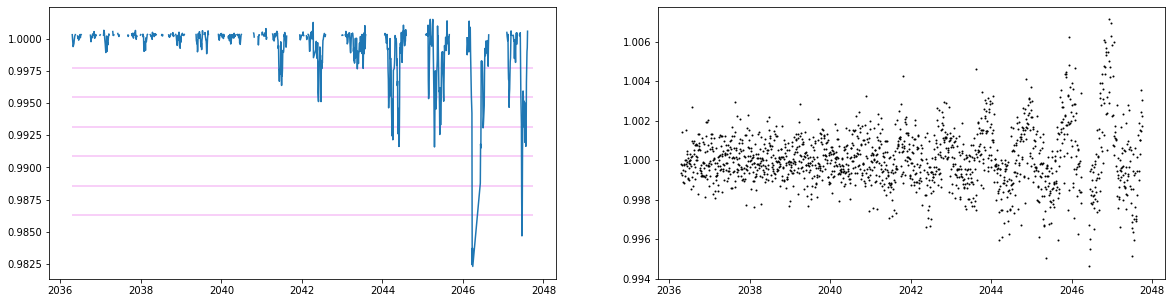

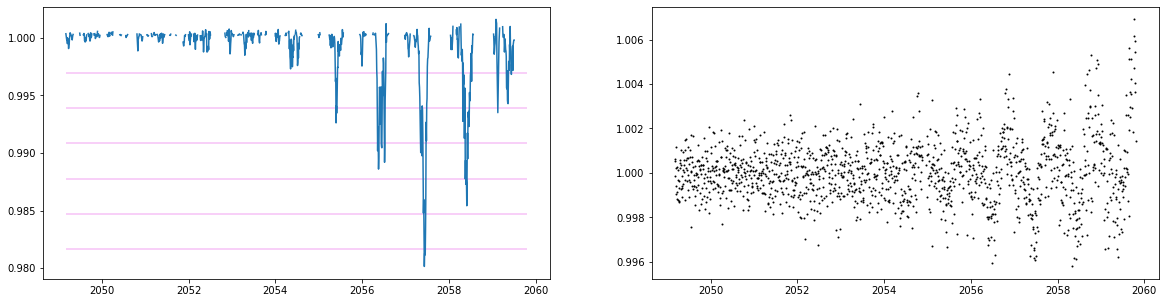

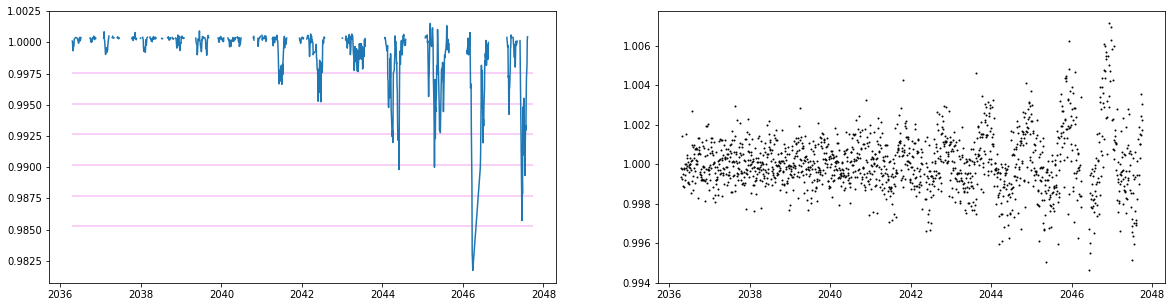

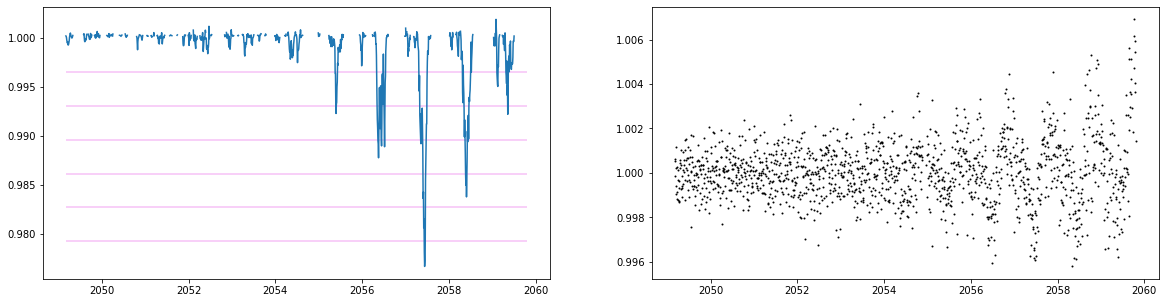

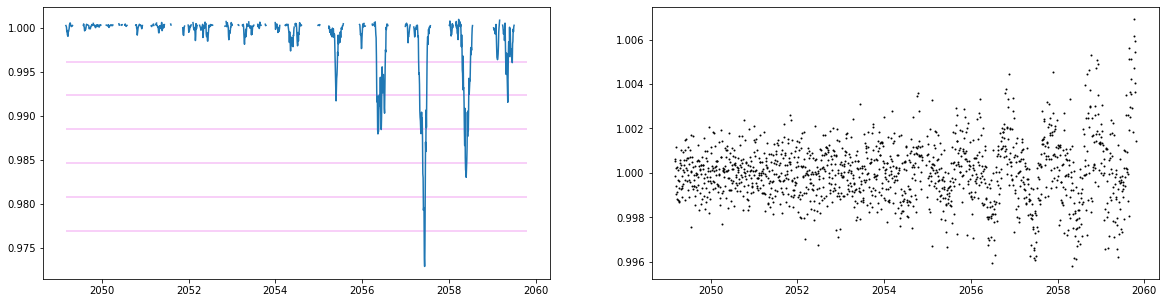

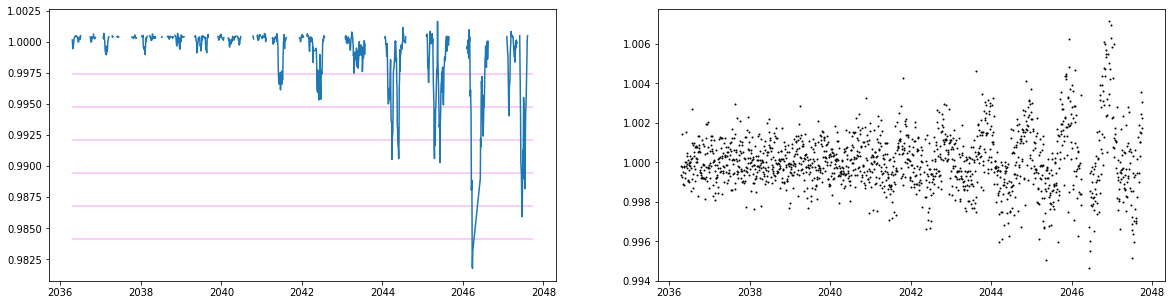

T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


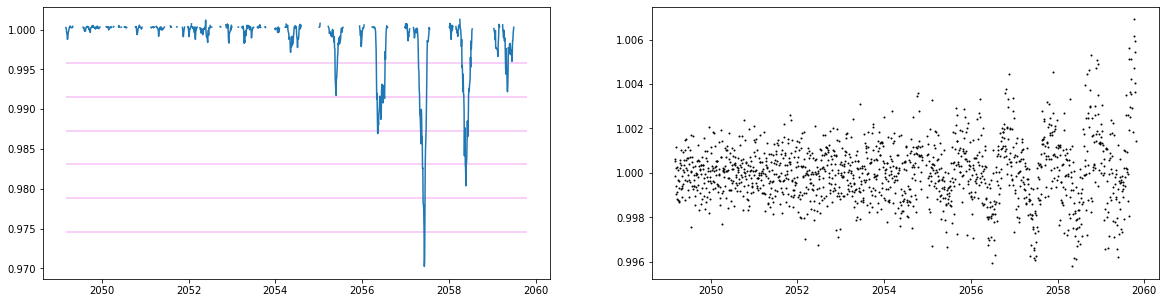

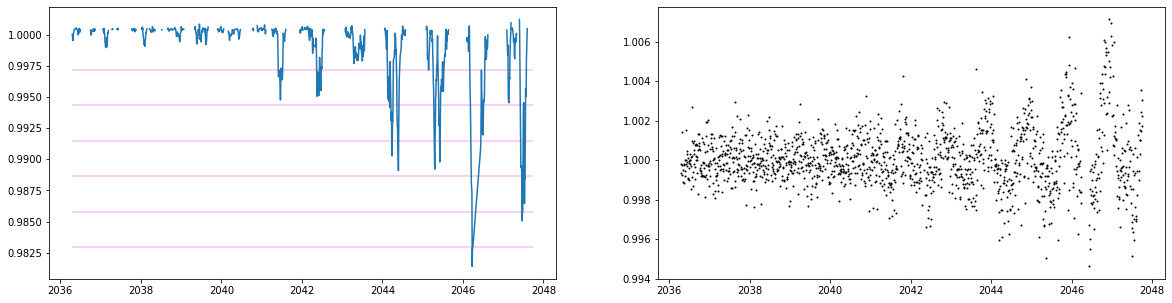

T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


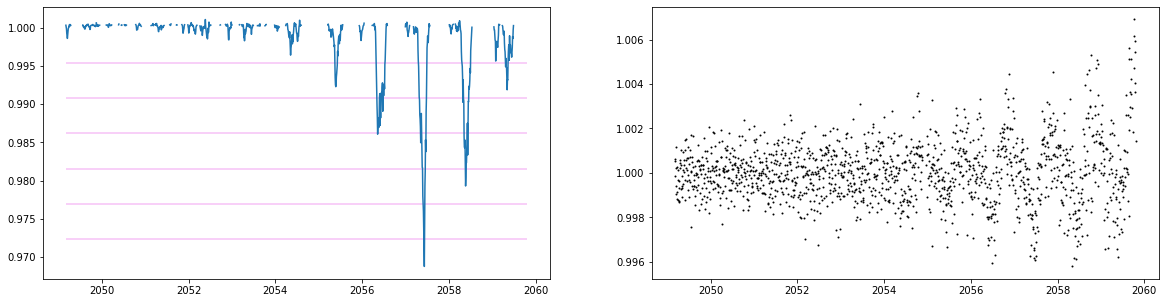

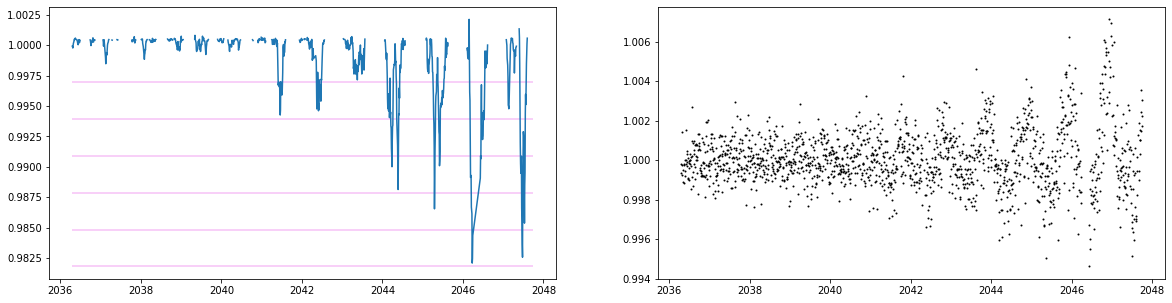

T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


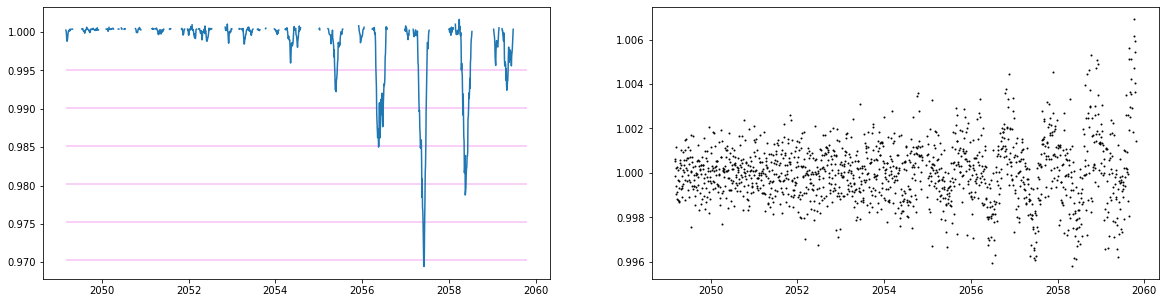

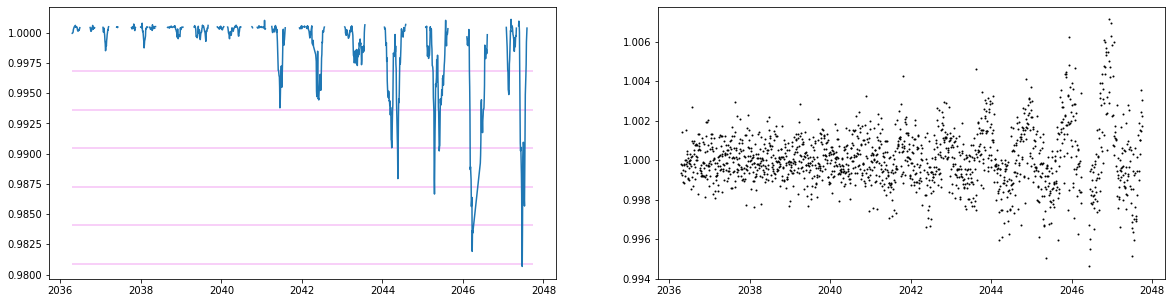

T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


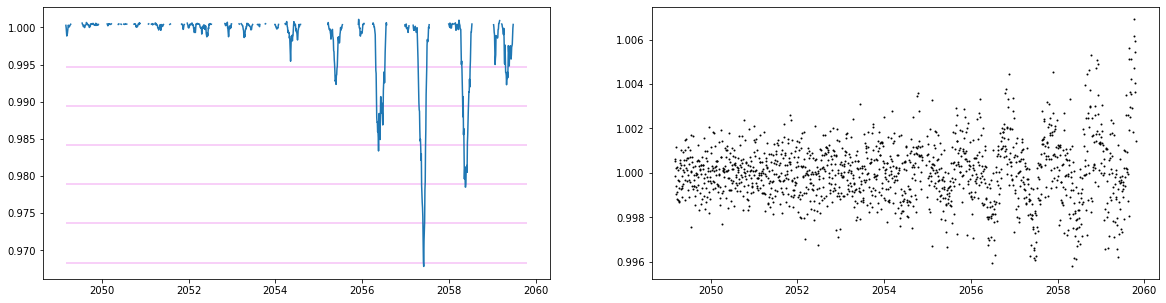

T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


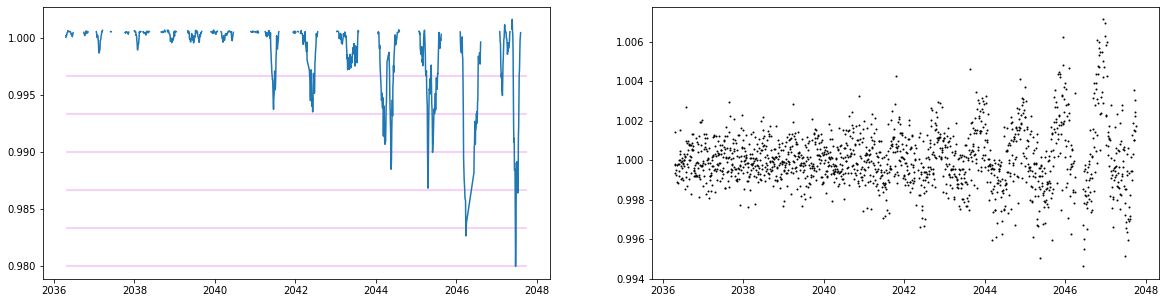

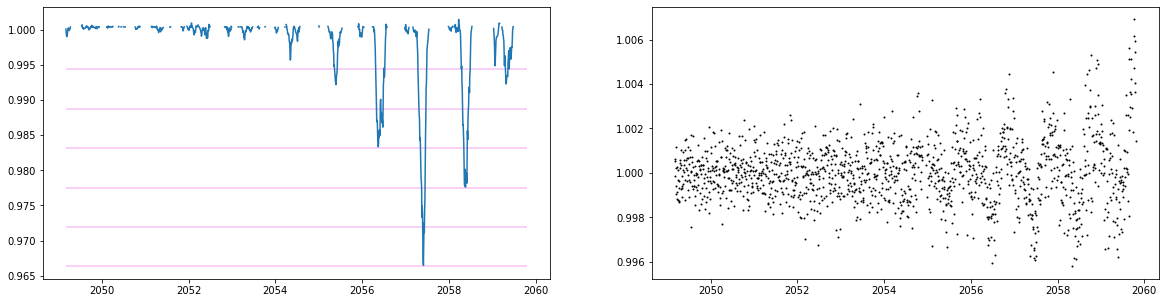

T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


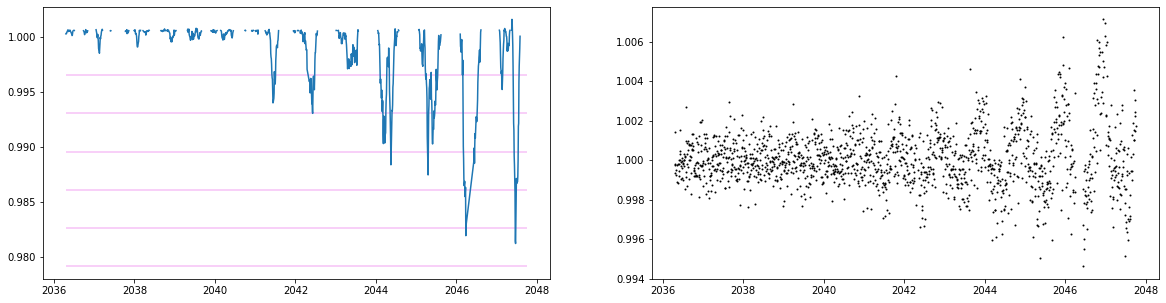

T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


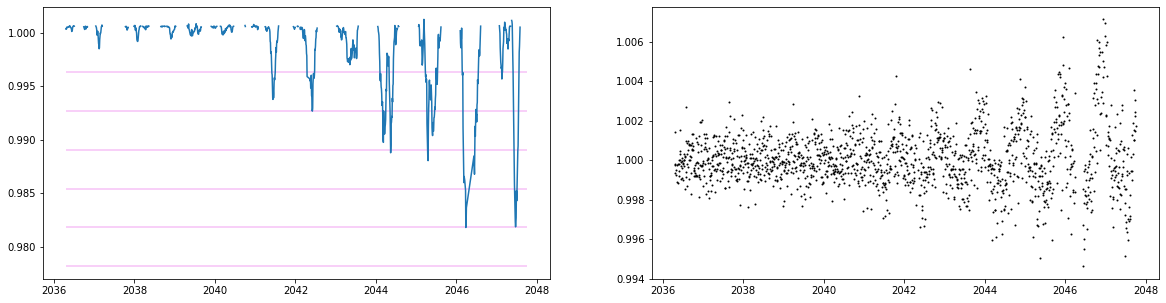

T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


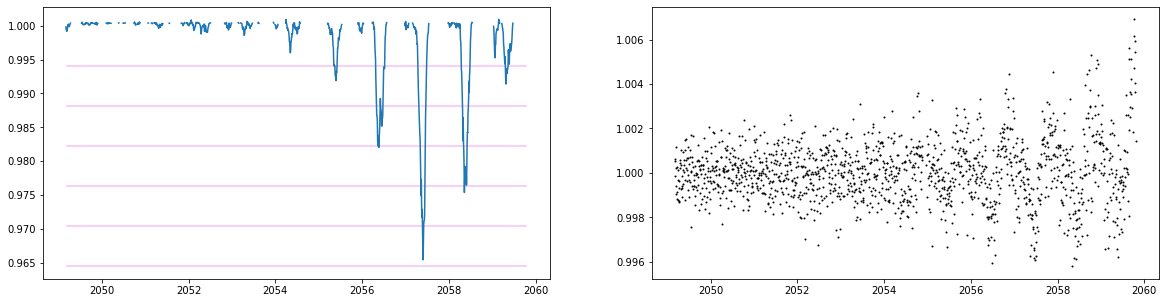

T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


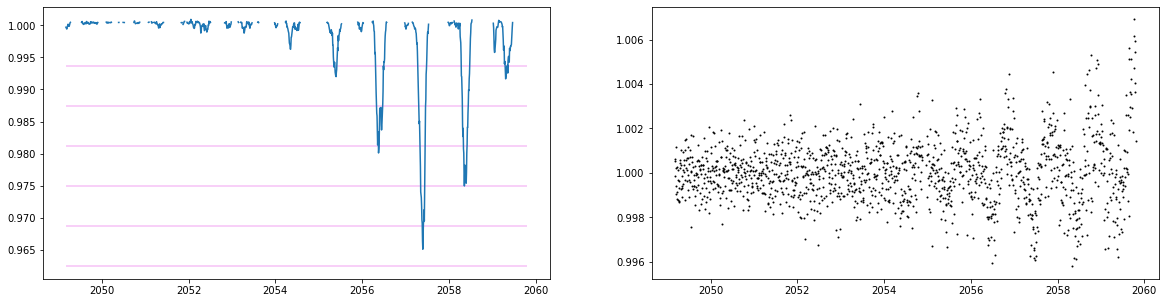

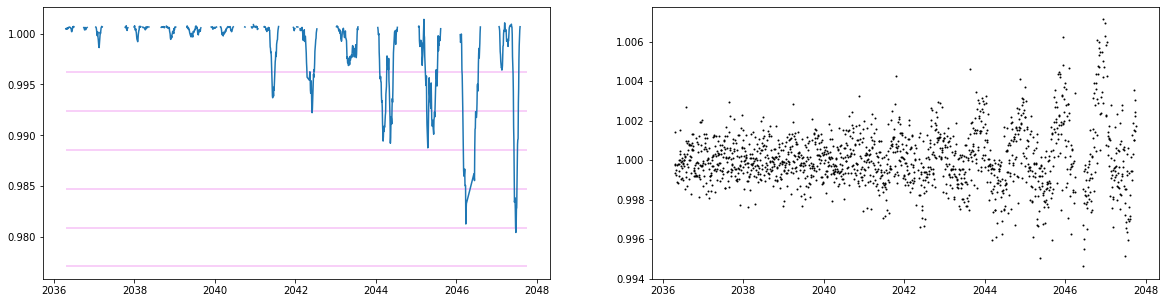

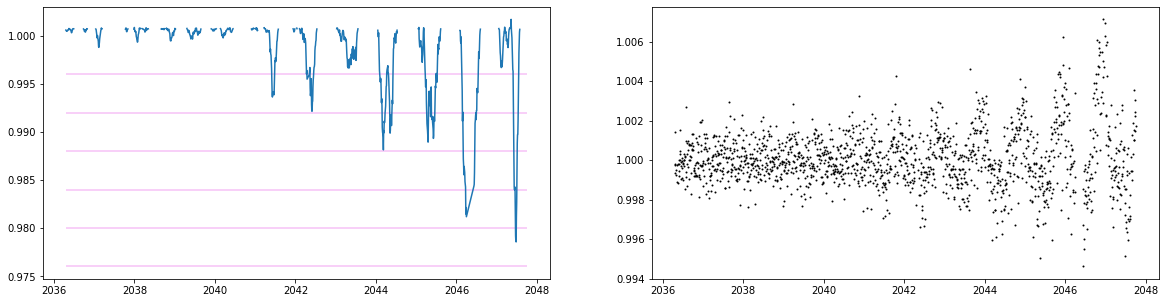

T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


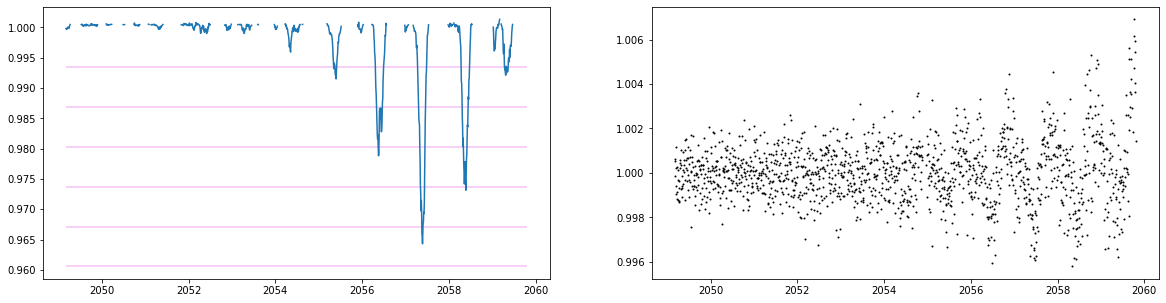

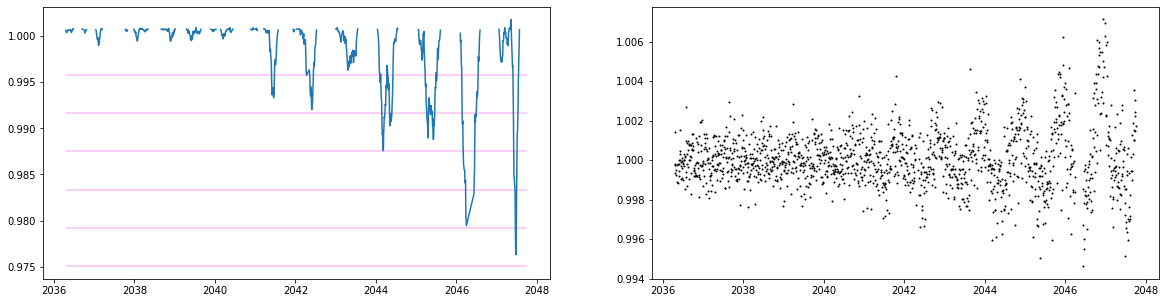

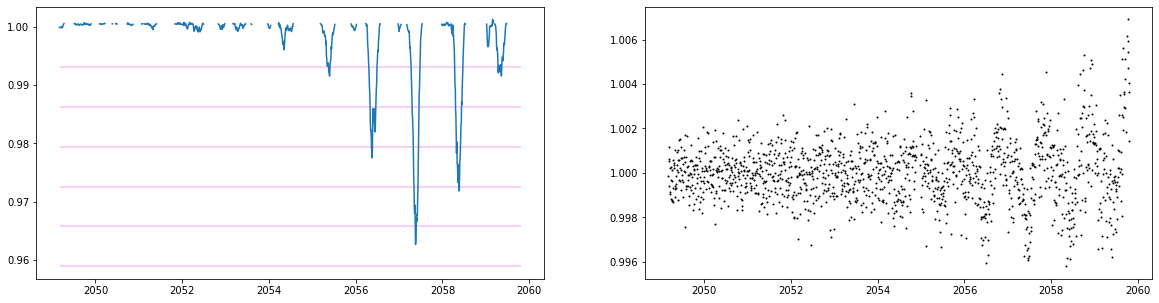

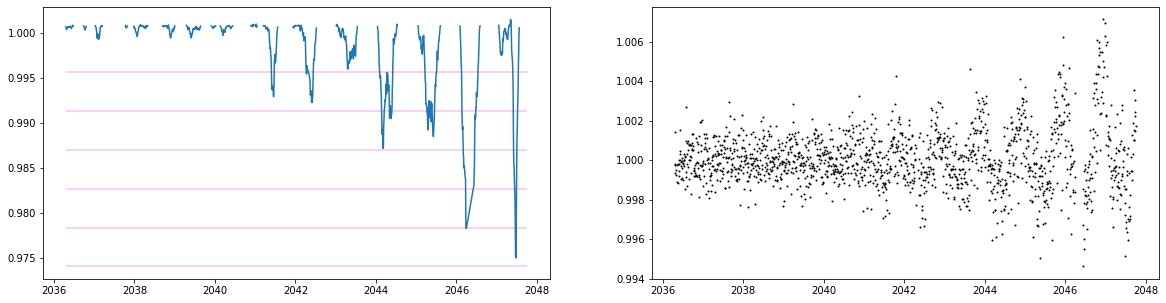

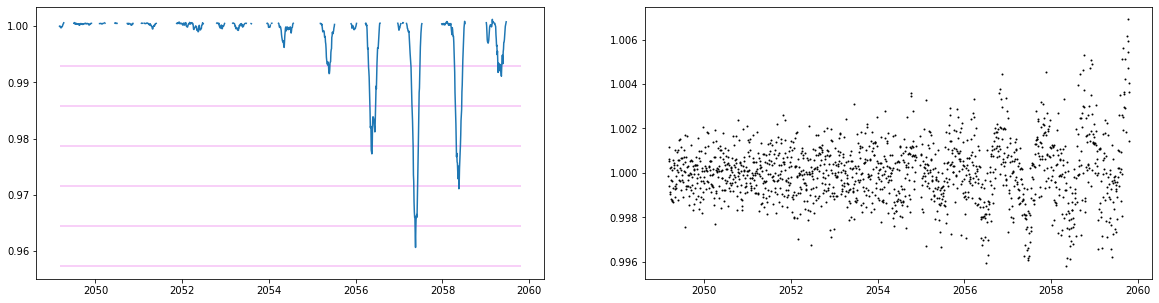

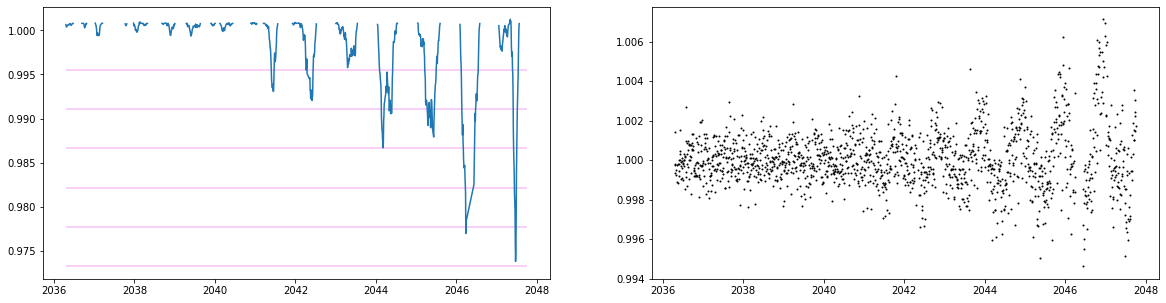

T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan 

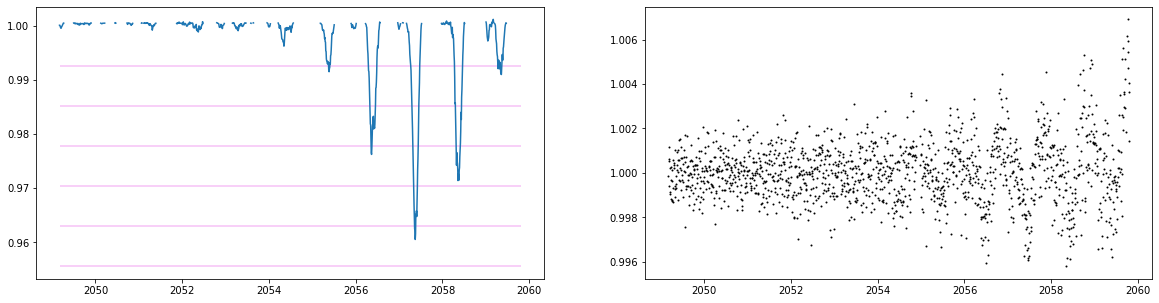

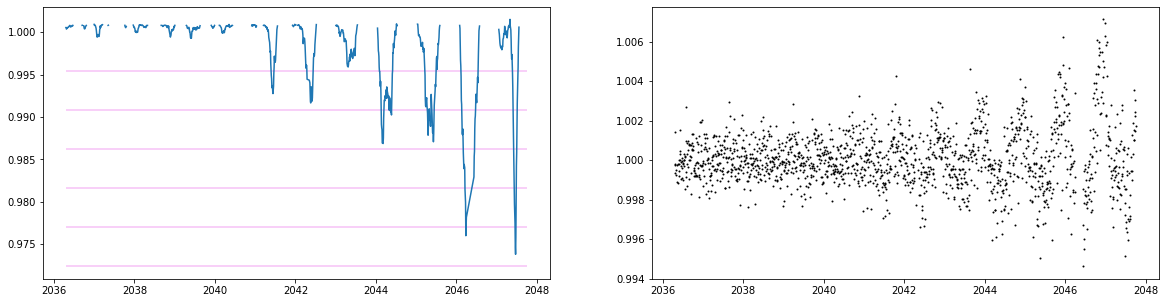

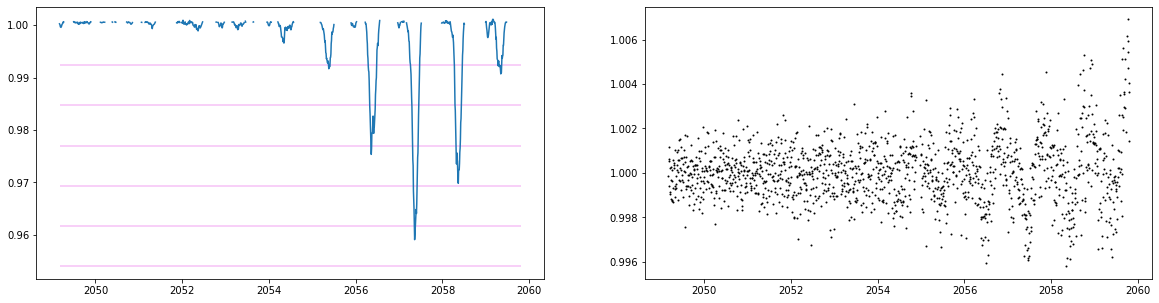

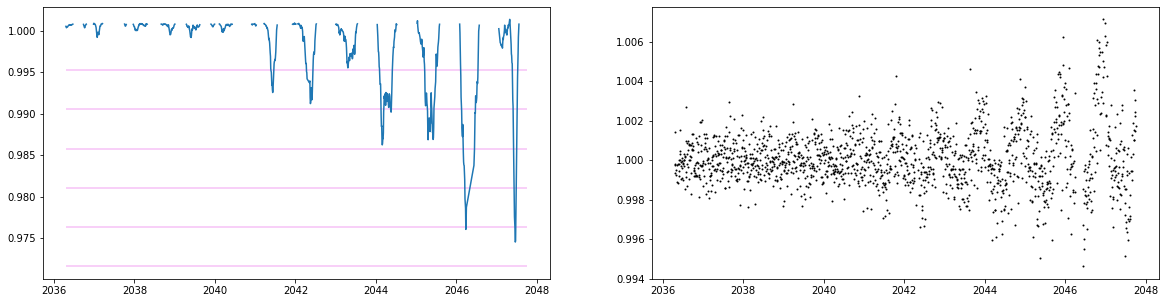

T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


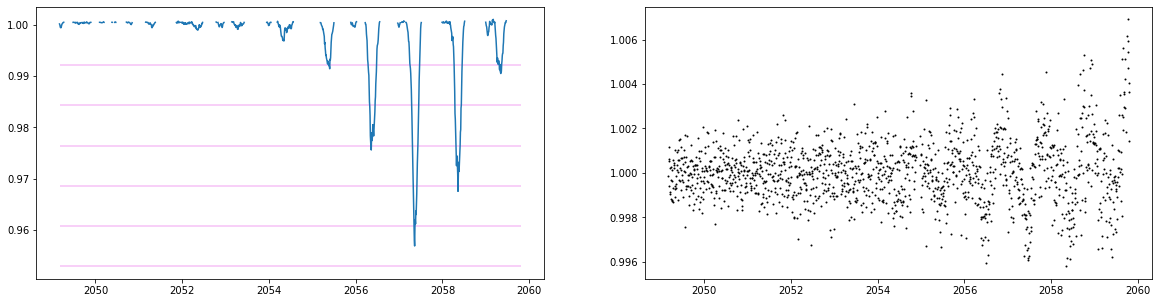

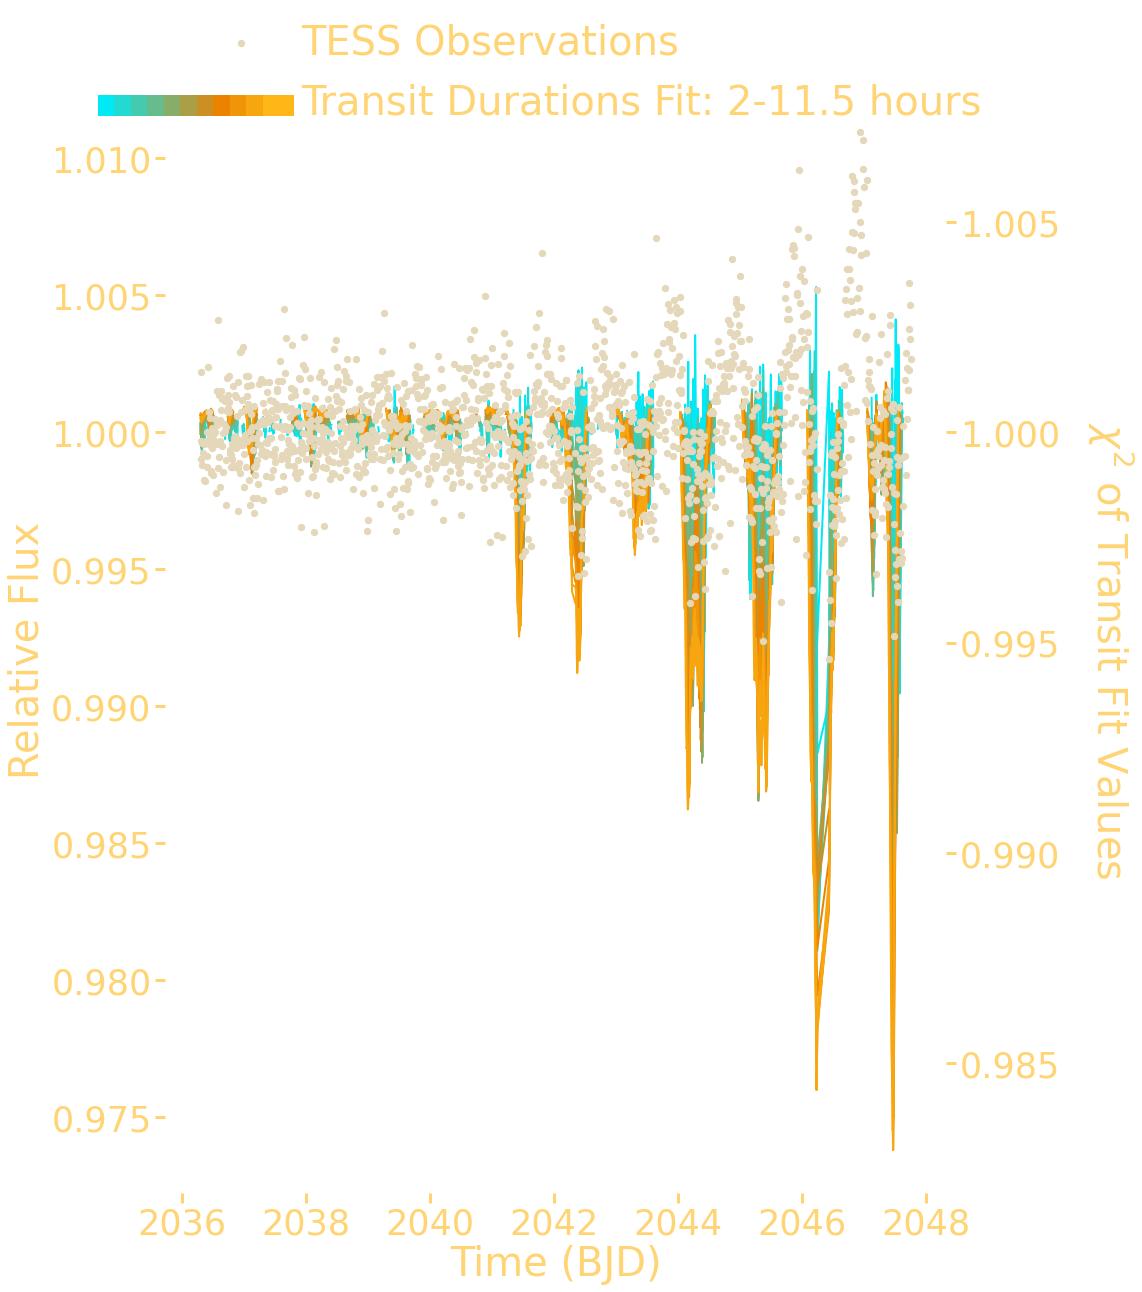

T0_start [1552. 1553. 1410. 1413. 1409. 1411. 1566. 1414. 1412. 1551. 1565. 1550.
 1407. 1408. 1560. 1562. 1555. 1548. 1554. 1549.   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan]
break [ 0  8 16 18 19]
break [ 0  8 16 18 19]
best residuals result [0.97598488 0.97379344 0.98536945        nan]


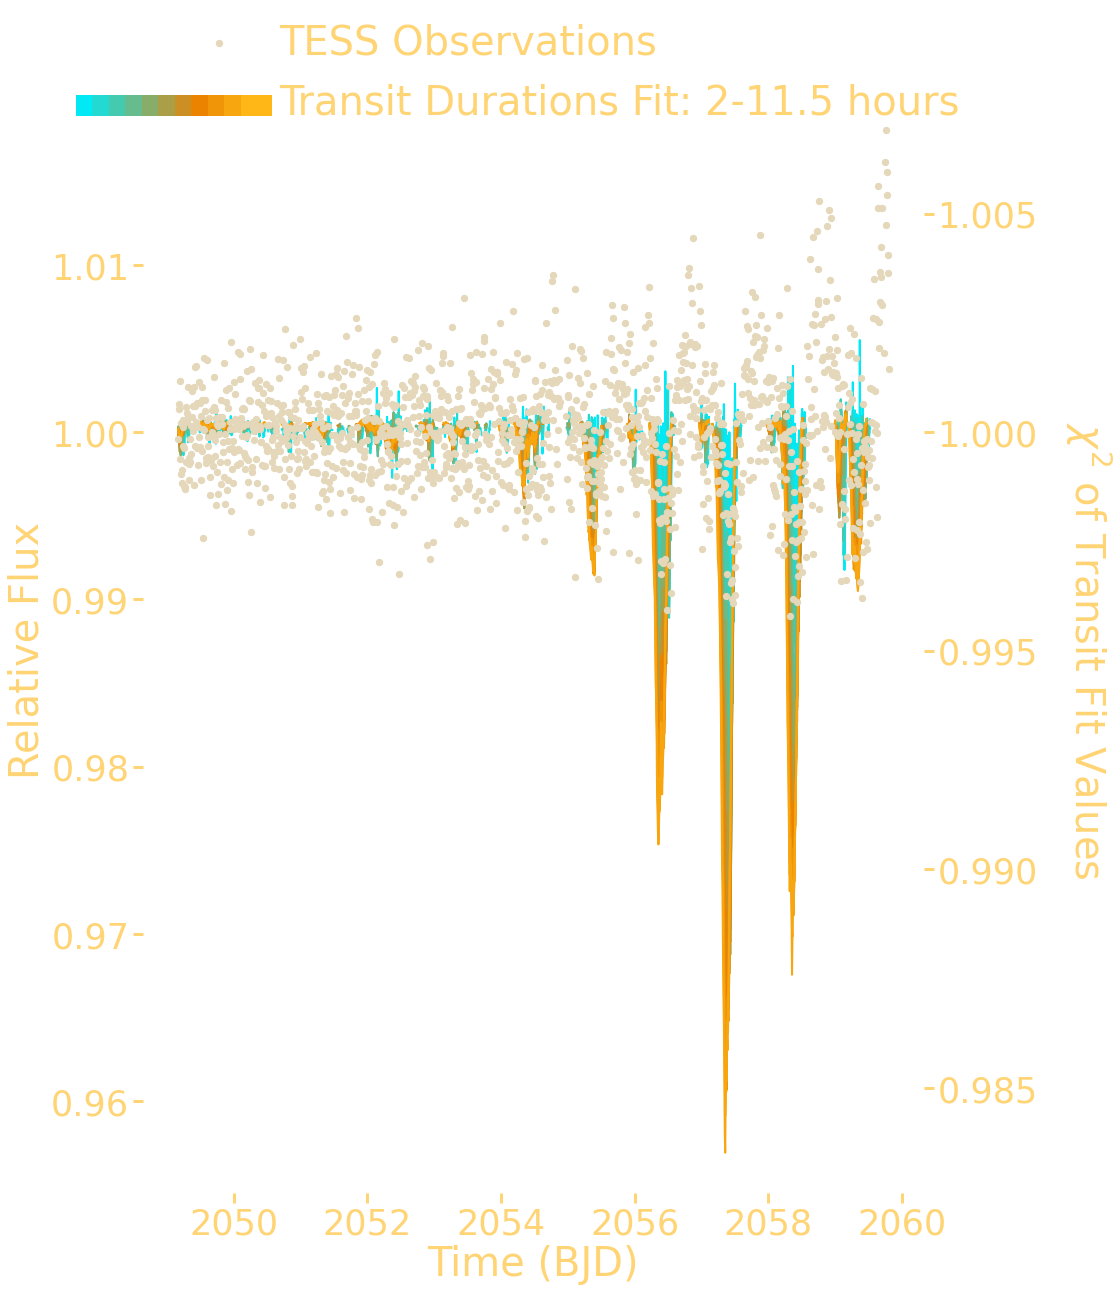

T0_start [1179. 1020. 1173. 1172. 1174. 1177. 1312. 1176. 1313. 1170. 1175. 1311.
 1169. 1171. 1168. 1309. 1310. 1166. 1308. 1167. 1307. 1164. 1165. 1161.
 1162. 1163. 1160. 1159. 1158.   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan]
break [ 0  1 22 28]
break [ 0  1 22 28]
best residuals result [0.97744974 0.95691758 0.9711032 ]
periodic singles 0
checking singles T0
t0:  1570.969544944796553 , tdur:  5.5  hours
lenghs 1 38043 38043
t0:  2046.6702534432201901 , tdur:  10.5  hours
lenghs 1 38043 38043
t0:  2047.9063566690954303 , tdur:  10.5  hours
lenghs 1 38043 38043
t0:  2047.7605229125313144 , tdur:  5.5 

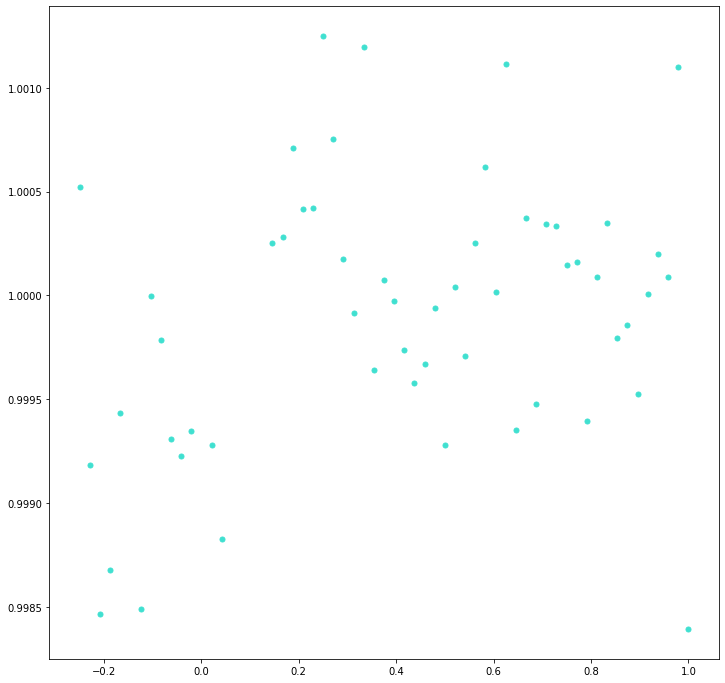

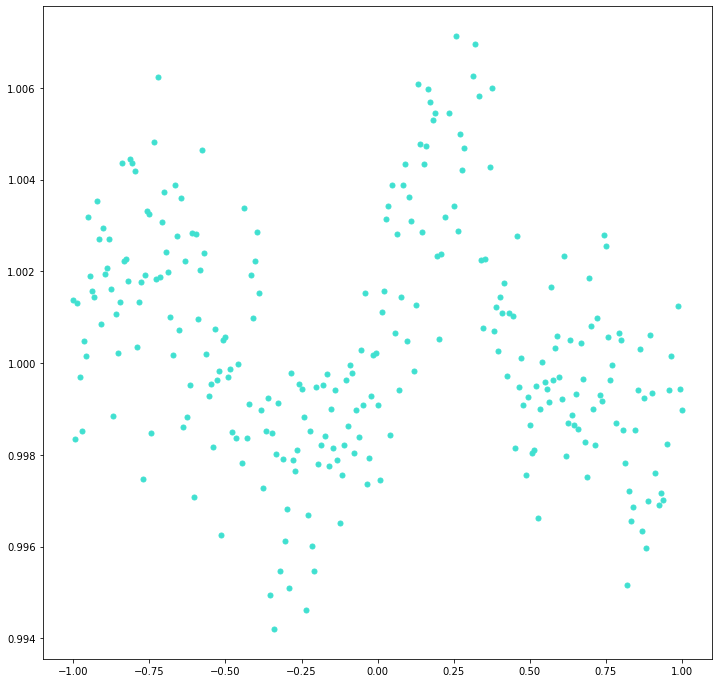

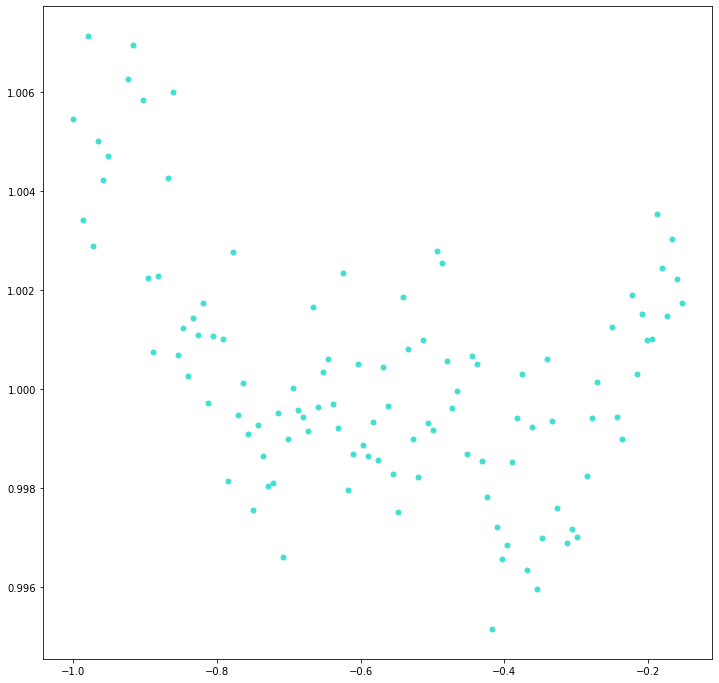

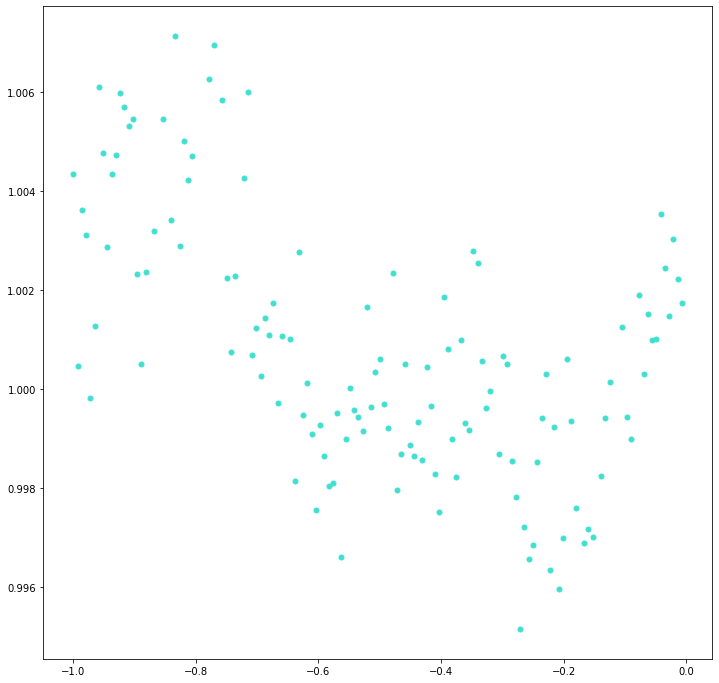

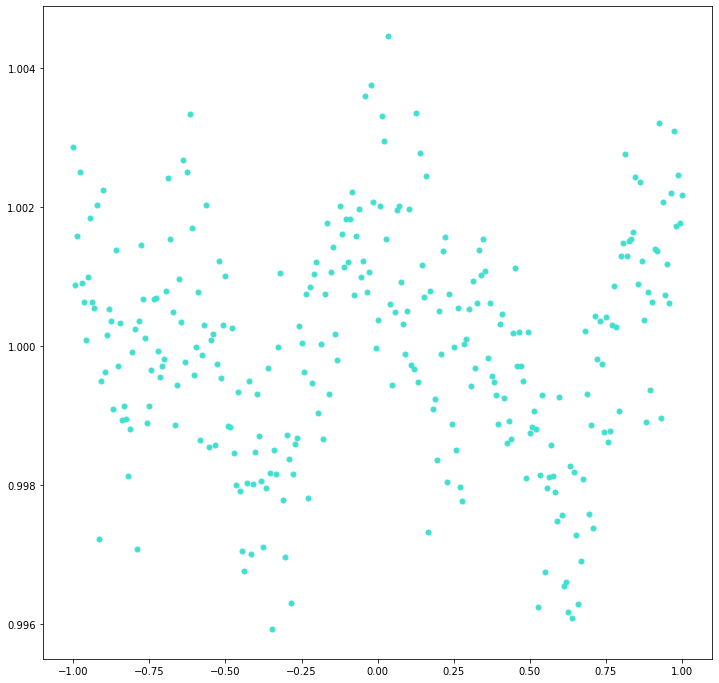

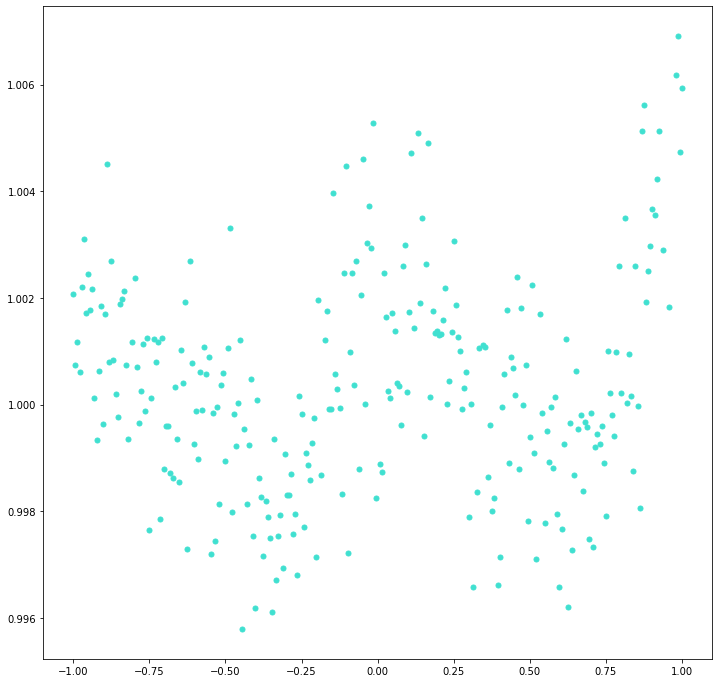

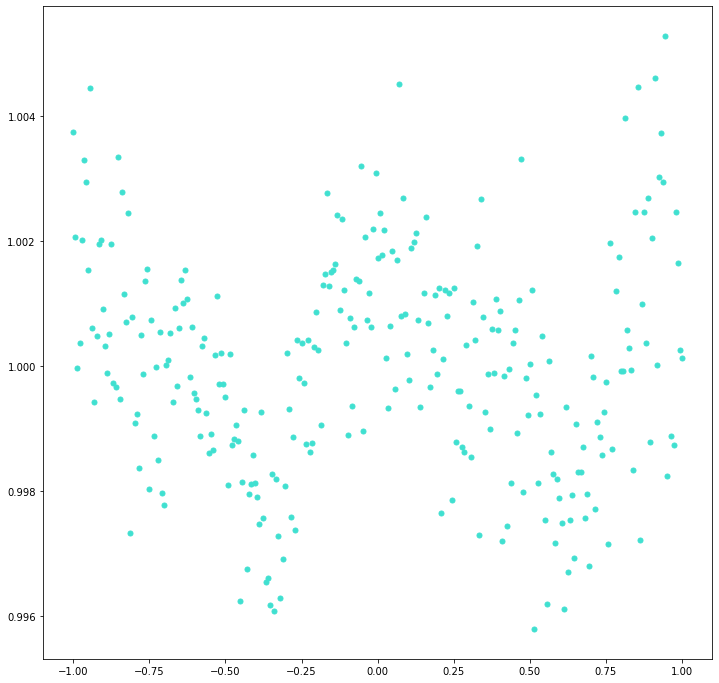

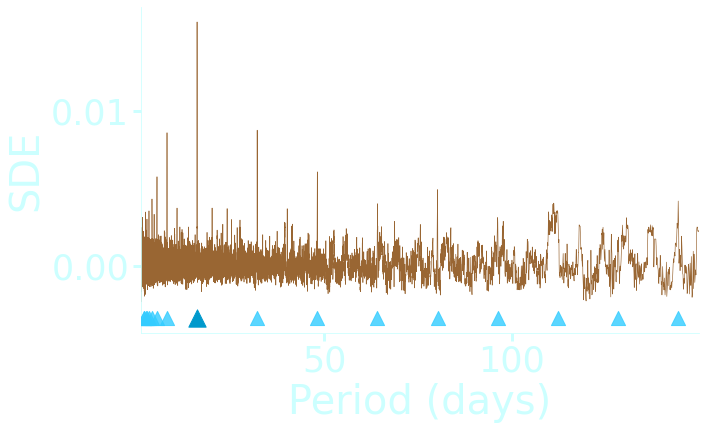

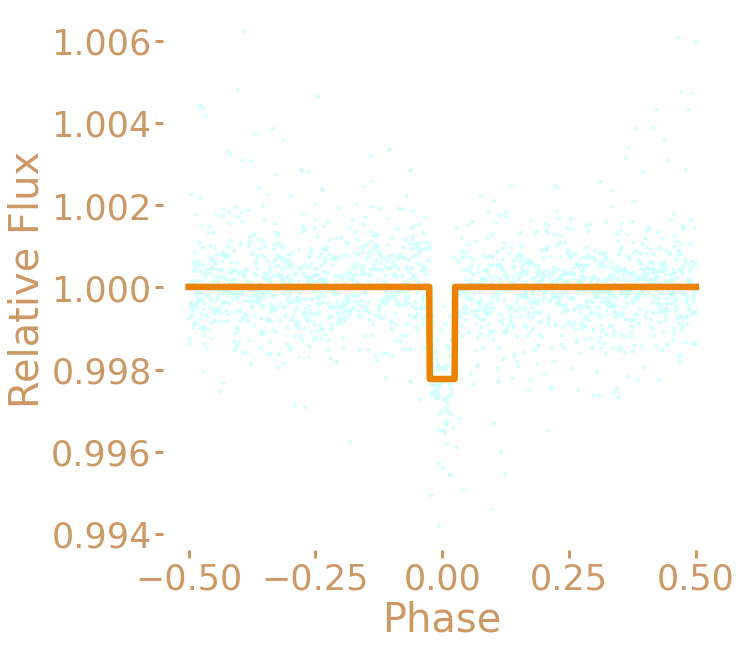

T0:  1340.0966266185208 duration:  0.05 npoints_dur:  1.0
number of frequencies:  212706
return autoperiod [  1.           1.00000467   1.00000934 ... 149.76157649 149.866391
 149.97135232]
results            depth: array([8.93745502e-05, 8.93745502e-05, 8.86304847e-05, ...,
       1.61013596e-03, 1.73558169e-03, 1.73341893e-03])
      depth_err: array([0.01071613, 0.01071613, 0.01064915, ..., 0.19618375, 0.2000663 ,
       0.2000663 ])
      depth_snr: array([0.00834019, 0.00834019, 0.00832278, ..., 0.00820729, 0.00867503,
       0.00866422])
       duration: array([0.36 , 0.36 , 0.37 , ..., 0.135, 0.14 , 0.14 ])
 log_likelihood: array([5.44688780e-05, 5.44688780e-05, 5.51878514e-05, ...,
       3.37029917e-05, 3.76530476e-05, 3.75592647e-05])
      objective: 'snr'
         period: array([  1.        ,   1.00000467,   1.00000934, ..., 149.76157649,
       149.866391  , 149.97135232])
          power: array([0.00834019, 0.00834019, 0.00832278, ..., 0.00820729, 0.00867503,
       0.008

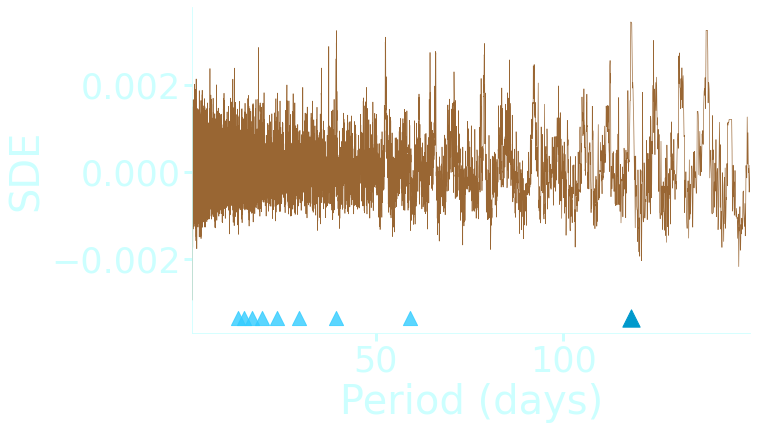

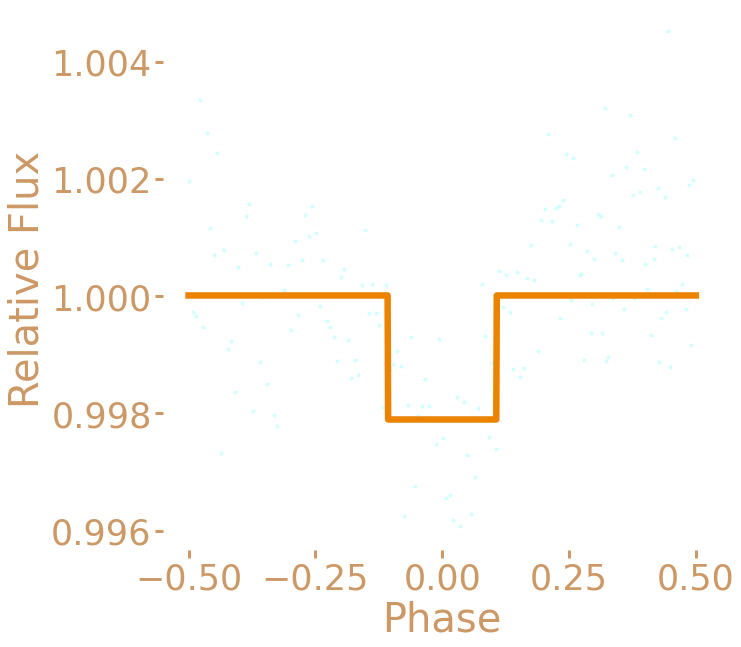

T0:  1349.1041266185207 duration:  0.215 npoints_dur:  1.0
done with multis!
per [16.050943411283065]
running single transit search
running single transit search
u,  [0.1604 0.4325]
24
T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan 

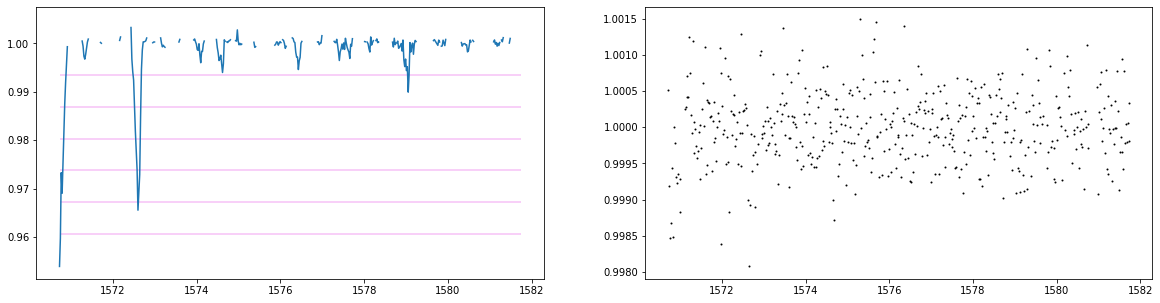

T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


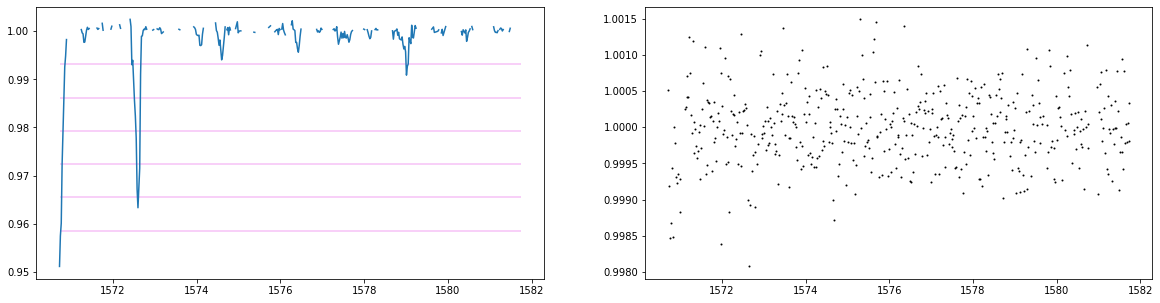

T0_startT0_start  [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan][nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]

T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan 

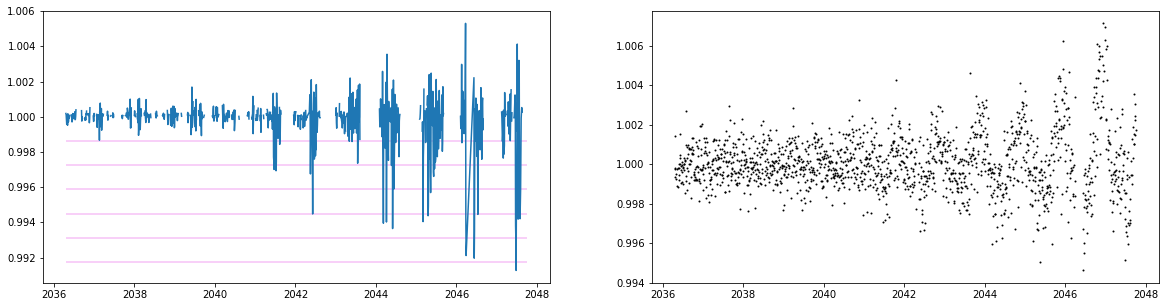

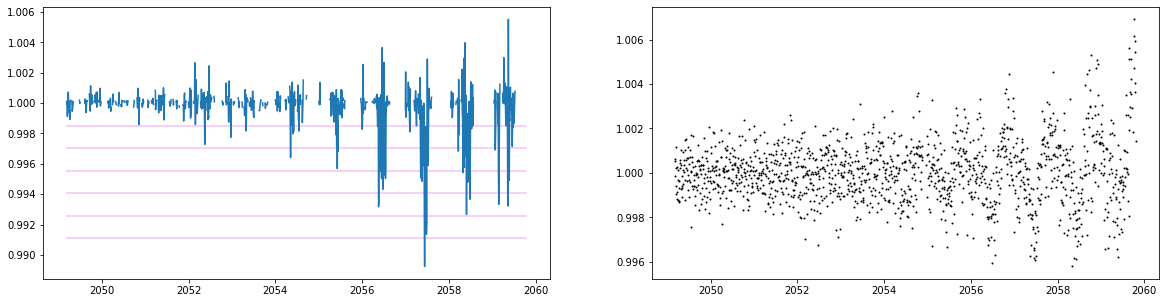

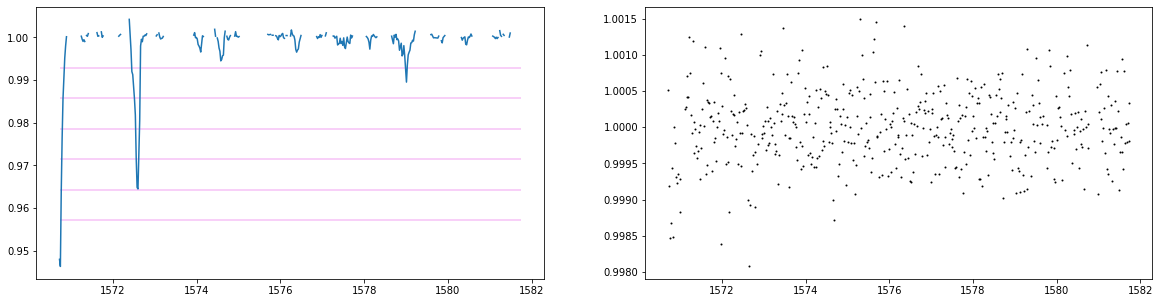

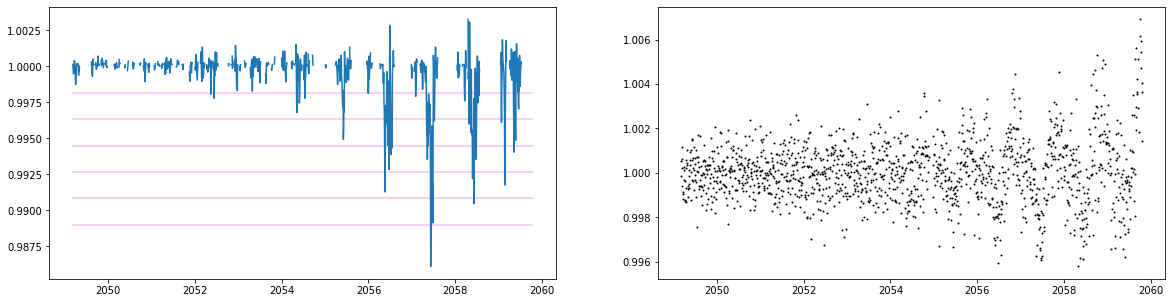

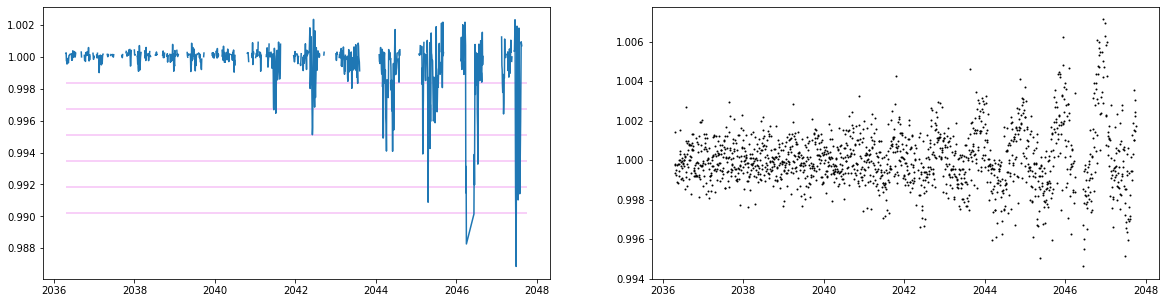

T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


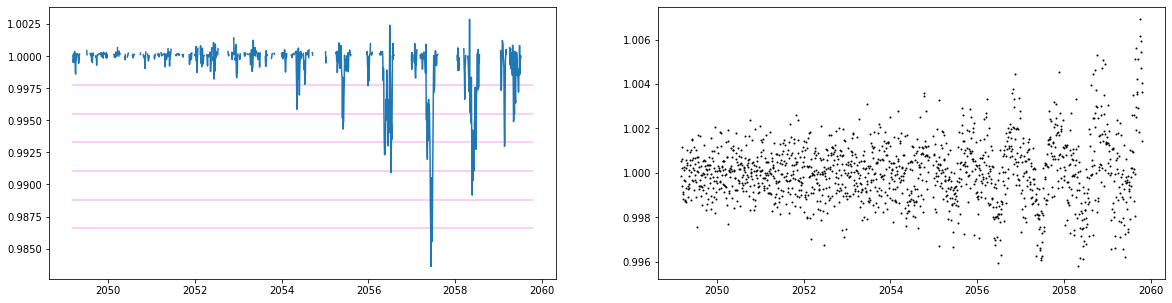

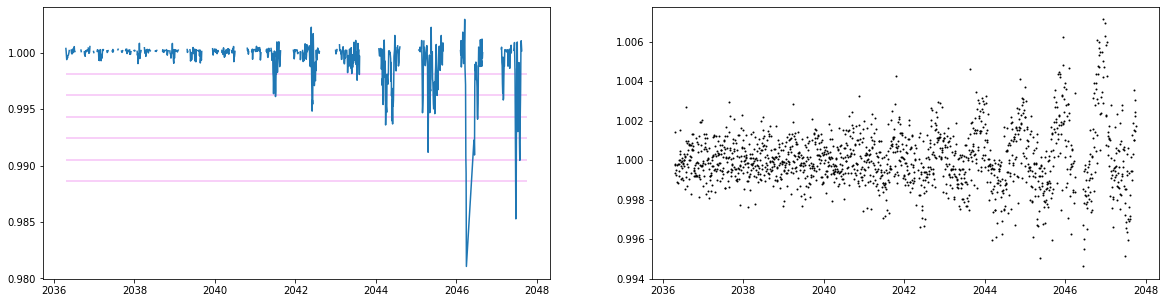

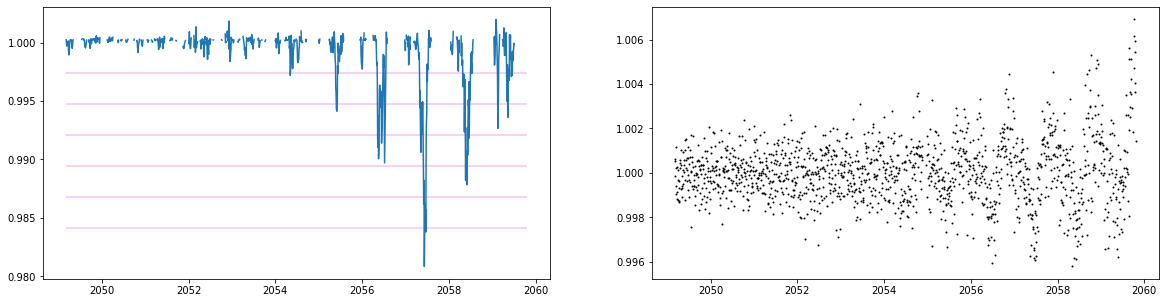

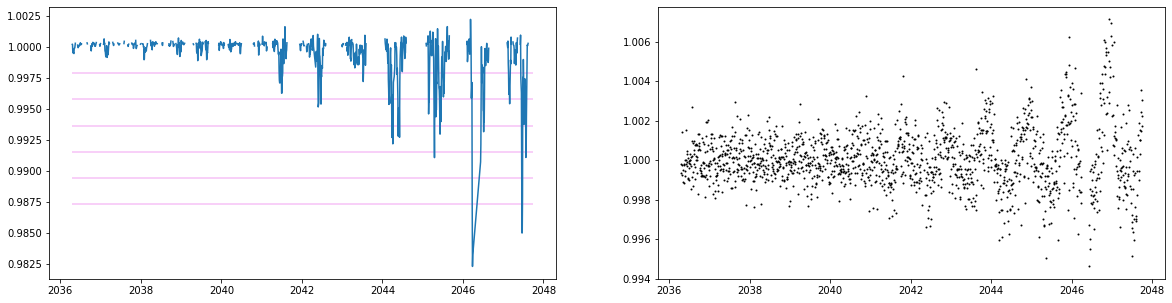

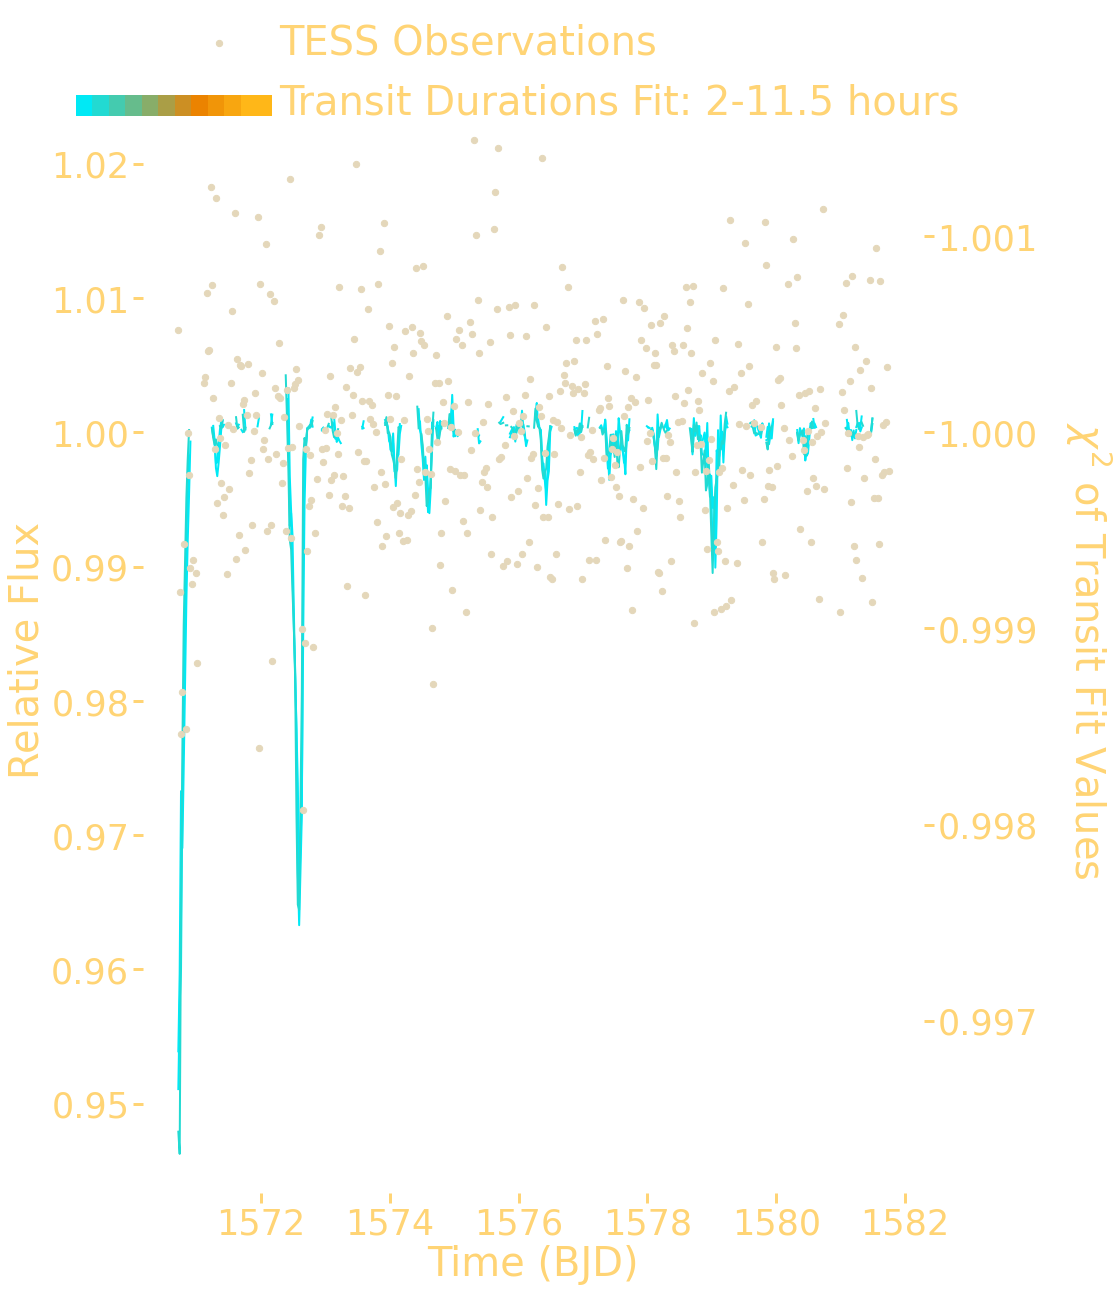

T0_start [ 1.  3. 84. nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


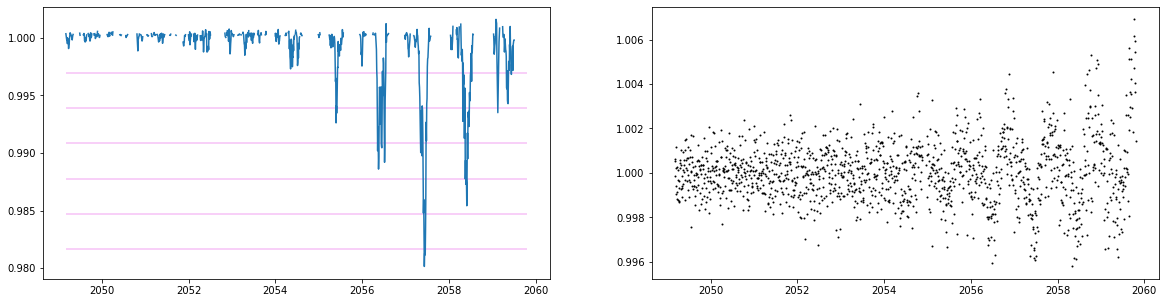

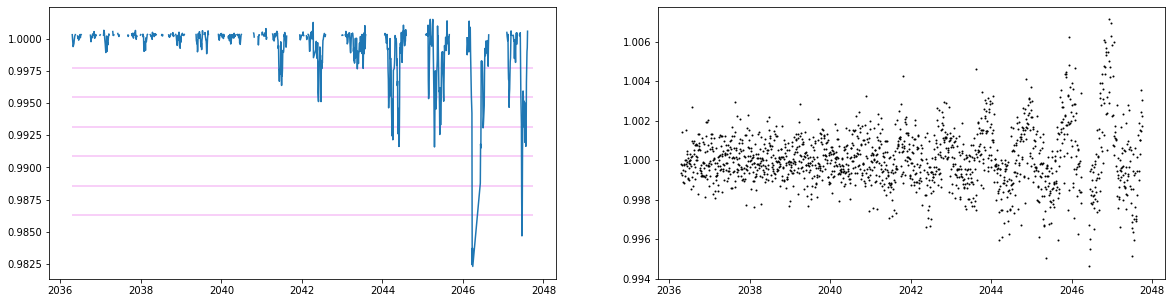

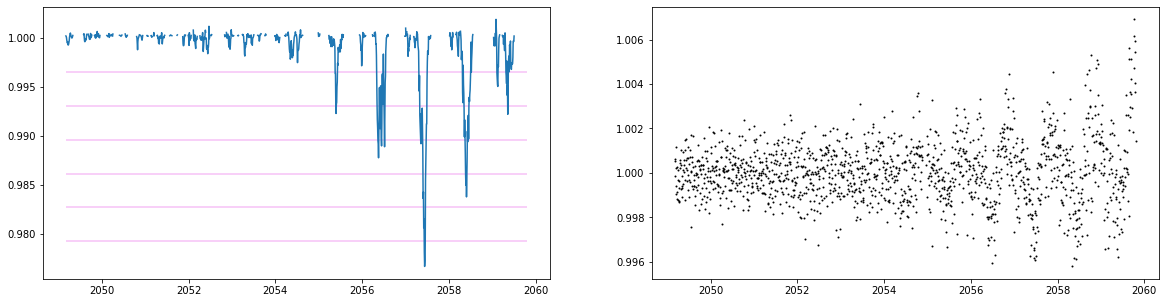

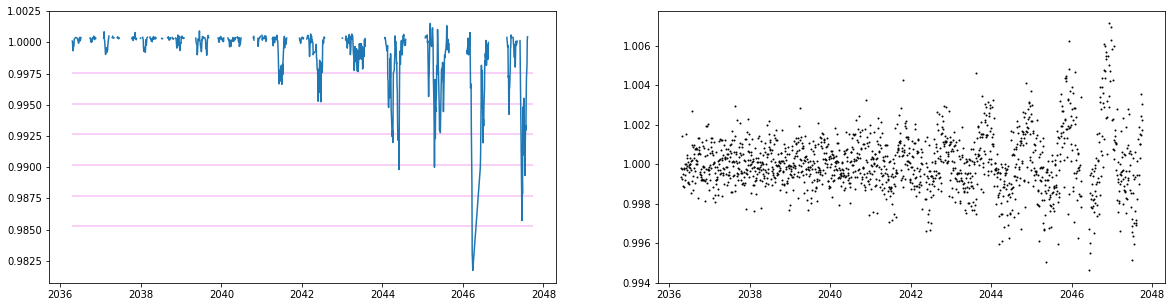

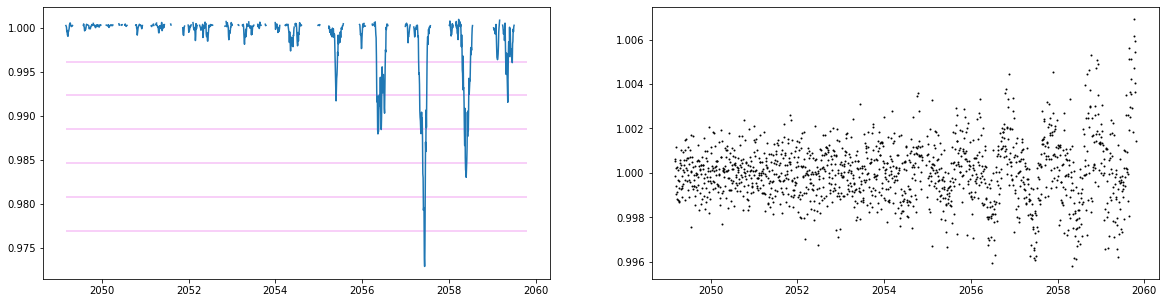

T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


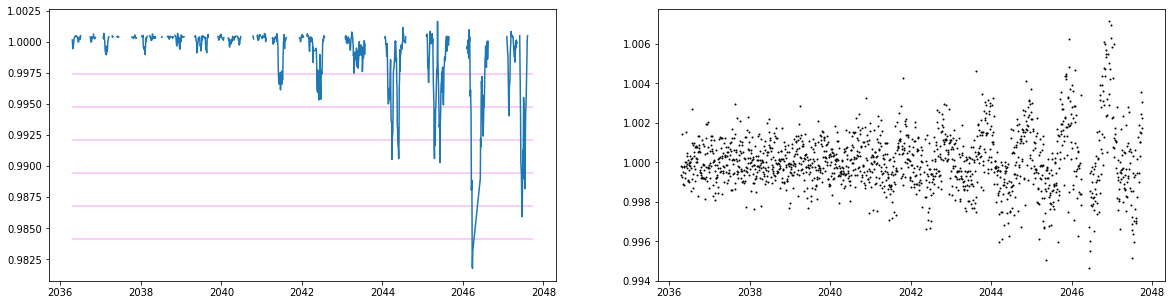

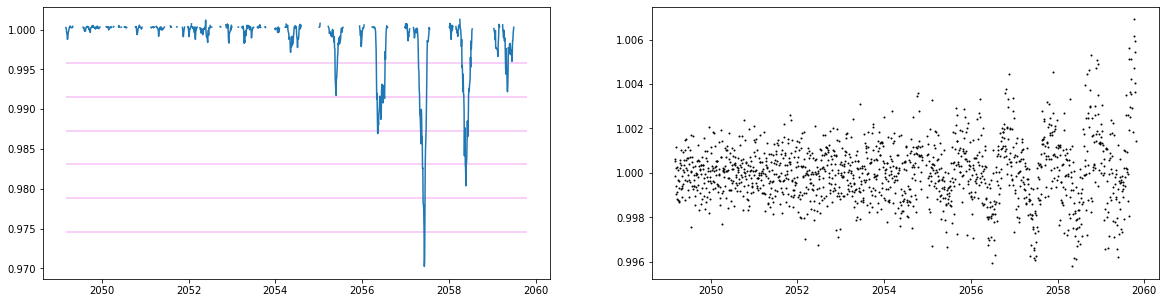

T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


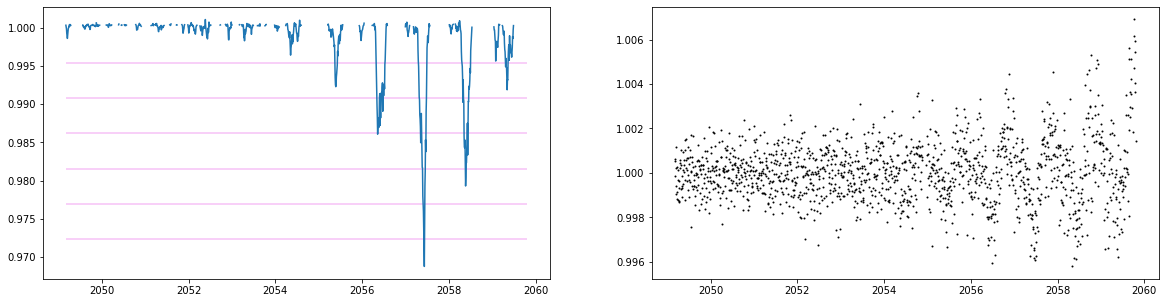

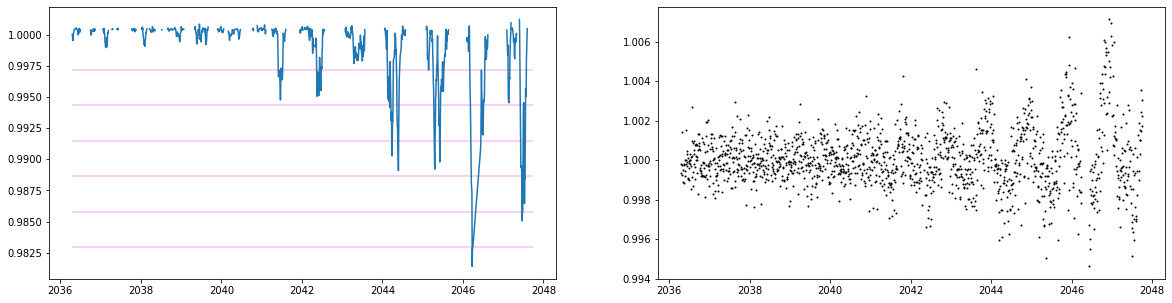

T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan 

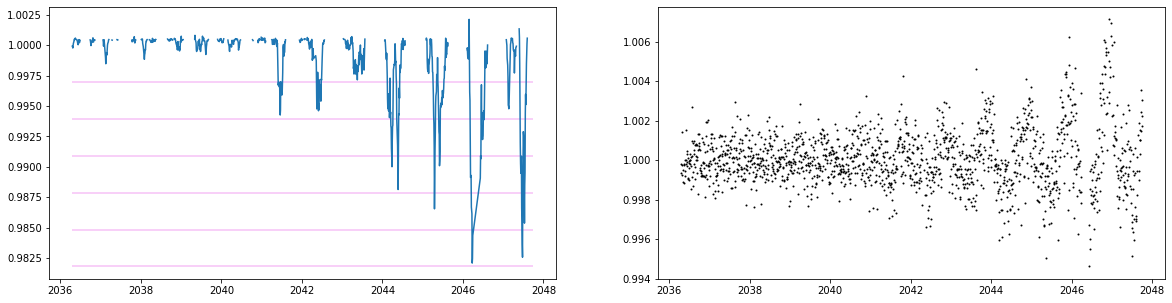

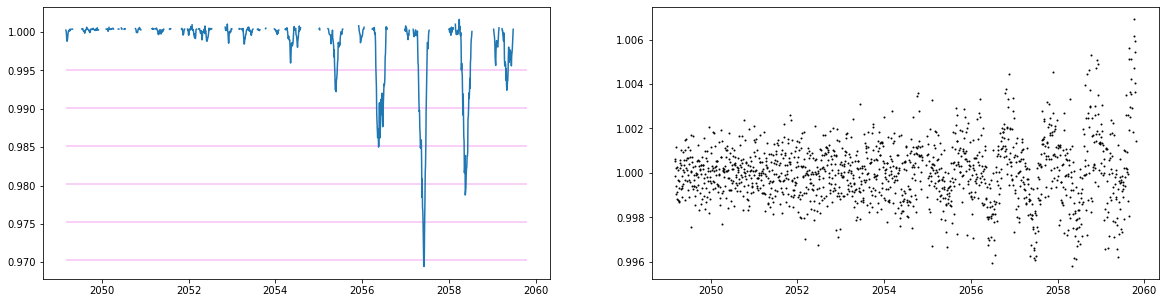

T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


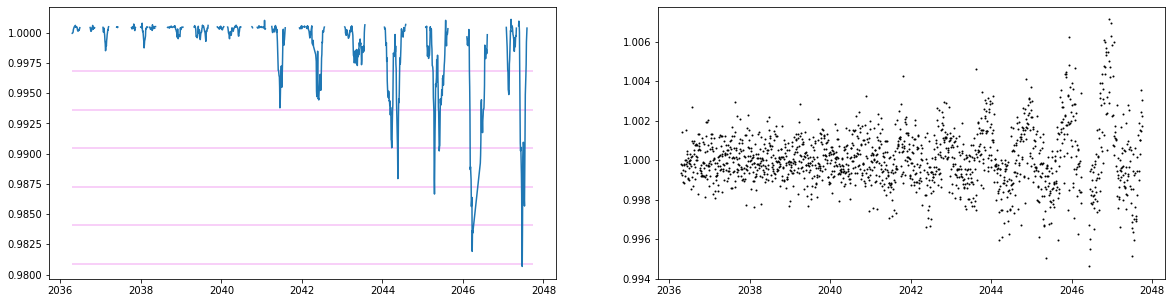

T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


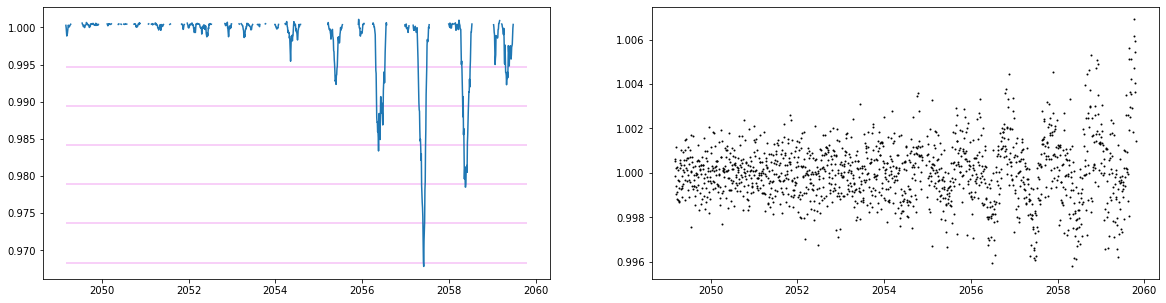

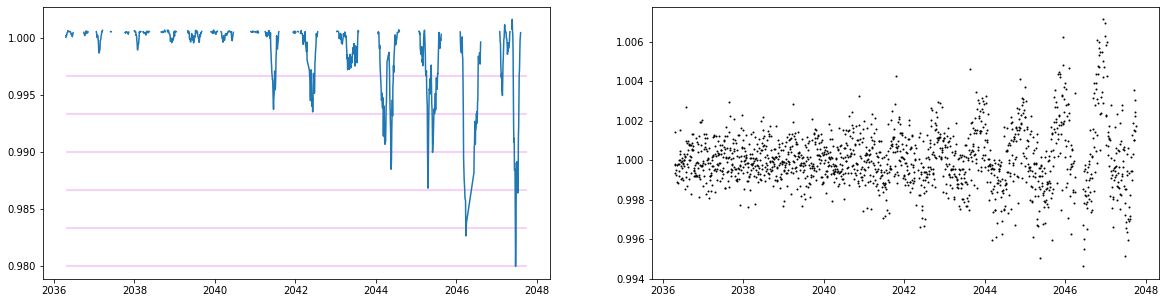

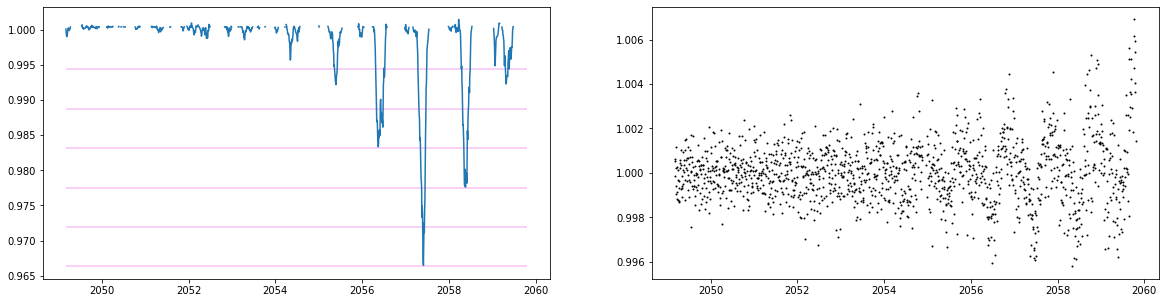

T0_start T0_start[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan] T0_start 
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan 

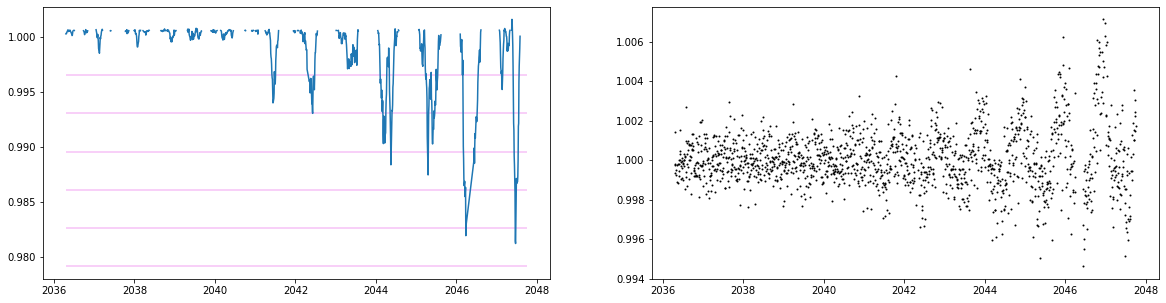

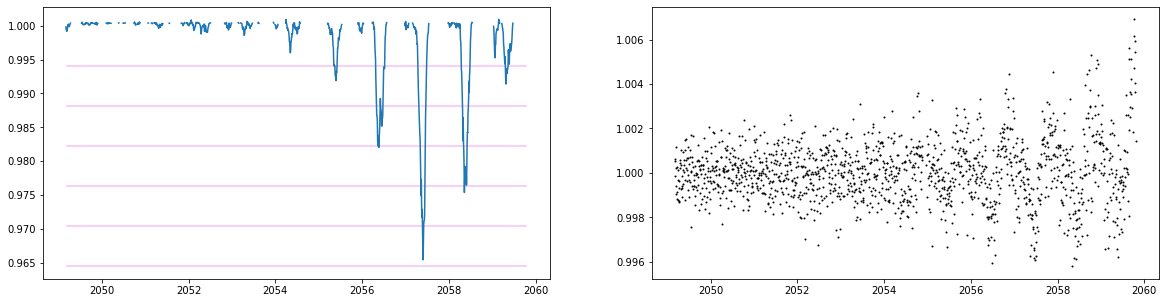

T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


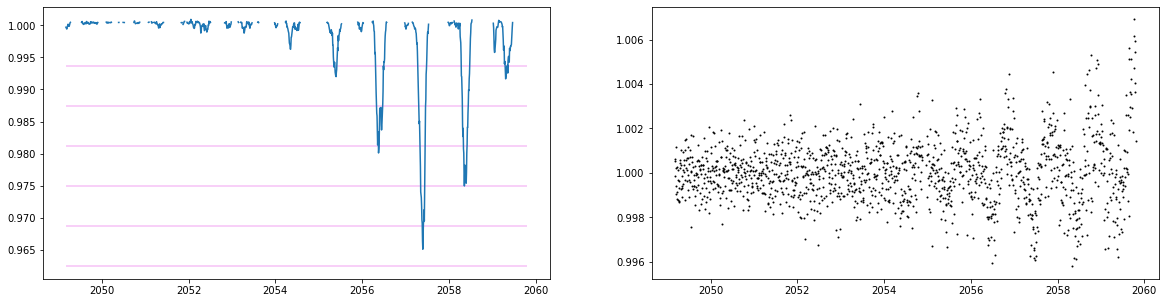

T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


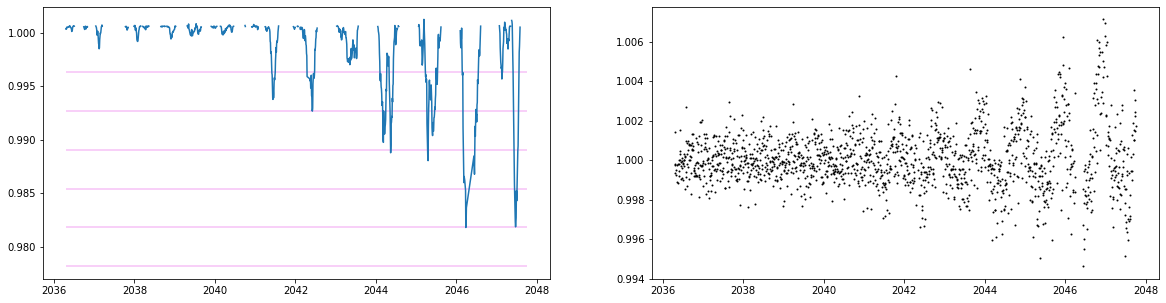

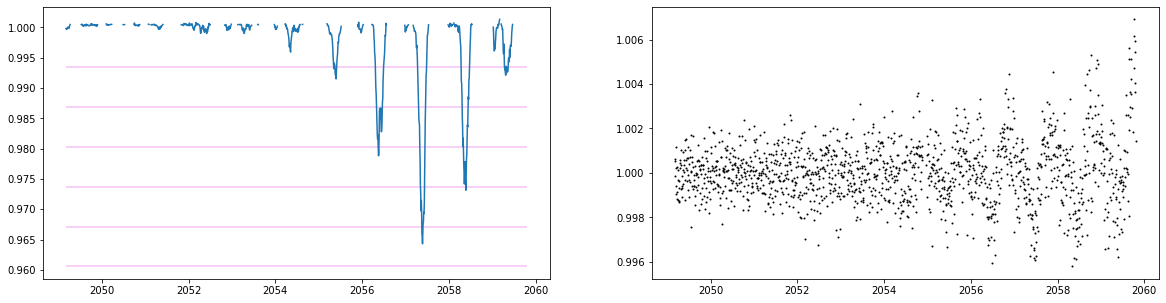

T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


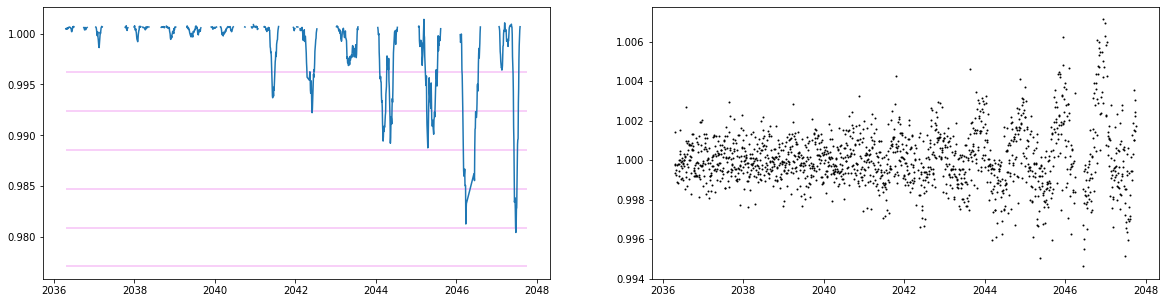

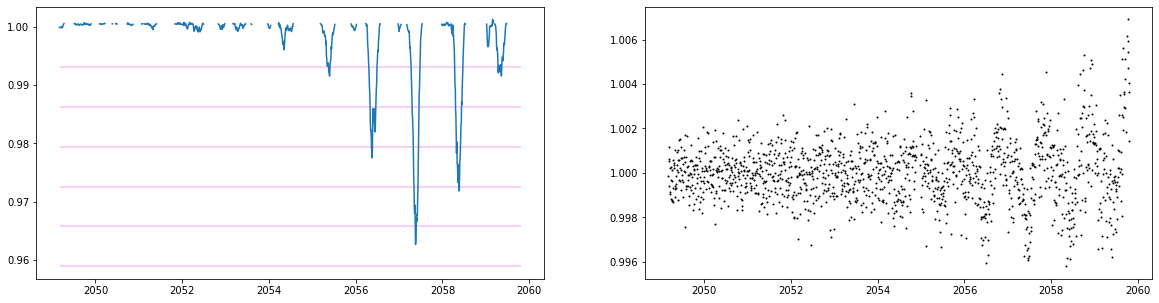

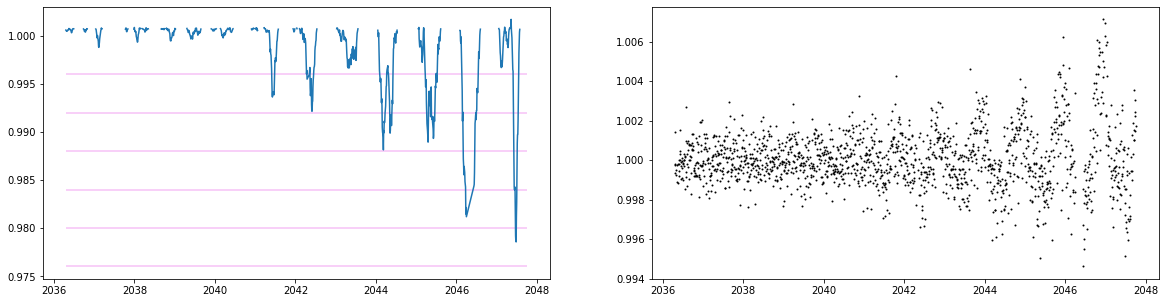

T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


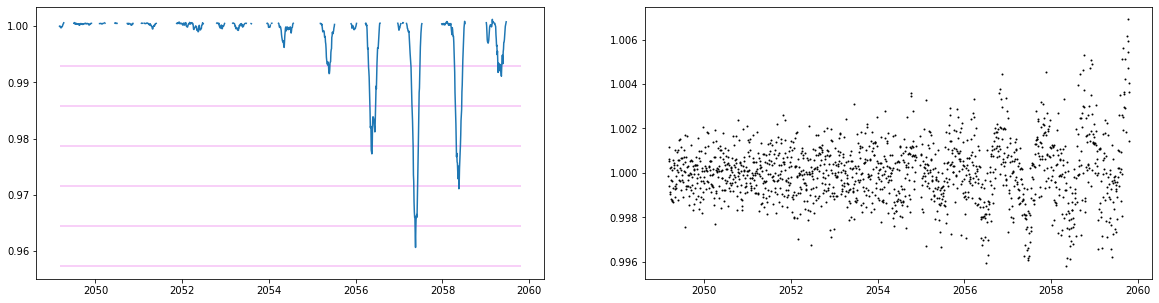

T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


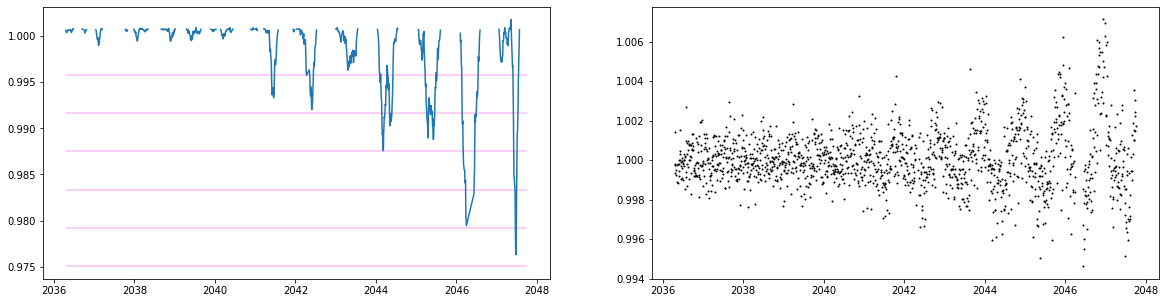

T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


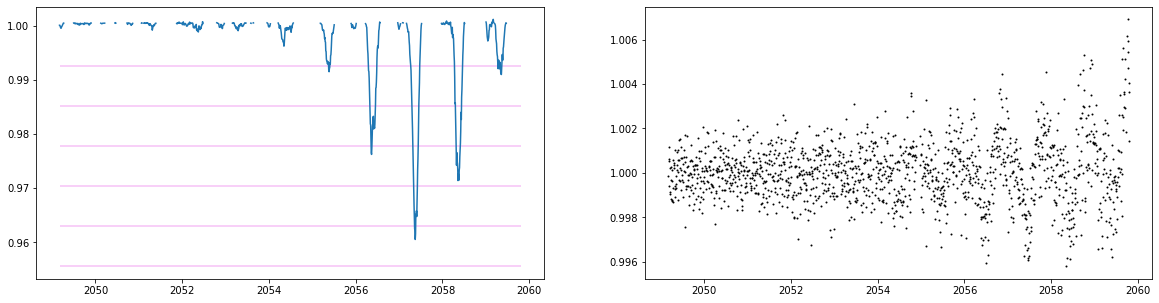

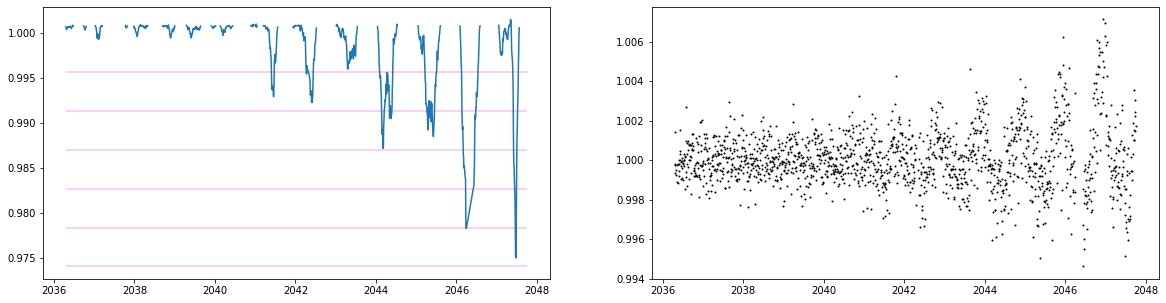

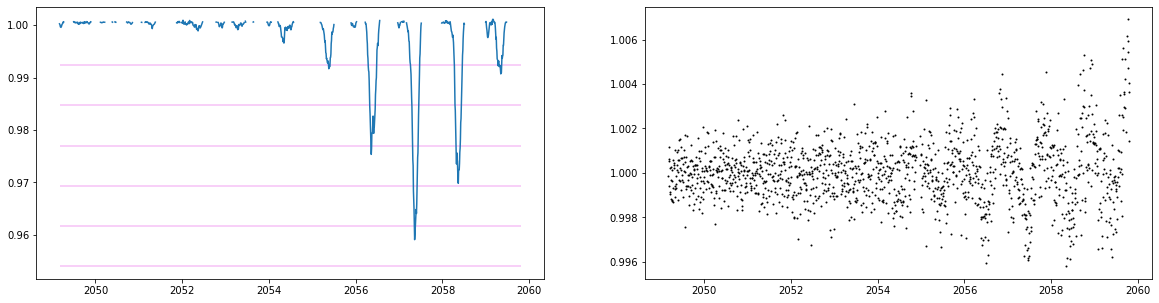

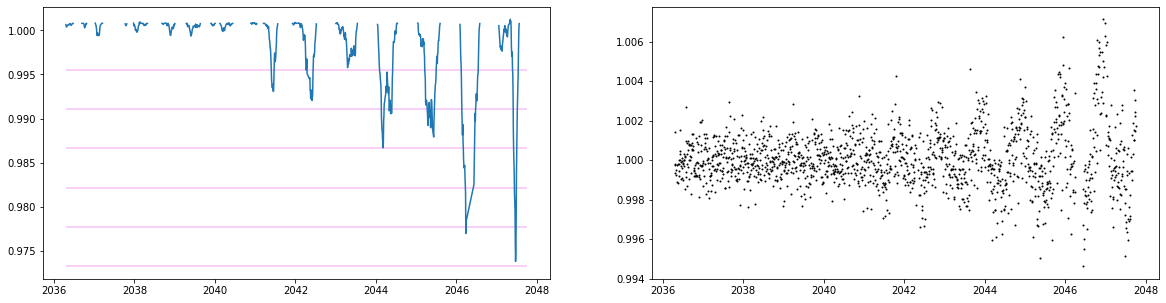

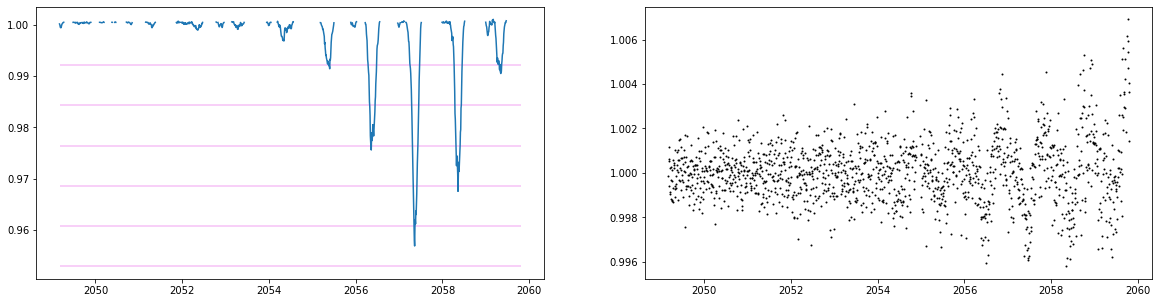

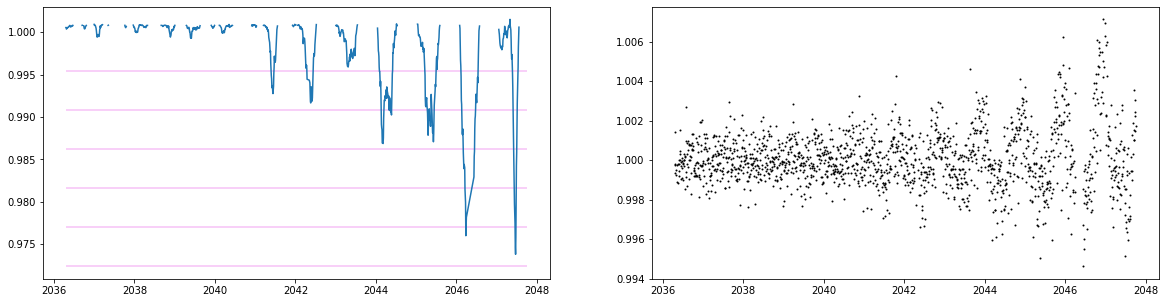

T0_start [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


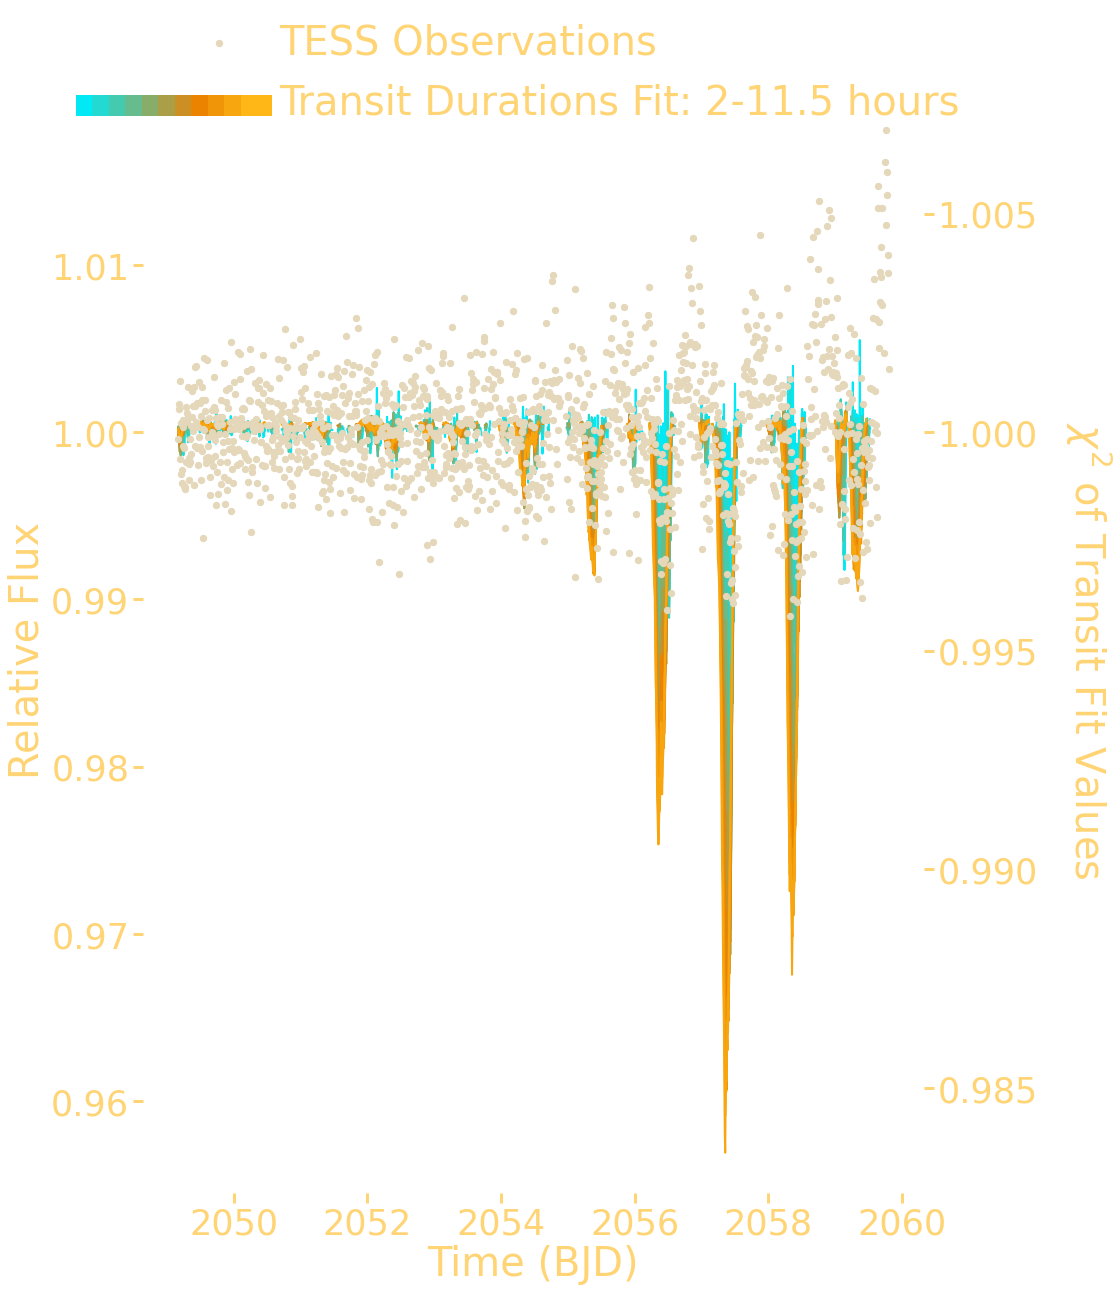

T0_start [1179. 1020. 1173. 1172. 1174. 1177. 1312. 1176. 1313. 1170. 1175. 1311.
 1169. 1171. 1168. 1309. 1310. 1166. 1308. 1167. 1307. 1164. 1165. 1161.
 1162. 1163. 1160. 1159. 1158.   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan]
break [ 0  1 22 28]
break [ 0  1 22 28]
best residuals result [0.97744974 0.95691758 0.9711032 ]


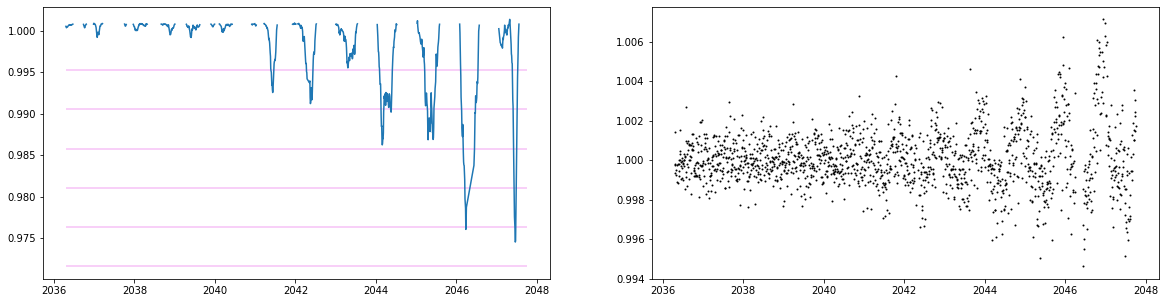

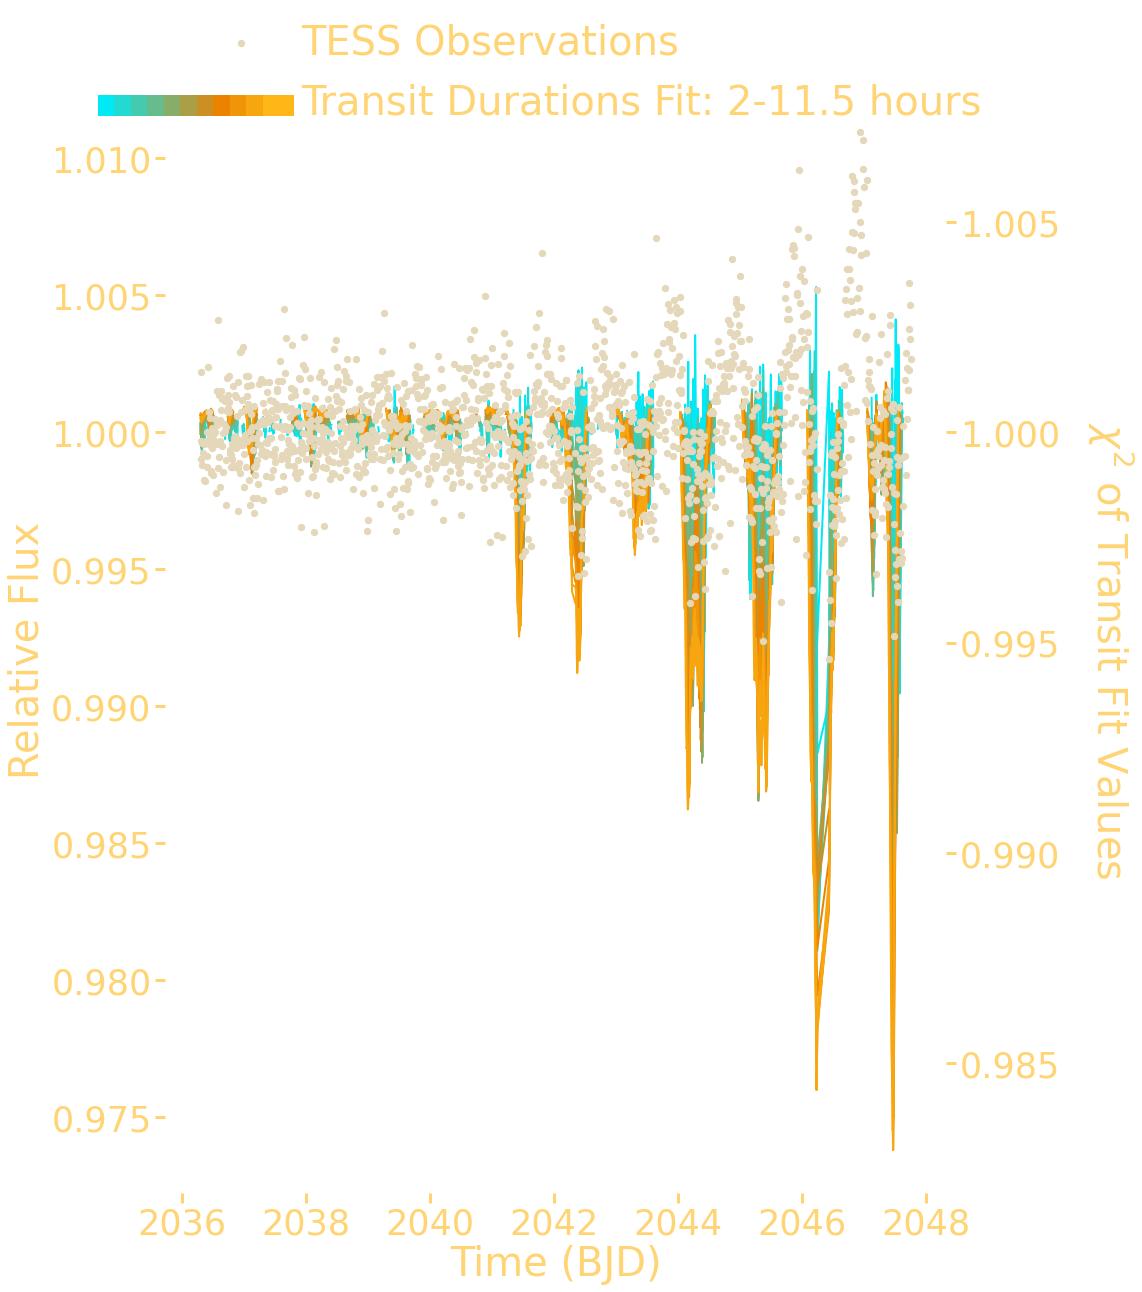

T0_start [1552. 1553. 1410. 1413. 1409. 1411. 1566. 1414. 1412. 1551. 1565. 1550.
 1407. 1408. 1560. 1562. 1555. 1548. 1554. 1549.   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan]
break [ 0  8 16 18 19]
break [ 0  8 16 18 19]
best residuals result [0.97598488 0.97379344 0.98536945        nan]
periodic singles 0
checking singles T0
t0:  1570.969544944796553 , tdur:  5.5  hours
lenghs 1 38043 38043
t0:  2056.8368802968220734 , tdur:  11.0  hours
lenghs 1 38043 38043
t0:  2058.7743710539707536 , tdur:  9.5  hours
lenghs 1 38043 38043
t0:  2057.81604258123525

TypeError: 'set' object is not subscriptable

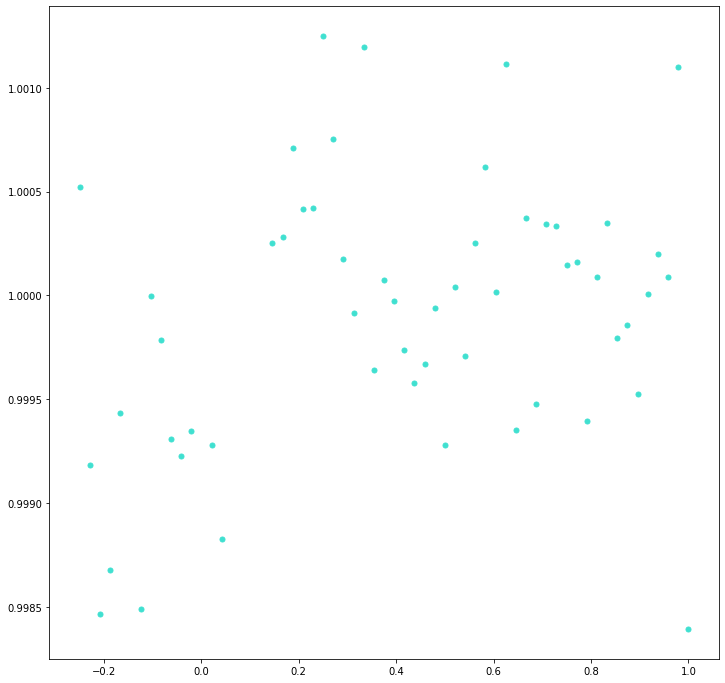

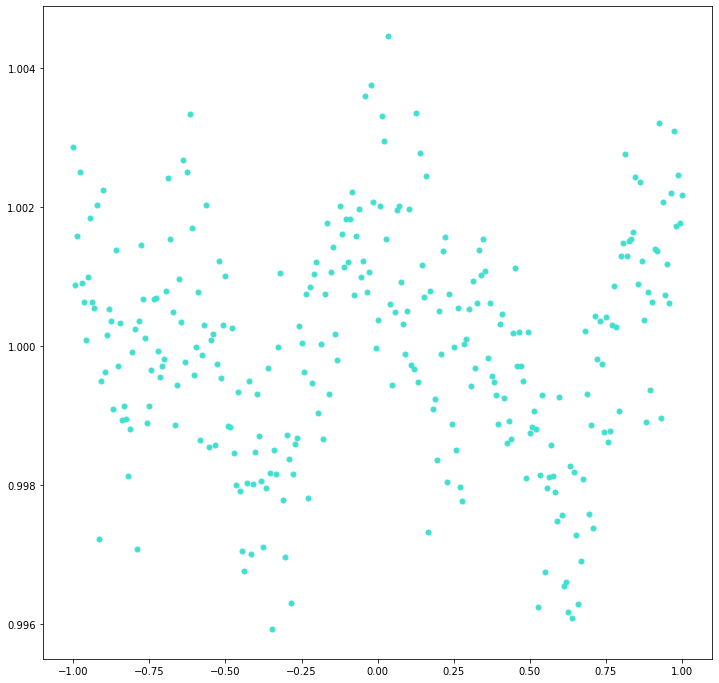

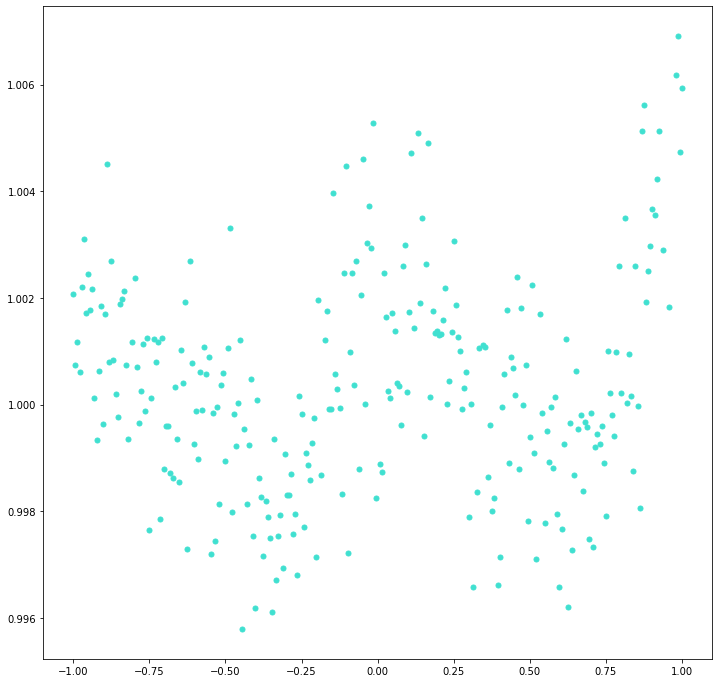

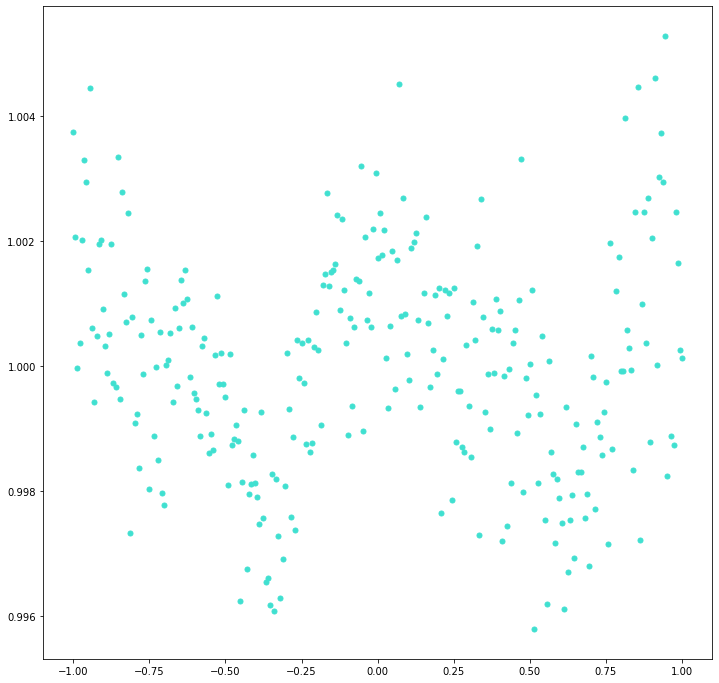

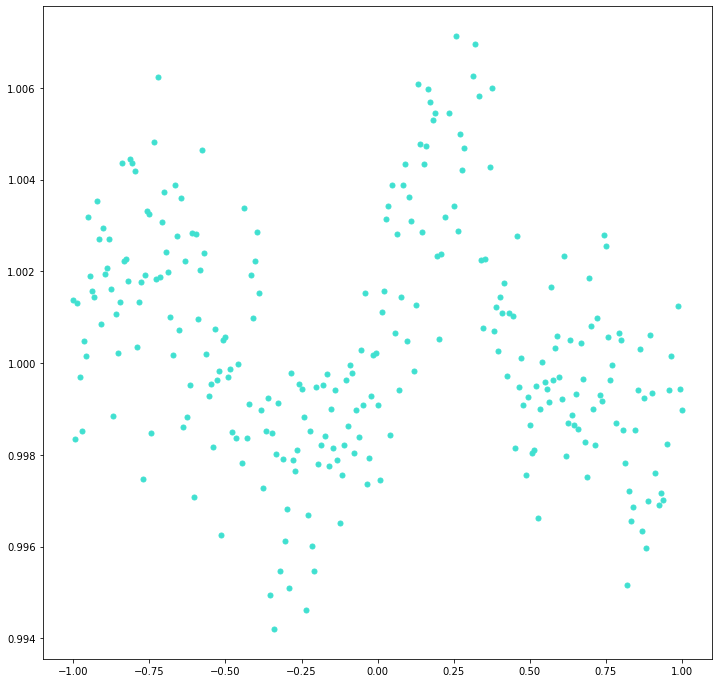

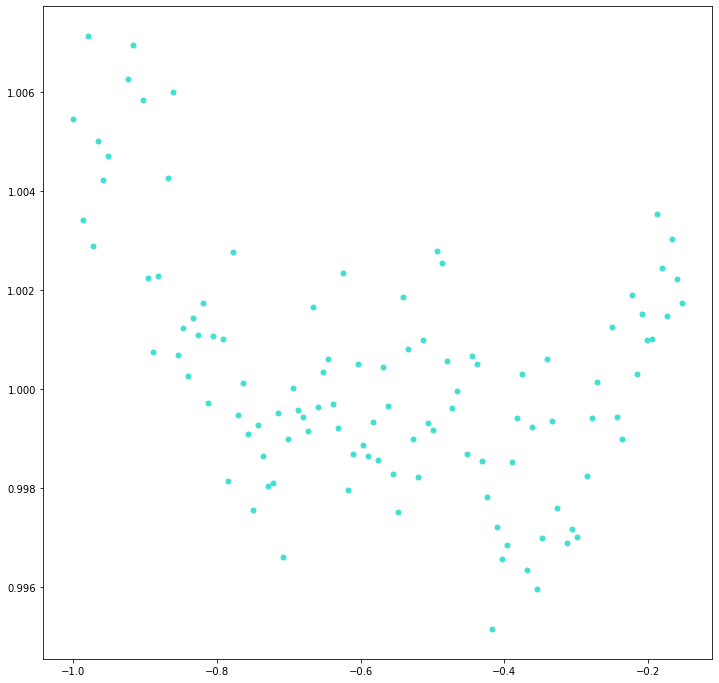

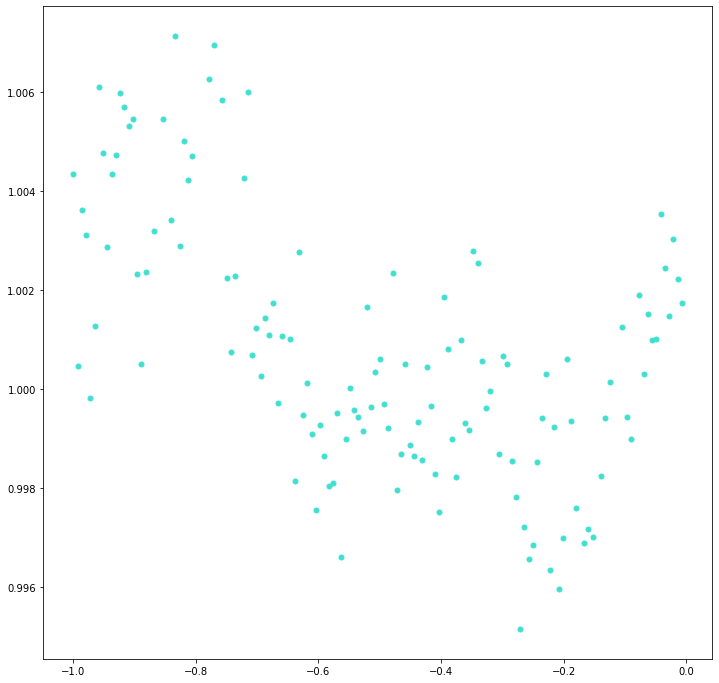

In [71]:
column_names = ['TICID', 'planet_name', 'period', 'T0', 'Tdur', 'depth']

# final_file = './search_mdwarf_planets.csv'
new_planet_df = pd.DataFrame(columns=column_names)
print(new_planet_df)


for iii in ticids_mdwarfs[:1]:
    
    print(iii)
    fits_files = sorted(glob.glob('./known_Mdwarfs_data/FFI_data/all_target_data/tic_'+str(iii)+'_all/*/*/*/*.fits'))
#     print(len(fits_files))
#     fits_files = sorted(glob.glob('./known_Mdwarfs_data/FFI_data/*/*/*/*'+str(iii)+'*/*.fits'))

    if len(fits_files)>0:
    # print(tess_spoc_fits)
        print('num files', len(fits_files))
    #     fits_files
        ab, smass, smass_min, smass_max, sradius, sradius_min, sradius_max = get_catalog_info(iii, mdwarfs_known)
        print(ab)
        T0_all, Tdur_all, depth_all, periods_all = running_search_twice(fits_files, ab, smass, sradius, verbose = True)
        nnn = 0
        for jjj in range(len(T0_all)):
            nnn+=1
            planet_name = str(float(iii)+nnn/100)
            new_planet_df.loc[len(new_planet_df.index)] = [int(iii), planet_name, periods_all[jjj], T0_all[jjj], Tdur_all[jjj],depth_all[jjj]]
#             new_planet_df.to_csv(final_file, index = False, header = False, mode="a",)
        T0_all, Tdur_all, depth_all, periods_all = [], [], [], []
        print('done ', iii, new_planet_df)

In [ ]:
new_planet_df
